# Optically-dark short GRBs

**Caden Gobat**, The George Washington University

## Imports/loading/setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, astropy.units as u
from matplotlib import ticker

from astropy.io import votable, ascii
from astropy.coordinates import SkyCoord
from gdpyc.core import GasMap, DustMap
from scipy import interpolate, stats, optimize

from code.xrt import XRT_lightcurve, get_photonIndex, get_temporalIndex, get_columnDensity

from asymmetric_uncertainty import AsymmetricUncertainty, UncertaintyArray

#calc_code = importlib.import_module("legacy.Calculation Code.calc_beta_ox")
#graph_code = importlib.import_module("legacy.Graphing Code.Graphing_Beta_OX")
log_mean = lambda x1,x2 : 10**np.mean((np.log10(x1),np.log10(x2)))
log_slope = lambda point1,point2 : np.log10(point2[1]/point1[1])/np.log10(point2[0]/point1[0])
Hz_per_keV = 241797944177033445

Main code has been moved to [`pipeline.ipynb`](./pipeline.ipynb). Running the cell below will perform the entire analysis and output the list of dark sGRBs.

In [ ]:
error_B_ox = True # whether to incorporate Δβₒₓ (due to temporal separation) in errors
restrictive = True # whether to use a permissive inequality cut for determining darkness (<< vs. <)
max_dt = 0.2 # maximum allowable temporal separation between optical and X-ray data points (%)

%run pipeline.ipynb

In [78]:
dark_GRBs

GRB dark points w/ Δβₒₓ dark points no Δβₒₓ
0   210323A                   1                   3
1   200411A                   1                   1
2   200219A                   1                   2
3   191031D                   1                   1
4   190719C                   6                   6
5   181123B                   1                   1
6   180727A                   1                   1
7   180618A                   1                   1
8   180204A                   2                   2
9   170827A                   2                   2
10  170822A                   7                   7
11  170728B                  31                  31
12  170127B                   1                   1
13  161004A                   2                   2
47  161001A                   0                   1
14  160927A                   1                   1
15  160821B                   4                   4
16  160624A                   2                   2
17  160525B                   1                   1
18  160408A                   1                   1
19  151229A                   5                   6
20  150831A                   1                   1
21  150424A                   8                   8
22  150120A                   1                   1
23  140930B                   1                   1
48  131004A                   0                   1
24  130912A                   6                   6
25  130603B                   4                   4
26  121226A                   1                   1
27  120804A                   3                   4
28  120521A                   1                   1
29  120305A                   2                   2
30  111117A                   1                   1
49  110402A                   0                   1
50  110112A                   0                   1
31  110106A                   1                   1
32  101219A                   1                   2
33  100816A                   1                   1
34  100702A                   1                   1
35  100625A                   2                   2
36  100117A                   1                   1
37   090515                   1                   1
38   090510                   9                   9
39   090423                   5                   6
51  081024A                   0                   1
40   080913                   8                   8
41   080503                   2                   2
42   080123                   2                   2
43  070714B                   3                   3
44   070707                   2                   2
45   060313                   4                   5
46   060121                  39                  39

## $\LaTeX$ table formatting

In [47]:
def round_scientific(number, places):
    return float(f"%.{places}e"%number)

sample_df = sGRBs[['GRB', 'TriggerNumber', 'BAT T90[sec]', 'Redshift', 'Beta_X', 'Beta_X_neg', 'Beta_X_pos', 'N_H (intrinsic)']].copy()
sample_df.loc[sample_df["Beta_X"].notna(),"B_x"] = [AsymmetricUncertainty(*row[['Beta_X', 'Beta_X_pos', 'Beta_X_neg']]) for i,row in sample_df.loc[sample_df["Beta_X"].notna(),:].iterrows()]
# sample_df.loc[sample_df["N_H (intrinsic)"].notna(),"N_H (intrinsic)"] = [AsymmetricUncertainty(entry) for entry in sample_df.loc[sample_df["N_H (intrinsic)"].notna(),"N_H (intrinsic)"]]
sample_df.drop(['Beta_X', 'Beta_X_pos', 'Beta_X_neg'], axis=1, inplace=True)
sample_df.rename(columns={"B_x":"Beta_X","BAT T90[sec]":"T90","TriggerNumber":"Trigger"},inplace=True)

for i,row in sample_df.iterrows():
    bx = row["Beta_X"]
    nh = row["N_H (intrinsic)"]
    if pd.notna(nh):
#         rounded_nh = (round_scientific(number,3) for number in nh.items())
#         rounded_nh = AsymmetricUncertainty(*rounded_nh)
        sample_df.loc[i,"N_H (intrinsic)"] = AsymmetricUncertainty(round(nh.value/1e21,3),
                                                                   round(nh.plus/1e21,3),
                                                                   round(nh.minus/1e21,3))
    if pd.notna(bx):
        rounded_bx = (round(number,2) for number in bx.items())
        rounded_bx = AsymmetricUncertainty(*rounded_bx)
        sample_df.loc[i,"Beta_X"] = rounded_bx
table_str = sample_df.to_latex(index=False, columns=["GRB","Trigger","T90","Redshift","Beta_X","N_H (intrinsic)"],na_rep='---')

In [48]:
for line in table_str.split("\n")[4:-3]:
    grb,trig,t90,z,beta_orig,n_h_orig = line.split("&")
    n_h_orig = n_h_orig[:-2]
    if beta_orig.strip() != "---":
        beta = beta_orig
        beta = beta.replace(" (+","^{+")
        beta = beta.replace(", -","}_{-")
        beta = beta.replace(")","}")
        beta = beta.replace("±",r"\pm")
        table_str = table_str.replace(beta_orig," $"+beta.strip()+"$ ")
    if n_h_orig.strip() != "---":
        n_h = n_h_orig
        n_h = n_h.replace("(+","^{+")
        n_h = n_h.replace(", -","}_{-")
        n_h = n_h.replace(")","}")
        if "±" not in n_h:
            pass
#             print(n_h)
#             val,err = n_h.split()
#             n_h = "("+val+")"+err
        else:
            n_h = n_h.replace("±",r"\pm")
        table_str = table_str.replace(n_h_orig," $"+n_h.strip()+"$ ")
# table_str = table_str.replace("e+19",r"\times10^{19}")
# table_str = table_str.replace("e+20",r"\times10^{20}")
# table_str = table_str.replace("e+21",r"\times10^{21}")
# table_str = table_str.replace("e+22",r"\times10^{22}")
print(table_str)

\begin{tabular}{llllll}
\toprule
    GRB &                    Trigger &        T90 &              Redshift &               Beta\_X &        N\_H (intrinsic) \\
\midrule
211227A &                    1091101 &      83.79 &                   --- & $2.0^{+0.7}_{-0.6}$ & $2.9 ^{+1.8}_{-1.5}$ \\
211221A &                    1090472 &     671.67 &                   --- & $0.59^{+0.31}_{-0.29}$ & $9.0 ^{+4.0}_{-3.0}$ \\
211207A &                    1088376 &       3.73 &                 2.272 & $1.02^{+0.25}_{-0.24}$ & $15.7 ^{+11.5}_{-9.6}$ \\
211106A &                  BAT/GUANO &       1.75 &                   --- & $0.1^{+1.06}_{-0.42}$ & $0.0 ^{+3.43}_{-0.0}$ \\
211023B &                    1080859 &       1.30 &                 0.862 & $1.12^{+0.23}_{-0.21}$ & $0.9 ^{+0.6}_{-0.5}$ \\
210919A &                    1073893 &       0.16 &                   --- & $1.1^{+3.3}_{-1.1}$ & $1.1 ^{+24.7}_{-1.1}$ \\
210726A &                    1061687 &       0.39 &                   --- & $1.2^{+0

In [39]:
xtable = xrt_data[['GRB', 'Time', 'Tpos', 'Tneg', 'SpecFlux']].round(2).copy()
xtable["tx"] = [AsymmetricUncertainty(*row[["Time","Tpos","Tneg"]]) for i,row in xtable.iterrows()]
xtable["SpecFlux"] *= 1e6
xtable["Fx"] = [AsymmetricUncertainty(round(row["SpecFlux"].value,3),
                                      round(row["SpecFlux"].plus,3),
                                      round(row["SpecFlux"].minus,3)) for i,row in xtable.iterrows()]
print(xtable[["GRB","tx","Fx"]].to_latex(index=False).replace(" (","^{").replace(", ","}_{").replace(")","}$").replace("& ","& $"))

\begin{tabular}{lll}
\toprule
    GRB & $                                 tx & $                           Fx \\
\midrule
211227A & $               63.73^{+0.27}_{-0.25}$ & $   232.235^{+64.384}_{-57.996}$ \\
211227A & $               64.32^{+0.28}_{-0.32}$ & $    339.521^{+89.75}_{-80.209}$ \\
211227A & $               64.97^{+0.33}_{-0.37}$ & $   332.516^{+87.644}_{-78.003}$ \\
211227A & $                 65.6^{+0.39}_{-0.3}$ & $   270.464^{+71.232}_{-63.363}$ \\
211227A & $                66.34^{+0.3}_{-0.35}$ & $   308.861^{+81.381}_{-72.555}$ \\
211227A & $               67.01^{+0.34}_{-0.37}$ & $   286.421^{+75.734}_{-67.795}$ \\
211227A & $                       67.61 ± 0.26 & $  386.146^{+102.279}_{-91.863}$ \\
211227A & $                68.18^{+0.3}_{-0.31}$ & $   356.721^{+94.934}_{-85.831}$ \\
211227A & $               68.79^{+0.32}_{-0.31}$ & $   245.729^{+69.837}_{-64.217}$ \\
211227A & $                       69.44 ± 0.34 & $    255.889^{+73.044}_{-65.54}$ \\
211227A & $ 

In [9]:
print(pd.DataFrame(np.array([[grb,sum(xrt_data["GRB"]==grb),sum(all_optical["GRB"]==grb),sum(results["GRB"]==grb),sum(close_times["GRB"]==grb)] for grb in sGRBs["GRB"]]),
             columns=["GRB","X-ray points","Optical points","Temporal matches","Dark points"]).to_latex(index=False))

\begin{tabular}{lllll}
\toprule
    GRB & X-ray points & Optical points & Temporal matches & Dark points \\
\midrule
211227A &          101 &              0 &                0 &           0 \\
211221A &           25 &              0 &                0 &           0 \\
211207A &           13 &              0 &                0 &           0 \\
211106A &            4 &              0 &                0 &           0 \\
211023B &           19 &              0 &                0 &           0 \\
210919A &            2 &              0 &                0 &           0 \\
210726A &           15 &              0 &                0 &           0 \\
210725B &           20 &              0 &                0 &           0 \\
210708A &           10 &              0 &                0 &           0 \\
210704A &            5 &             20 &                4 &           3 \\
210618A &            0 &              0 &                0 &           0 \\
210413B &            0 &              4 &      

## *Swift*-XRT lightcurve/spectrum demo

In [24]:
burst = "050603"
fluxdata = XRT_lightcurve(burst)
Gamma,mode = get_photonIndex(burst)
NH,mode = get_columnDensity(burst)

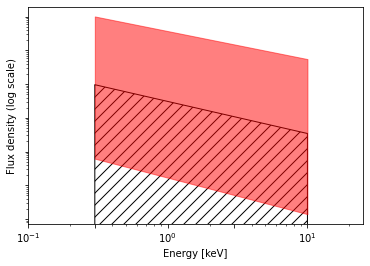

In [25]:
E_range = np.linspace(0.3,10,100)
spectrum = (E_range / 4.135667696e-18)**-(Gamma.value-1)
spec1 = (E_range / 4.135667696e-18)**-(Gamma.maximum-1)
spec2 = (E_range / 4.135667696e-18)**-(Gamma.minimum-1)

plt.fill_between(E_range,[0]*len(E_range),spectrum,fc="none",ec="k",hatch="//")
plt.fill_between(E_range,spec1,spec2,alpha=0.5,color="r")
plt.xlim(1e-1,25)
#plt.ylim(1e-16,1e-4)
plt.yscale("log")
plt.xscale("log")
plt.gca().set_xticks([0.1,0.3,1,3,10])
#plt.gca().set_xticklabels([0.1,0.3,1,3,10])
#plt.gca().set_yticks([])
plt.gca().set_yticklabels([])
plt.xlabel("Energy [keV]")
plt.ylabel("Flux density (log scale)")
plt.show()

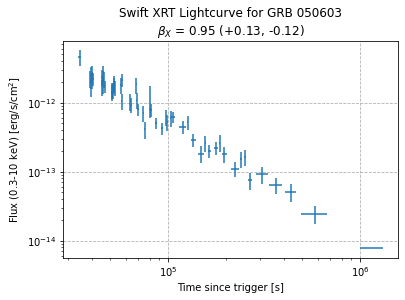

In [26]:
plt.errorbar(fluxdata.Time,fluxdata.Flux,xerr=np.array(fluxdata.Tneg,fluxdata.Tpos).T,
             yerr=np.array(fluxdata.Fluxneg,fluxdata.Fluxpos).T,linestyle="",capthick=0)
plt.xscale("log")
plt.yscale("log")
plt.title("Swift XRT Lightcurve for GRB %s\n$\\beta_X$ = %s" % (burst,Gamma-1))
plt.xlabel("Time since trigger [s]")
plt.ylabel("Flux (0.3-10 keV) [erg/s/cm$^2$]")
plt.grid(linestyle="--")

plt.show()

## Filter transmission calculations

c:\users\caden gobat\appdata\local\programs\python\python38\lib\site-packages\pandas\io\parsers.py:765: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return read_csv(**locals())


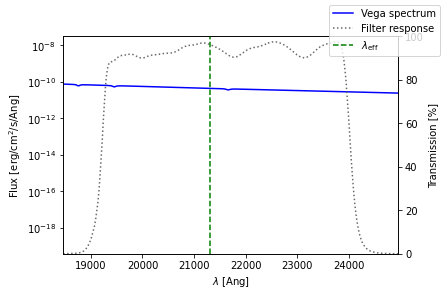

21303.690943444715

In [4]:
from code.fluxtools import effective_wavelength

# I_filter = pd.read_table("http://www2.lowell.edu/rsch/LMI/I.txt",header=None)
# I_filter.columns = ["Wavelength","Transmission"]
# I_filter["Wavelength"] *= 10
# rprime_filter = pd.read_table("http://www2.lowell.edu/rsch/LMI/r-band.txt").drop(columns=["T%"],axis=0)
# rprime_filter.columns = ["Wavelength","Transmission"]
# rprime_filter["Wavelength"] *= 10
MOSFIRE_J = pd.read_table("https://www2.keck.hawaii.edu/inst/mosfire/data/filter/mosfire_J.txt",delimiter="   ").iloc[:,:2]
MOSFIRE_J = MOSFIRE_J.rename(columns=dict(zip(MOSFIRE_J.columns,["Wavelength","Transmission"]))).apply(pd.to_numeric,errors="coerce").dropna()
MOSFIRE_J["Wavelength"] *= 10000
MOSFIRE_J["Transmission"] *= 100

MOSFIRE_K = pd.read_table("https://www2.keck.hawaii.edu/inst/mosfire/data/filter/mosfire_K.txt",delimiter="   ",engine='python').iloc[:,:2]
MOSFIRE_K = MOSFIRE_K.rename(columns=dict(zip(MOSFIRE_K.columns,["Wavelength","Transmission"]))).apply(pd.to_numeric,errors="coerce").dropna()
MOSFIRE_K["Wavelength"] *= 10000
MOSFIRE_K["Transmission"] *= 100

# REMIR_H = pd.read_csv("./data/REM/H.csv",header=None,names=["Wavelength","Transmission"])
# REMIR_H.sort_values(by="Wavelength",inplace=True)
# REMIR_H["Wavelength"] *= 10
# REMIR_r = pd.read_csv("./data/REM/r'.csv")
# REMIR_r.sort_values(by="Wavelength",inplace=True)
# REMIR_r["Wavelength"] *= 10

# LDSS3_i = pd.read_table("http://www.lco.cl/wp-content/uploads/telescopes/magellan/instruments/ldss3/filters-data/i01.txt",
#                         header=None,names=["Wavelength","Transmission"])
# LDSS3_r = pd.read_table("http://www.lco.cl/wp-content/uploads/telescopes/magellan/instruments/ldss3/filters-data/r01.txt",
#                         header=None,names=["Wavelength","Transmission"])
# LDSS3_r["Wavelength"] *= 10 # nm to Ang

# IMACS_r_below = pd.read_csv("./data/Magellan/IMACS_r.csv",header=None)
# IMACS_r_below.columns = ["Wavelength","Transmission"]
# IMACS_r_below = IMACS_r_below[IMACS_r_below["Wavelength"]<600].copy()
# IMACS_r_below.sort_values(by="Wavelength",inplace=True)
# IMACS_r_below.drop_duplicates(subset=["Wavelength"],inplace=True)
# IMACS_r_above = pd.read_table("http://www.lco.cl/wp-content/uploads/telescopes/magellan/instruments/imacs/imacs-filters/sloan_r_red01.txt",
#                               delimiter="\t",names=["Wavelength","Transmission"])
# IMACS_r = IMACS_r_below.append(IMACS_r_above,ignore_index=True)
# IMACS_r["Wavelength"] *= 10

effective_wavelength(MOSFIRE_K,show_plot=True)

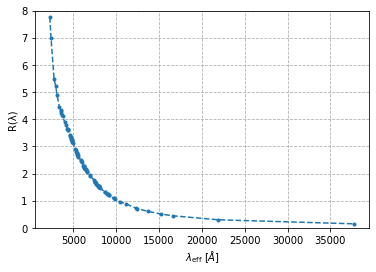

In [72]:
RbTable = pd.read_csv("./data/Rb.csv") # Table 6 from Schlafly & Finkbeiner (2011)
Rb = interpolate.interp1d(RbTable["lambda_eff"],RbTable["R_b"],fill_value="extrapolate") # function that takes a wavelength [Ang] and returns the corresponding R_b value

RbTable.drop([37,55,61,73],axis=0,inplace=True) # smoothing
RbTable.sort_values(by="lambda_eff",inplace=True) # sort in order of wavelength: UV -> IR
plt.plot(RbTable["lambda_eff"], RbTable["R_b"], ".--")
plt.xlabel("$\lambda_\mathrm{eff}$ [$\AA$]")
plt.ylabel("R(λ)")
plt.ylim(0,8)
plt.grid(linestyle="--")
# plt.savefig("./products/RbTable.png",bbox_inches="tight",dpi=300,)

## Plot dark GRBs' lightcurves

1 0 0


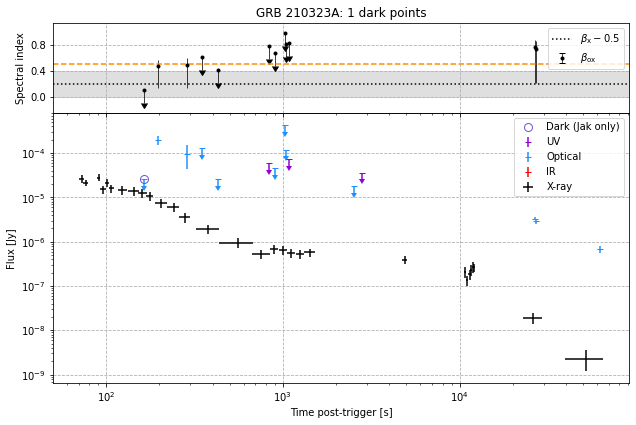

GRB        t_o       dt%  \
19  210323A    164.000  0.022176   
22  210323A    197.856  0.037024   
25  210323A    287.712  0.032951   
26  210323A    348.192  0.078930   
27  210323A    427.000  0.129540   
29  210323A    838.000  0.060724   
32  210323A    899.500  0.008208   
36  210323A   1027.500  0.027058   
40  210323A   1040.000  0.039553   
44  210323A   1077.000  0.033029   
46  210323A  26820.000  0.031177   
47  210323A  26939.520  0.035773   

                                           B_ox_w_err        B_x      α  \
19   0.11224670473253857 (+0.04278139383706613, -inf)  0.7 ± 0.2  1.600   
22  0.48146308092807644 (+0.07892234633808277, -0....  0.7 ± 0.2  1.600   
25  0.48413314165013294 (+0.10816552278366268, -0....  0.7 ± 0.2  1.600   
26    0.6096691043170209 (+0.09695544285472978, -inf)  0.7 ± 0.2  1.600   
27    0.4168772313152361 (+0.10816280268550332, -inf)  0.7 ± 0.2  1.600   
29    0.7770398035669612 (+0.11960739073850142, -inf)  0.7 ± 0.2  0.452   
32    0.6782290321733282 (+0.09815391355477487, -inf)  0.7 ± 0.2  0.452   
36    0.9749658384217068 (+0.12678590989086103, -inf)  0.7 ± 0.2  0.452   
40     0.8118359094467696 (+0.1112225131543405, -inf)  0.7 ± 0.2  0.452   
44    0.8188118699194027 (+0.12104775098046179, -inf)  0.7 ± 0.2  0.452   
46  0.7593483832591326 (+0.11007418307821619, -0.5...  0.7 ± 0.2  3.130   
47  0.7378449358856282 (+0.11113614352790967, -0.5...  0.7 ± 0.2  3.130   

   Jak_dark vdH_dark  
19     True    False  
22    False    False  
25    False    False  
26    False    False  
27    False    False  
29    False    False  
32    False    False  
36    False    False  
40    False    False  
44    False    False  
46    False    False  
47    False    False

1 0 0


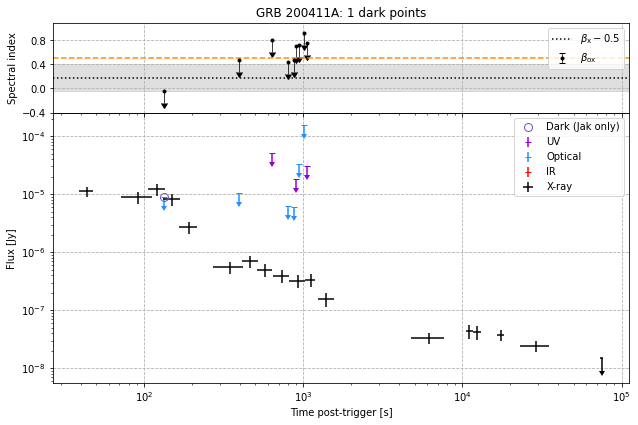

GRB     t_o       dt%  \
72  200411A   133.0  0.102198   
74  200411A   395.0  0.142021   
76  200411A   636.0  0.105920   
78  200411A   799.0  0.092668   
80  200411A   880.0  0.047658   
81  200411A   898.0  0.028178   
83  200411A   934.0  0.010781   
85  200411A  1009.0  0.091946   
88  200411A  1058.5  0.047526   

                                           B_ox_w_err  \
72  -0.04851978052332558 (+0.05688337699006908, -inf)   
74    0.4783689882776384 (+0.09487235881232385, -inf)   
76     0.8042328731734381 (+0.1306512312686606, -inf)   
78    0.4373515063480147 (+0.07913264777404969, -inf)   
80   0.47447759588625593 (+0.07670545605582574, -inf)   
81    0.7092132768244779 (+0.11208122627933255, -inf)   
83     0.7227931242105741 (+0.1003803999823947, -inf)   
85    0.9299491714944917 (+0.12745818617667767, -inf)   
88    0.7609495275141429 (+0.11535404995967484, -inf)   

                                  B_x     α Jak_dark vdH_dark  
72  0.6799999999999999 (+0.23, -0.22)  1.02     True    False  
74  0.6799999999999999 (+0.23, -0.22)  1.02    False    False  
76  0.6799999999999999 (+0.23, -0.22)  1.02    False    False  
78  0.6799999999999999 (+0.23, -0.22)  1.02    False    False  
80  0.6799999999999999 (+0.23, -0.22)  1.02    False    False  
81  0.6799999999999999 (+0.23, -0.22)  1.02    False    False  
83  0.6799999999999999 (+0.23, -0.22)  1.02    False    False  
85  0.6799999999999999 (+0.23, -0.22)  1.02    False    False  
88  0.6799999999999999 (+0.23, -0.22)  1.02    False    False

0 0 1


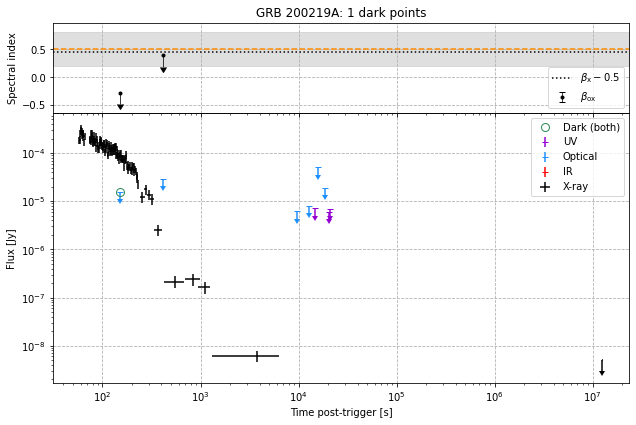

GRB    t_o       dt%  \
104  200219A  150.0  0.004870   
121  200219A  412.0  0.106046   

                                           B_ox_w_err                  B_x  \
104  -0.2738795394973301 (+0.04551266355059989, -inf)  0.96 (+0.35, -0.25)   
121    0.3930623206621587 (+0.2363715253434425, -inf)  0.96 (+0.35, -0.25)   

        α Jak_dark vdH_dark  
104  2.05     True     True  
121  5.19    False    False

1 0 0


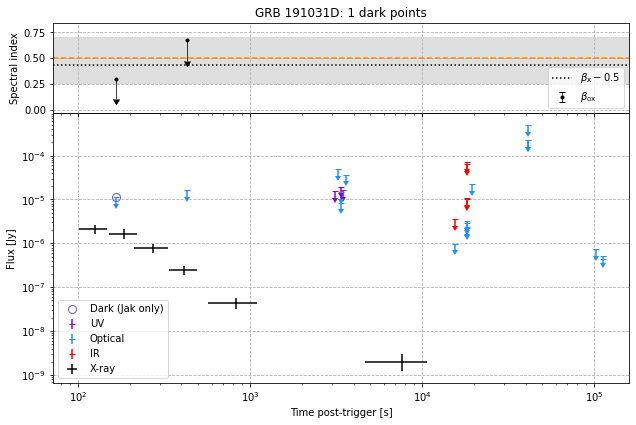

GRB    t_o       dt%  \
122  191031D  167.5  0.099559   
123  191031D  430.5  0.036059   

                                          B_ox_w_err                  B_x  \
122  0.3013995792493801 (+0.09686586908982647, -inf)  0.93 (+0.28, -0.17)   
123  0.6746782734039395 (+0.10202858622274029, -inf)  0.93 (+0.28, -0.17)   

        α Jak_dark vdH_dark  
122  1.95     True    False  
123  1.95    False    False

4 0 1


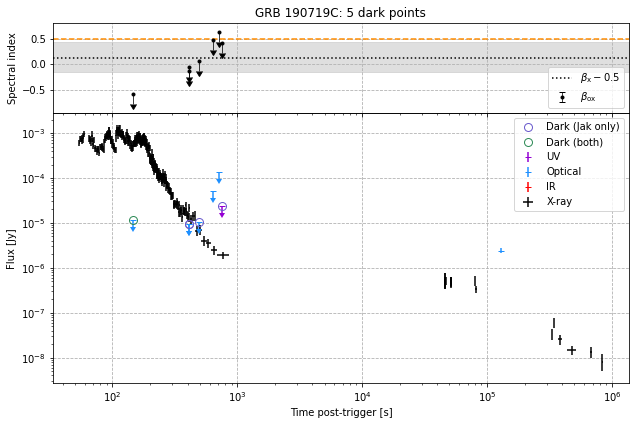

GRB    t_o       dt%  \
149  190719C  146.0  0.000404   
212  190719C  408.0  0.001813   
232  190719C  413.5  0.000571   
243  190719C  494.5  0.018019   
248  190719C  635.0  0.023853   
251  190719C  710.0  0.079953   
253  190719C  759.0  0.016457   

                                            B_ox_w_err  \
149    -0.5889694249784356 (+0.0811811972024807, -inf)   
212  -0.056611842306786134 (+0.03480549045206605, -...   
232  -0.12907305411767914 (+0.03672237773612864, -inf)   
243    0.06343831813919944 (+0.0410912542808639, -inf)   
248     0.471896797136367 (+0.07218167172967291, -inf)   
251    0.6405047267121906 (+0.09135601915920856, -inf)   
253    0.4209421685210986 (+0.06750427075516573, -inf)   

                                  B_x    α Jak_dark vdH_dark  
149  0.6299999999999999 (+0.3, -0.28)  1.0     True     True  
212  0.6299999999999999 (+0.3, -0.28)  1.0     True    False  
232  0.6299999999999999 (+0.3, -0.28)  1.0     True    False  
243  0.6299999999999999 (+0.3, -0.28)  1.0     True    False  
248  0.6299999999999999 (+0.3, -0.28)  1.0    False    False  
251  0.6299999999999999 (+0.3, -0.28)  1.0    False    False  
253  0.6299999999999999 (+0.3, -0.28)  1.0     True    False

1 0 0


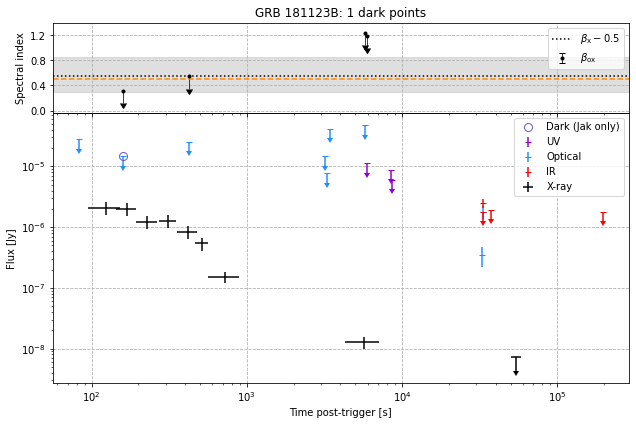

GRB     t_o       dt%  \
305  181123B   158.5  0.056227   
306  181123B   421.0  0.014967   
308  181123B  5774.0  0.017439   
309  181123B  5917.0  0.042637   

                                          B_ox_w_err  \
305  0.3172461047942834 (+0.06562468296156639, -inf)   
306  0.5489210873989546 (+0.08340075224975443, -inf)   
308  1.2412891991341262 (+0.15884182215871004, -inf)   
309  1.1960044352612713 (+0.18049580276881366, -inf)   

                                  B_x     α Jak_dark vdH_dark  
305  1.0499999999999998 (+0.3, -0.25)  1.41     True    False  
306  1.0499999999999998 (+0.3, -0.25)  1.41    False    False  
308  1.0499999999999998 (+0.3, -0.25)  1.41    False    False  
309  1.0499999999999998 (+0.3, -0.25)  1.41    False    False

1 0 0


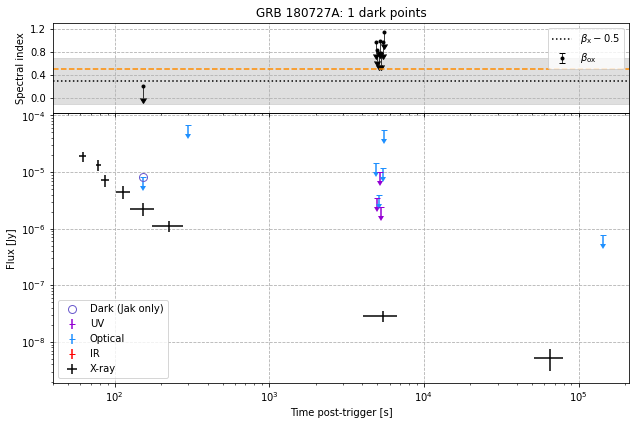

GRB     t_o       dt%  \
310  180727A   152.0  0.011286   
311  180727A  4892.5  0.094739   
312  180727A  4995.0  0.075773   
313  180727A  5097.5  0.056808   
314  180727A  5201.0  0.037657   
315  180727A  5303.5  0.018692   
316  180727A  5405.0  0.000089   
317  180727A  5501.0  0.017852   

                                           B_ox_w_err        B_x     α  \
310  0.20493517918355417 (+0.04999241805790475, -inf)  0.8 ± 0.4  1.38   
311   0.9705350869930872 (+0.14089705850990228, -inf)  0.8 ± 0.4  1.38   
312    0.8357851707828052 (+0.1337817749268779, -inf)  0.8 ± 0.4  1.38   
313   0.7797222565865061 (+0.11337834093214914, -inf)  0.8 ± 0.4  1.38   
314    0.9876889710985113 (+0.1446214718752361, -inf)  0.8 ± 0.4  1.38   
315   0.7780083241285315 (+0.12059979463992108, -inf)  0.8 ± 0.4  1.38   
316   0.9683910078866975 (+0.13417740367028747, -inf)  0.8 ± 0.4  1.38   
317   1.1417056516989406 (+0.14679112636914804, -inf)  0.8 ± 0.4  1.38   

    Jak_dark vdH_dark  
310     True    False  
311    False    False  
312    False    False  
313    False    False  
314    False    False  
315    False    False  
316    False    False  
317    False    False

0 0 1


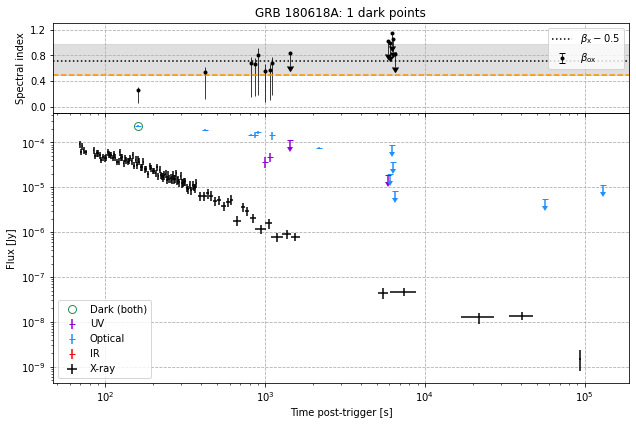

GRB     t_o       dt%  \
327  180618A   161.0  0.001487   
342  180618A   423.0  0.016343   
349  180618A   815.0  0.031596   
353  180618A   864.0  0.026627   
358  180618A   897.5  0.046156   
362  180618A  1001.0  0.048888   
365  180618A  1074.0  0.020474   
368  180618A  1112.0  0.056580   
371  180618A  1437.5  0.050929   
373  180618A  5882.5  0.071921   
374  180618A  6087.5  0.109277   
376  180618A  6190.0  0.127955   
378  180618A  6292.5  0.146632   
381  180618A  6497.5  0.124063   

                                            B_ox_w_err  \
327  0.27018177347071626 (+0.044748596060879525, -0...   
342  0.5462199361034078 (+0.0818627937857624, -0.42...   
349  0.677317056166536 (+0.09773780698132033, -0.51...   
353  0.6674828969336349 (+0.09729216604542491, -0.4...   
358  0.800724408534892 (+0.11536874054817413, -0.61...   
362  0.5563424102797698 (+0.10409478164988357, -0.4...   
365  0.5759094251223984 (+0.09770079103413999, -0.4...   
368  0.6804661264558612 (+0.10004264407911764, -0.4...   
371    0.8398757950940956 (+0.12927202054024545, -inf)   
373    1.0199452356852825 (+0.15271008584954765, -inf)   
374    0.9870282975728539 (+0.14609675880156883, -inf)   
376     1.1470094712914323 (+0.1579203445903674, -inf)   
378    1.0483195418809161 (+0.15386565599251006, -inf)   
381    0.8189779366377461 (+0.12361144056492365, -inf)   

                                   B_x    α Jak_dark vdH_dark  
327  1.2200000000000002 (+0.25, -0.23)  1.0     True     True  
342  1.2200000000000002 (+0.25, -0.23)  1.0    False    False  
349  1.2200000000000002 (+0.25, -0.23)  1.0    False    False  
353  1.2200000000000002 (+0.25, -0.23)  1.0    False    False  
358  1.2200000000000002 (+0.25, -0.23)  1.0    False    False  
362  1.2200000000000002 (+0.25, -0.23)  1.0    False    False  
365  1.2200000000000002 (+0.25, -0.23)  1.0    False    False  
368  1.2200000000000002 (+0.25, -0.23)  1.0    False    False  
371  1.2200000000000002 (+0.25, -0.23)  1.0    False    False  
373  1.2200000000000002 (+0.25, -0.23)  1.0    False    False  
374  1.2200000000000002 (+0.25, -0.23)  1.0    False    False  
376  1.2200000000000002 (+0.25, -0.23)  1.0    False    False  
378  1.2200000000000002 (+0.25, -0.23)  1.0    False    False  
381  1.2200000000000002 (+0.25, -0.23)  1.0    False    False

1 0 1


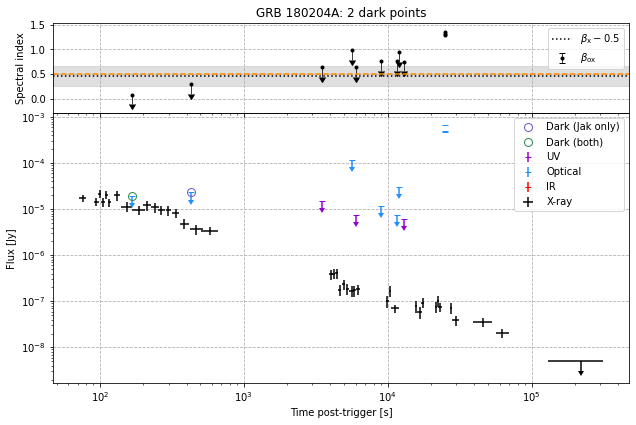

GRB      t_o       dt%  \
745  180204A    167.0  0.088473   
748  180204A    429.0  0.085590   
749  180204A   3503.5  0.133224   
753  180204A   5610.0  0.000121   
759  180204A   6075.0  0.026713   
760  180204A   8988.0  0.098983   
764  180204A  11683.0  0.032183   
766  180204A  12091.0  0.068230   
767  180204A  13045.5  0.152559   
772  180204A  25200.0  0.086293   
777  180204A  25200.0  0.086293   
782  180204A  25200.0  0.086293   

                                           B_ox_w_err                 B_x  \
745  0.08172057145899975 (+0.05496415412971789, -inf)  0.96 (+0.21, -0.2)   
748   0.2976121359239437 (+0.06691837997167112, -inf)  0.96 (+0.21, -0.2)   
749   0.6420782288764217 (+0.11787048321312481, -inf)  0.96 (+0.21, -0.2)   
753   0.9865262434120861 (+0.12962497057014724, -inf)  0.96 (+0.21, -0.2)   
759   0.6443715561357405 (+0.10348192015402807, -inf)  0.96 (+0.21, -0.2)   
760   0.7599729952378779 (+0.11709400620099102, -inf)  0.96 (+0.21, -0.2)   
764   0.7558615623967244 (+0.10708795905675003, -inf)  0.96 (+0.21, -0.2)   
766     0.943958369500233 (+0.1295769652664703, -inf)  0.96 (+0.21, -0.2)   
767   0.7522870715167811 (+0.12875003032360594, -inf)  0.96 (+0.21, -0.2)   
772                   1.3596352869760355 (+nan, -nan)  0.96 (+0.21, -0.2)   
777                   1.2938015684891093 (+nan, -nan)  0.96 (+0.21, -0.2)   
782                   1.3035755745867539 (+nan, -nan)  0.96 (+0.21, -0.2)   

         α Jak_dark vdH_dark  
745  1.073     True     True  
748  1.073     True    False  
749  1.073    False    False  
753  1.073    False    False  
759  1.073    False    False  
760  1.073    False    False  
764  1.073    False    False  
766  1.073    False    False  
767  1.073    False    False  
772  1.073    False    False  
777  1.073    False    False  
782  1.073    False    False

0 0 2


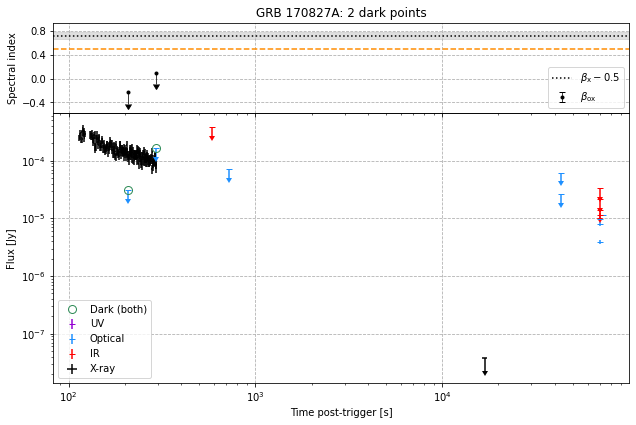

GRB    t_o       dt%  \
817  170827A  209.0  0.001620   
907  170827A  295.0  0.001141   

                                            B_ox_w_err  \
817  -0.2203397298098377 (+0.039224001726319235, -inf)   
907  0.10113836807528154 (+0.031919487075984604, -inf)   

                                   B_x     α Jak_dark vdH_dark  
817  1.2200000000000002 (+0.06, -0.05)  1.19     True     True  
907  1.2200000000000002 (+0.06, -0.05)  1.19     True     True

5 0 2


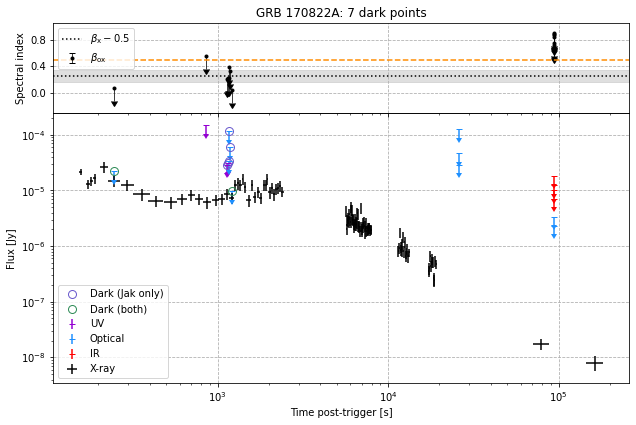

GRB      t_o       dt%  \
909  170822A    246.0  0.006438   
912  170822A    852.5  0.021796   
917  170822A   1137.5  0.001324   
925  170822A   1151.0  0.010528   
933  170822A   1162.5  0.020625   
941  170822A   1171.0  0.028088   
950  170822A   1187.0  0.017710   
958  170822A   1211.5  0.002565   
964  170822A  93294.0  0.178768   
965  170822A  93294.0  0.178768   
966  170822A  93294.0  0.178768   
967  170822A  93294.0  0.178768   
968  170822A  93294.0  0.178768   
969  170822A  93294.0  0.178768   

                                            B_ox_w_err          B_x    α  \
909   0.06632866150371261 (+0.03639487458237825, -inf)  0.75 ± 0.09  1.0   
912    0.5544462963306861 (+0.08962834553343252, -inf)  0.75 ± 0.09  1.0   
917    0.2065382858770375 (+0.04815774499357656, -inf)  0.75 ± 0.09  1.0   
925   0.22706388940018976 (+0.05233729809930151, -inf)  0.75 ± 0.09  1.0   
933   0.21899768108077097 (+0.04788721575958571, -inf)  0.75 ± 0.09  1.0   
941   0.39480341427967713 (+0.06132345443956888, -inf)  0.75 ± 0.09  1.0   
950   0.3255730795351884 (+0.055866177654593896, -inf)  0.75 ± 0.09  1.0   
958  0.04369080569880635 (+0.037141690846088274, -inf)  0.75 ± 0.09  1.0   
964     0.7260725864210473 (+0.1189246259640767, -inf)  0.75 ± 0.09  1.0   
965     0.757191589780777 (+0.11948044169878216, -inf)  0.75 ± 0.09  1.0   
966     0.8462515631805578 (+0.1257430516258267, -inf)  0.75 ± 0.09  1.0   
967    0.8776117851423296 (+0.12682754138224064, -inf)  0.75 ± 0.09  1.0   
968     0.8823887147736473 (+0.1249219067949043, -inf)  0.75 ± 0.09  1.0   
969    0.9027132829564624 (+0.12380698015314746, -inf)  0.75 ± 0.09  1.0   

    Jak_dark vdH_dark  
909     True     True  
912    False    False  
917     True    False  
925     True    False  
933     True    False  
941     True    False  
950     True    False  
958     True     True  
964    False    False  
965    False    False  
966    False    False  
967    False    False  
968    False    False  
969    False    False

16 0 15


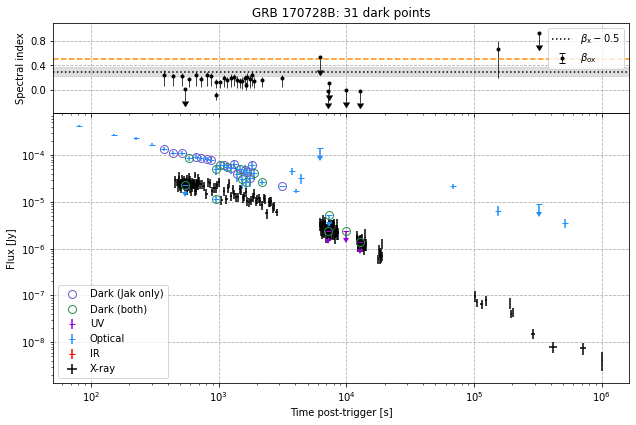

GRB         t_o       dt%  \
970   170728B     371.000  0.186497   
972   170728B     444.000  0.026427   
1009  170728B     517.000  0.001554   
1063  170728B     548.000  0.000851   
1123  170728B     589.000  0.002699   
1179  170728B     662.000  0.001591   
1216  170728B     735.000  0.002532   
1232  170728B     807.000  0.004840   
1244  170728B     880.000  0.008298   
1256  170728B     951.000  0.001066   
1268  170728B     953.000  0.003172   
1280  170728B    1026.000  0.014691   
1292  170728B    1098.000  0.000753   
1305  170728B    1171.000  0.012550   
1318  170728B    1243.000  0.007742   
1332  170728B    1316.000  0.013532   
1345  170728B    1389.000  0.013632   
1358  170728B    1462.000  0.000612   
1372  170728B    1534.000  0.006103   
1385  170728B    1607.000  0.009616   
1398  170728B    1644.500  0.006002   
1412  170728B    1680.000  0.000937   
1426  170728B    1753.000  0.003001   
1440  170728B    1825.000  0.007517   
1455  170728B    1898.000  0.004926   
1469  170728B    2190.000  0.001990   
1480  170728B    3150.000  0.101920   
1481  170728B    6244.992  0.000297   
1539  170728B    7255.000  0.001850   
1590  170728B    7285.500  0.002346   
1624  170728B    9965.000  0.154878   
1636  170728B   12764.000  0.001985   
1653  170728B  155360.160  0.192410   
1654  170728B  321670.656  0.107979   

                                             B_ox_w_err                  B_x  \
970   0.25044226441217077 (+0.06689699664090105, -0....  0.79 (+0.08, -0.07)   
972   0.22439521296238363 (+0.04201888290485343, -0....  0.79 (+0.08, -0.07)   
1009  0.2273142050325974 (+0.04208145045713396, -0.1...  0.79 (+0.08, -0.07)   
1063   0.018743704294551102 (+0.0293360417086443, -inf)  0.79 (+0.08, -0.07)   
1123  0.1781096822311161 (+0.04016795043538247, -0.1...  0.79 (+0.08, -0.07)   
1179  0.24596624607770318 (+0.04461074272014205, -0....  0.79 (+0.08, -0.07)   
1216  0.18457621386313391 (+0.044494481378185215, -0...  0.79 (+0.08, -0.07)   
1232  0.2492626079164761 (+0.04961978058602232, -0.1...  0.79 (+0.08, -0.07)   
1244  0.227566272804108 (+0.04809312171188405, -0.16...  0.79 (+0.08, -0.07)   
1256  -0.08822109794538191 (+0.04782750223789055, -0...  0.79 (+0.08, -0.07)   
1268  0.1341683621110353 (+0.05126399989145112, -0.1...  0.79 (+0.08, -0.07)   
1280  0.12217608018062213 (+0.04641735870936234, -0....  0.79 (+0.08, -0.07)   
1292  0.18804399412770334 (+0.048225762274585186, -0...  0.79 (+0.08, -0.07)   
1305  0.15557926117772217 (+0.049004795479117264, -0...  0.79 (+0.08, -0.07)   
1318  0.1997430958144993 (+0.05532042479990835, -0.1...  0.79 (+0.08, -0.07)   
1332  0.21350209354040448 (+0.052282654851322316, -0...  0.79 (+0.08, -0.07)   
1345  0.1664405712405106 (+0.06174136147455755, -0.1...  0.79 (+0.08, -0.07)   
1358  0.1426827652097761 (+0.05062247198499502, -0.1...  0.79 (+0.08, -0.07)   
1372  0.14007376539967625 (+0.06826140739792778, -0....  0.79 (+0.08, -0.07)   
1385  0.19094626069006657 (+0.05248011250666278, -0....  0.79 (+0.08, -0.07)   
1398  0.07633621631621328 (+0.05499006066929548, -0....  0.79 (+0.08, -0.07)   
1412  0.2080062878343111 (+0.06039849631156196, -0.1...  0.79 (+0.08, -0.07)   
1426  0.174845244418762 (+0.06462842414425325, -0.13...  0.79 (+0.08, -0.07)   
1440  0.24881537135764847 (+0.0528899656020569, -0.1...  0.79 (+0.08, -0.07)   
1455  0.14997811220446008 (+0.056873356845925226, -0...  0.79 (+0.08, -0.07)   
1469  0.1635409009988904 (+0.04245678763528685, -0.1...  0.79 (+0.08, -0.07)   
1480  0.19460145103402937 (+0.046015371988720334, -0...  0.79 (+0.08, -0.07)   
1481    0.5283712041396927 (+0.07190681929447125, -inf)  0.79 (+0.08, -0.07)   
1539  -0.01582405611031937 (+0.03987156245090574, -inf)  0.79 (+0.08, -0.07)   
1590   0.11631626759799985 (+0.03961845462111817, -inf)  0.79 (+0.08, -0.07)   
1624  0.0012390209473908207 (+0.0863972127521314, -inf)  0.79 (+0.08, -0.07)   
1636  -0.013787394671253103 (+0.038599033560890866, ...  0.79 (+0.08, -0.07)   
1653

1 0 0


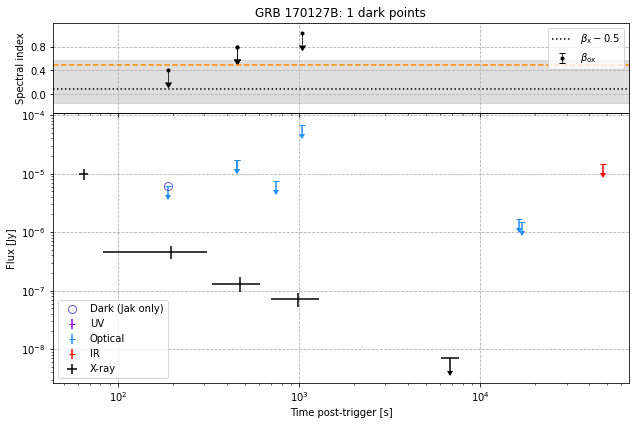

GRB     t_o       dt%  \
1661  170127B   189.0  0.033184   
1662  170127B   451.5  0.040847   
1663  170127B   451.5  0.040847   
1664  170127B  1041.5  0.051929   

                                            B_ox_w_err  \
1661  0.41573286666215475 (+0.07187030642336034, -inf)   
1662   0.7868264752086797 (+0.11860436191480121, -inf)   
1663   0.7868264752086797 (+0.11860436191480121, -inf)   
1664    1.0333784403216164 (+0.1407378826257445, -inf)   

                                    B_x    α Jak_dark vdH_dark  
1661  0.5900000000000001 (+0.48, -0.24)  1.9     True    False  
1662  0.5900000000000001 (+0.48, -0.24)  1.9    False    False  
1663  0.5900000000000001 (+0.48, -0.24)  1.9    False    False  
1664  0.5900000000000001 (+0.48, -0.24)  1.9    False    False

2 0 0


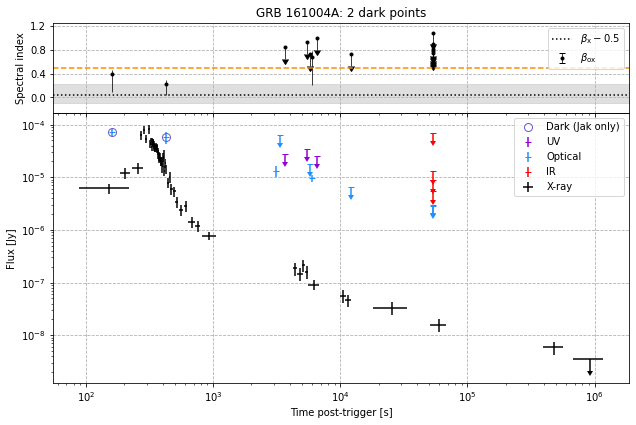

GRB        t_o       dt%  \
1665  161004A    160.000  0.049511   
1682  161004A    422.000  0.006133   
1688  161004A   3689.500  0.165222   
1691  161004A   5508.000  0.016397   
1695  161004A   5739.000  0.059024   
1699  161004A   6031.584  0.026322   
1700  161004A   6554.000  0.058012   
1702  161004A  12061.440  0.049469   
1703  161004A  53496.000  0.099868   
1704  161004A  53496.000  0.099868   
1705  161004A  53496.000  0.099868   
1706  161004A  53496.000  0.099868   
1707  161004A  53496.000  0.099868   
1708  161004A  53496.000  0.099868   

                                             B_ox_w_err                  B_x  \
1665  0.3880093011510872 (+0.06981752143036461, -0.2...  0.55 (+0.17, -0.15)   
1682  0.2271069800104917 (+0.061431669756167734, -0....  0.55 (+0.17, -0.15)   
1688     0.8473018639494653 (+0.1440953380868695, -inf)  0.55 (+0.17, -0.15)   
1691     0.9339777102208214 (+0.1423238646231631, -inf)  0.55 (+0.17, -0.15)   
1695    0.7342353790575469 (+0.10667268257281373, -inf)  0.55 (+0.17, -0.15)   
1699  0.6829336454445946 (+0.09109339737894871, -0.4...  0.55 (+0.17, -0.15)   
1700    0.9937977154246759 (+0.15110339615659701, -inf)  0.55 (+0.17, -0.15)   
1702    0.7283576529608677 (+0.09797631196783615, -inf)  0.55 (+0.17, -0.15)   
1703    0.7722063755142828 (+0.11176208336025191, -inf)  0.55 (+0.17, -0.15)   
1704    0.7424924159741795 (+0.10603918764257649, -inf)  0.55 (+0.17, -0.15)   
1705     0.8175303308371378 (+0.1114571655874065, -inf)  0.55 (+0.17, -0.15)   
1706    0.8681495766736285 (+0.11448847189271323, -inf)  0.55 (+0.17, -0.15)   
1707    0.8974337890306233 (+0.11465192731362879, -inf)  0.55 (+0.17, -0.15)   
1708    1.0867513764461323 (+0.12926224941211678, -inf)  0.55 (+0.17, -0.15)   

         α Jak_dark vdH_dark  
1665  1.04     True    False  
1682  1.04     True    False  
1688  1.04    False    False  
1691  1.04    False    False  
1695  1.04    False    False  
1699  1.04    False    False  
1700  1.04    False    False  
1702  1.04    False    False  
1703  1.04    False    False  
1704  1.04    False    False  
1705  1.04    False    False  
1706  1.04    False    False  
1707  1.04    False    False  
1708  1.04    False    False

1 0 0


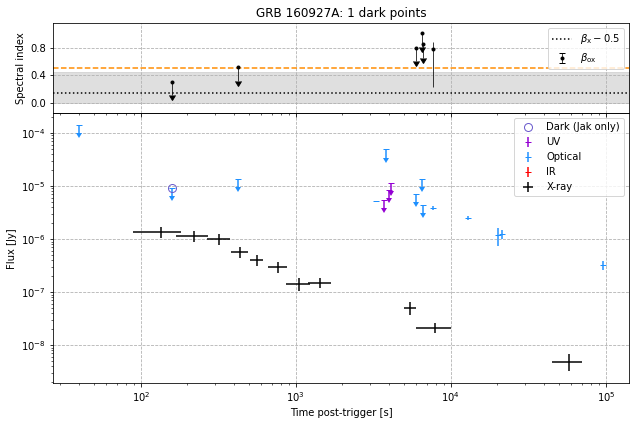

GRB     t_o       dt%  \
1713  160927A   160.0  0.186486   
1714  160927A   422.0  0.034057   
1715  160927A  5942.0  0.090128   
1717  160927A  6526.5  0.179150   
1718  160927A  6634.5  0.165566   
1719  160927A  7668.0  0.035581   

                                             B_ox_w_err  \
1713    0.3043567855111735 (+0.09307714658151692, -inf)   
1714    0.5119706378540152 (+0.07872137712422936, -inf)   
1715     0.798739553897037 (+0.12128864425471843, -inf)   
1717     1.0063520146383453 (+0.1526769050409731, -inf)   
1718    0.8486969497498111 (+0.13487195914901204, -inf)   
1719  0.7731784924860126 (+0.10199340349470369, -0.5...   

                                   B_x     α Jak_dark vdH_dark  
1713  0.6399999999999999 (+0.3, -0.14)  1.02     True    False  
1714  0.6399999999999999 (+0.3, -0.14)  1.02    False    False  
1715  0.6399999999999999 (+0.3, -0.14)  1.02    False    False  
1717  0.6399999999999999 (+0.3, -0.14)  1.02    False    False  
1718  0.6399999999999999 (+0.3, -0.14)  1.02    False    False  
1719  0.6399999999999999 (+0.3, -0.14)  1.02    False    False

1 0 3


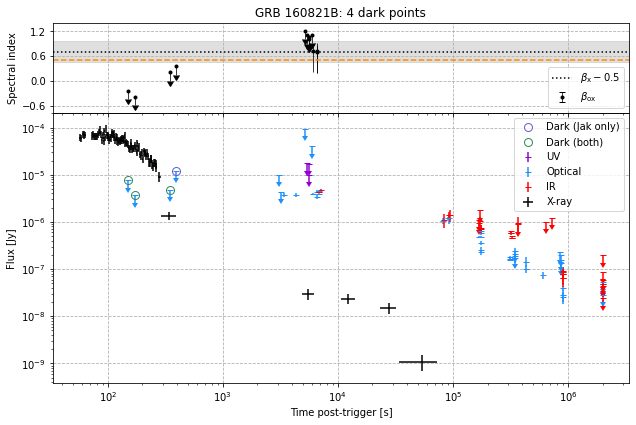

GRB     t_o       dt%  \
1732  160821B   151.0  0.006749   
1755  160821B   172.8  0.006823   
1768  160821B   345.6  0.013968   
1769  160821B   394.5  0.157438   
1770  160821B  5180.0  0.066369   
1771  160821B  5385.0  0.029421   
1772  160821B  5591.0  0.007708   
1773  160821B  5657.0  0.019604   
1774  160821B  6001.0  0.081606   
1775  160821B  6048.0  0.090077   
1776  160821B  6566.4  0.183512   
1777  160821B  6588.0  0.187405   

                                             B_ox_w_err  \
1732  -0.24751830582012946 (+0.04262286347909809, -inf)   
1755  -0.38915644423672874 (+0.058699086962216276, -...   
1768   0.20504740497975443 (+0.04286303429745854, -inf)   
1769   0.35364396325784125 (+0.14527064340318116, -inf)   
1770     1.2146676997941956 (+0.1675261705503998, -inf)   
1771     1.1042728740123586 (+0.1676601540688427, -inf)   
1772     1.067672678434761 (+0.15582804961585944, -inf)   
1773      1.02165646869779 (+0.15719606617208984, -inf)   
1774      1.121564109014966 (+0.1669021590624872, -inf)   
1775  0.7211540772861706 (+0.12523509619105466, -0.5...   
1776  0.6965031238722958 (+0.18105677167979525, -0.5...   
1777  0.7331385415285029 (+0.18541600964331537, -0.5...   

                                    B_x     α Jak_dark vdH_dark  
1732  1.2000000000000002 (+0.28, -0.24)  2.11     True     True  
1755  1.2000000000000002 (+0.28, -0.24)  2.11     True     True  
1768  1.2000000000000002 (+0.28, -0.24)  2.11     True     True  
1769  1.2000000000000002 (+0.28, -0.24)  2.11     True    False  
1770  1.2000000000000002 (+0.28, -0.24)  2.11    False    False  
1771  1.2000000000000002 (+0.28, -0.24)  2.11    False    False  
1772  1.2000000000000002 (+0.28, -0.24)  2.11    False    False  
1773  1.2000000000000002 (+0.28, -0.24)  2.11    False    False  
1774  1.2000000000000002 (+0.28, -0.24)  2.11    False    False  
1775  1.2000000000000002 (+0.28, -0.24)  2.11    False    False  
1776  1.2000000000000002 (+0.28, -0.24)  2.11    False    False  
1777  1.2000000000000002 (+0.28, -0.24)  2.11    False    False

2 0 0


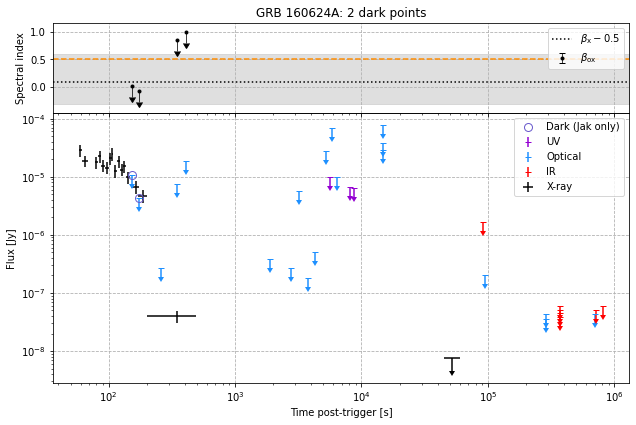

GRB    t_o       dt%  \
1779  160624A  152.0  0.066876   
1782  160624A  172.8  0.058227   
1784  160624A  345.6  0.001057   
1785  160624A  408.0  0.181804   

                                             B_ox_w_err  \
1779  0.016029122534107675 (+0.11115362302302455, -inf)   
1782   -0.07121833377450948 (+0.1012355407851191, -inf)   
1784     0.8446025265261515 (+0.1184751564900034, -inf)   
1785    0.9931990848042384 (+0.30414961028143517, -inf)   

                                  B_x     α Jak_dark vdH_dark  
1779  0.6000000000000001 (+0.5, -0.4)  3.74     True    False  
1782  0.6000000000000001 (+0.5, -0.4)  3.74     True    False  
1784  0.6000000000000001 (+0.5, -0.4)  3.74    False    False  
1785  0.6000000000000001 (+0.5, -0.4)  3.74    False    False

1 0 0


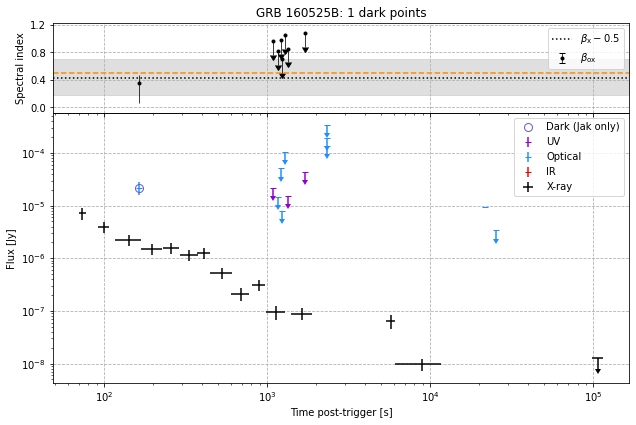

GRB     t_o       dt%  \
1788  160525B   163.0  0.147346   
1790  160525B  1089.5  0.042582   
1791  160525B  1159.0  0.018492   
1792  160525B  1213.0  0.065945   
1793  160525B  1237.5  0.087475   
1794  160525B  1288.0  0.131853   
1795  160525B  1338.0  0.175791   
1797  160525B  1699.0  0.033456   

                                             B_ox_w_err                  B_x  \
1788  0.3610739023388736 (+0.11017183909020013, -0.2...  0.93 (+0.27, -0.25)   
1790     0.9598085722444535 (+0.1505824681624388, -inf)  0.93 (+0.27, -0.25)   
1791    0.8143470698290319 (+0.11839210478964385, -inf)  0.93 (+0.27, -0.25)   
1792     0.9806204332284915 (+0.1393219176331166, -inf)  0.93 (+0.27, -0.25)   
1793     0.7016803005209801 (+0.1140647789965363, -inf)  0.93 (+0.27, -0.25)   
1794    1.0553819432716813 (+0.15683502083892772, -inf)  0.93 (+0.27, -0.25)   
1795    0.8554296117309526 (+0.16068101171700047, -inf)  0.93 (+0.27, -0.25)   
1797     1.0756229807785804 (+0.1617684866363984, -inf)  0.93 (+0.27, -0.25)   

         α Jak_dark vdH_dark  
1788  1.37     True    False  
1790  1.37    False    False  
1791  1.37    False    False  
1792  1.37    False    False  
1793  1.37    False    False  
1794  1.37    False    False  
1795  1.37    False    False  
1797  1.37    False    False

1 0 0


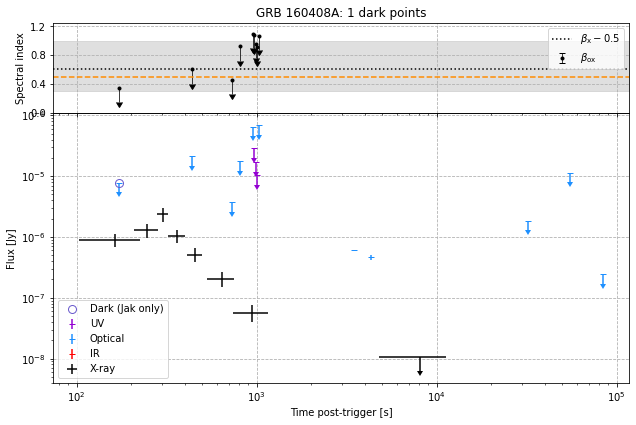

GRB     t_o       dt%  \
1807  160408A   173.0  0.054962   
1808  160408A   436.0  0.041864   
1809  160408A   731.5  0.138956   
1810  160408A   813.5  0.143116   
1811  160408A   953.0  0.003824   
1812  160408A   965.0  0.016464   
1813  160408A   991.0  0.043850   
1814  160408A  1003.5  0.057017   
1815  160408A  1027.5  0.082297   

                                            B_ox_w_err               B_x    α  \
1807  0.34126947057766777 (+0.07021671202580733, -inf)  1.1 (+0.4, -0.3)  1.6   
1808   0.5993653899235445 (+0.09371923045970519, -inf)  1.1 (+0.4, -0.3)  1.6   
1809   0.4573872007139887 (+0.11687892821479748, -inf)  1.1 (+0.4, -0.3)  1.6   
1810     0.923676687657931 (+0.1616111918922529, -inf)  1.1 (+0.4, -0.3)  1.6   
1811   1.0987643700872323 (+0.14916506024123694, -inf)  1.1 (+0.4, -0.3)  1.6   
1812   1.0815420104347433 (+0.16431121885624947, -inf)  1.1 (+0.4, -0.3)  1.6   
1813   0.9587096886990327 (+0.14590892958416357, -inf)  1.1 (+0.4, -0.3)  1.6   
1814   0.9147261680070717 (+0.14828830532504972, -inf)  1.1 (+0.4, -0.3)  1.6   
1815    1.0699514831396904 (+0.1511419161158295, -inf)  1.1 (+0.4, -0.3)  1.6   

     Jak_dark vdH_dark  
1807     True    False  
1808    False    False  
1809    False    False  
1810    False    False  
1811    False    False  
1812    False    False  
1813    False    False  
1814    False    False  
1815    False    False

1 0 2


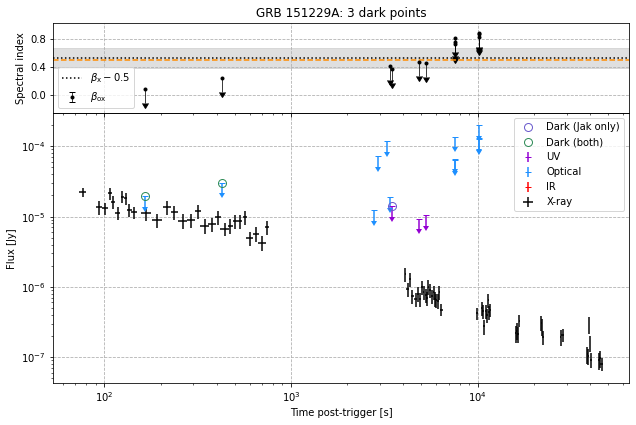

GRB        t_o       dt%  \
1818  151229A    165.000  0.009318   
1822  151229A    427.000  0.031102   
1825  151229A   3407.500  0.168752   
1827  151229A   3497.500  0.146797   
1836  151229A   4881.500  0.003939   
1853  151229A   5291.000  0.004618   
1864  151229A   7533.000  0.180161   
1865  151229A   7533.000  0.180161   
1866  151229A   7533.000  0.180161   
1867  151229A  10172.736  0.025007   
1876  151229A  10172.736  0.025007   
1885  151229A  10172.736  0.025007   

                                             B_ox_w_err  \
1818  0.08551899905655155 (+0.037419935813015996, -inf)   
1822   0.24419921461541721 (+0.04852536123990434, -inf)   
1825    0.4086672961149249 (+0.09212008493579942, -inf)   
1827   0.37349966154078273 (+0.08609566500155641, -inf)   
1836    0.4644253910788264 (+0.07901553636449099, -inf)   
1853   0.45347093026506646 (+0.07657326735382841, -inf)   
1864    0.7537089712252784 (+0.12127242262384737, -inf)   
1865     0.727255869015611 (+0.11494543007793026, -inf)   
1866    0.8103979885216062 (+0.12056411884043737, -inf)   
1867    0.8838078505832655 (+0.11700752605861213, -inf)   
1876     0.8377419247366604 (+0.1062074674067628, -inf)   
1885    0.8783879825971102 (+0.10793835880098036, -inf)   

                            B_x      α Jak_dark vdH_dark  
1818  1.0299999999999998 ± 0.14  0.497     True     True  
1822  1.0299999999999998 ± 0.14  0.497     True     True  
1825  1.0299999999999998 ± 0.14  0.950    False    False  
1827  1.0299999999999998 ± 0.14  0.950     True    False  
1836  1.0299999999999998 ± 0.14  0.950    False    False  
1853  1.0299999999999998 ± 0.14  0.950    False    False  
1864  1.0299999999999998 ± 0.14  0.950    False    False  
1865  1.0299999999999998 ± 0.14  0.950    False    False  
1866  1.0299999999999998 ± 0.14  0.950    False    False  
1867  1.0299999999999998 ± 0.14  0.950    False    False  
1876  1.0299999999999998 ± 0.14  0.950    False    False  
1885  1.0299999999999998 ± 0.14  0.950    False    False

1 0 0


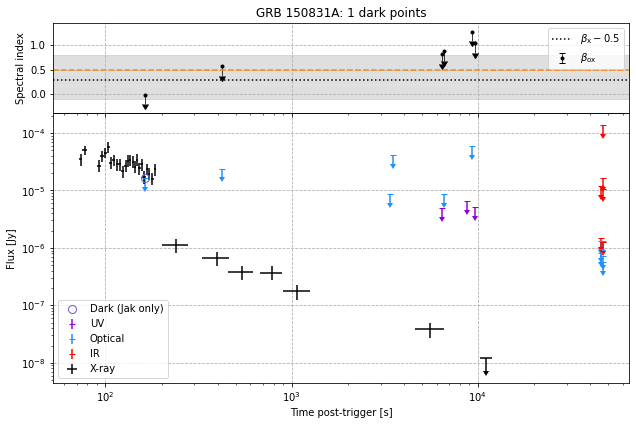

GRB     t_o       dt%  \
1903  150831A   163.0  0.010470   
1908  150831A   425.0  0.072331   
1909  150831A  6396.0  0.150285   
1910  150831A  6542.0  0.176542   
1911  150831A  9258.0  0.167377   
1912  150831A  9592.0  0.137338   

                                             B_ox_w_err               B_x  \
1903  -0.00714602404155144 (+0.038790906752000344, -...  0.8 (+0.5, -0.4)   
1908    0.5787249385195573 (+0.09500633572598878, -inf)  0.8 (+0.5, -0.4)   
1909    0.8181188963369559 (+0.14283691255254122, -inf)  0.8 (+0.5, -0.4)   
1910     0.8761056081892415 (+0.1504578129109857, -inf)  0.8 (+0.5, -0.4)   
1911                           1.2786849871608272 ± inf  0.8 (+0.5, -0.4)   
1912                           1.0501271864637942 ± inf  0.8 (+0.5, -0.4)   

         α Jak_dark vdH_dark  
1903  1.18     True    False  
1908  1.18    False    False  
1909  1.18    False    False  
1910  1.18    False    False  
1911  1.18    False    False  
1912  1.18    False    False

2 0 4


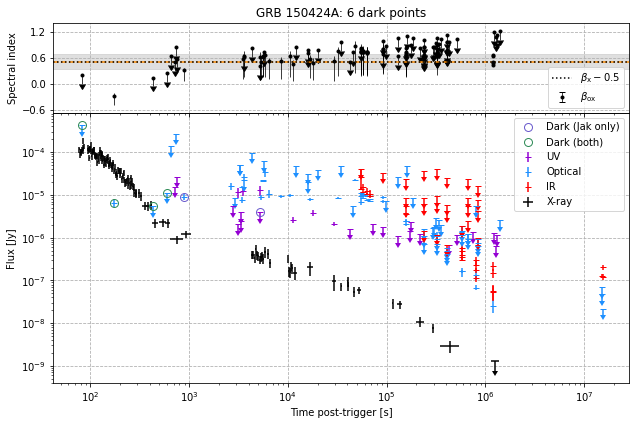

GRB          t_o       dt%  \
1917  150424A       82.000  0.006095   
1943  150424A      174.000  0.002791   
1958  150424A      436.000  0.038665   
1961  150424A      601.000  0.010159   
1962  150424A      664.000  0.093602   
...       ...          ...       ...   
2186  150424A  1206264.096  0.038335   
2187  150424A  1224527.000  0.023775   
2188  150424A  1295417.000  0.032740   
2189  150424A  1310529.000  0.044788   
2190  150424A  1394595.000  0.111807   

                                             B_ox_w_err                  B_x  \
1917   0.2015741817773901 (+0.035108501717430796, -inf)  1.02 (+0.18, -0.17)   
1943  -0.27448807935892167 (+0.055530401460026926, -...  1.02 (+0.18, -0.17)   
1958     0.14382370926139018 (+0.059709905069334, -inf)  1.02 (+0.18, -0.17)   
1961   0.25717748383674716 (+0.05148722044503181, -inf)  1.02 (+0.18, -0.17)   
1962    0.6418120335104655 (+0.09461724595459572, -inf)  1.02 (+0.18, -0.17)   
...                                                 ...                  ...   
2186    0.4877564949109078 (+inf, -0.30963385908012864)  1.02 (+0.18, -0.17)   
2187                           1.2025261435848176 ± inf  1.02 (+0.18, -0.17)   
2188                           1.0901029204818726 ± inf  1.02 (+0.18, -0.17)   
2189                           1.1442678984731742 ± inf  1.02 (+0.18, -0.17)   
2190                           1.2284152302437121 ± inf  1.02 (+0.18, -0.17)   

         α Jak_dark vdH_dark  
1917  1.00     True     True  
1943  2.57     True     True  
1958  2.57     True     True  
1961  2.57     True     True  
1962  0.71    False    False  
...    ...      ...      ...  
2186  1.70    False    False  
2187  1.70    False    False  
2188  1.70    False    False  
2189  1.70    False    False  
2190  1.70    False    False  

[107 rows x 8 columns]

0 0 1


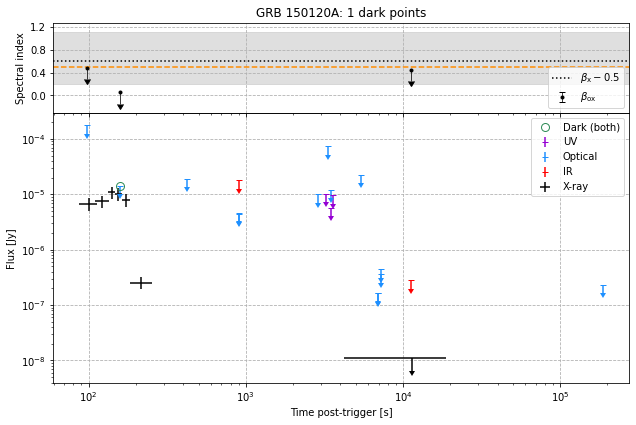

GRB      t_o       dt%  \
2203  150120A     98.0  0.020421   
2206  150120A    158.0  0.022462   
2208  150120A  11232.0  0.020604   

                                           B_ox_w_err               B_x     α  \
2203   0.479977255044103 (+0.07941447192576484, -inf)  1.1 (+0.5, -0.4)  4.38   
2206  0.05687691449590588 (+0.0586804064924505, -inf)  1.1 (+0.5, -0.4)  4.38   
2208                        0.45027988961062976 ± inf  1.1 (+0.5, -0.4)  4.38   

     Jak_dark vdH_dark  
2203    False    False  
2206     True     True  
2208    False    False

1 0 0


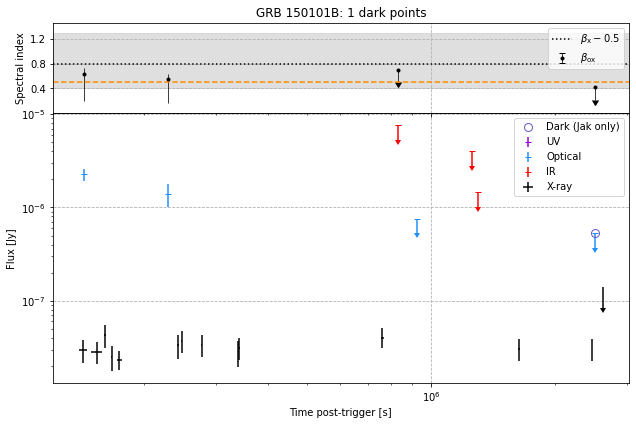

GRB        t_o       dt%  \
2209  150101B   143280.0  0.005732   
2214  150101B   228960.0  0.055246   
2217  150101B   831600.0  0.093281   
2218  150101B  2498400.0  0.013928   

                                             B_ox_w_err  \
2209  0.6339747633202867 (+0.08915637736992384, -0.4...   
2214  0.5473913248082393 (+0.09112501007166433, -0.3...   
2217    0.6994143541072634 (+0.09175470795474887, -inf)   
2218    0.4183698806220629 (+0.06387739068269137, -inf)   

                                  B_x    α Jak_dark vdH_dark  
2209  1.2999999999999998 (+0.5, -0.4)  1.0    False    False  
2214  1.2999999999999998 (+0.5, -0.4)  1.0    False    False  
2217  1.2999999999999998 (+0.5, -0.4)  1.0    False    False  
2218  1.2999999999999998 (+0.5, -0.4)  1.0     True    False

1 0 0


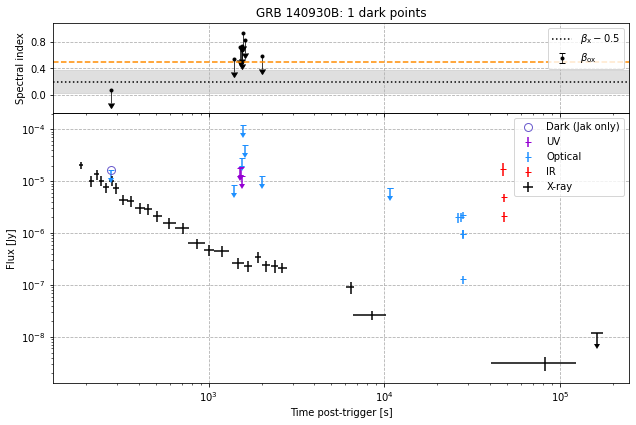

GRB     t_o       dt%  \
2229  140930B   276.0  0.014074   
2233  140930B  1390.0  0.058011   
2235  140930B  1505.5  0.020262   
2237  140930B  1530.5  0.037205   
2240  140930B  1544.0  0.046353   
2243  140930B  1554.5  0.053469   
2247  140930B  1568.0  0.059726   
2250  140930B  1610.0  0.034540   
2253  140930B  2022.0  0.046194   

                                            B_ox_w_err                  B_x  \
2229  0.0715626635639951 (+0.038461031940199515, -inf)  0.69 (+0.18, -0.16)   
2233   0.5481983614433009 (+0.09158713095362558, -inf)  0.69 (+0.18, -0.16)   
2235   0.7324498940525461 (+0.11400294699064774, -inf)  0.69 (+0.18, -0.16)   
2237   0.7133600815291702 (+0.11061259019062646, -inf)  0.69 (+0.18, -0.16)   
2240   0.6747013451038738 (+0.11202262629435358, -inf)  0.69 (+0.18, -0.16)   
2243   0.7485076014419401 (+0.11381619833576342, -inf)  0.69 (+0.18, -0.16)   
2247    0.940398850877426 (+0.13026179788056905, -inf)  0.69 (+0.18, -0.16)   
2250   0.8354381242473943 (+0.11683139642648652, -inf)  0.69 (+0.18, -0.16)   
2253    0.583720111315267 (+0.08588244609846378, -inf)  0.69 (+0.18, -0.16)   

         α Jak_dark vdH_dark  
2229  1.74     True    False  
2233  1.74    False    False  
2235  1.74    False    False  
2237  1.74    False    False  
2240  1.74    False    False  
2243  1.74    False    False  
2247  1.74    False    False  
2250  1.74    False    False  
2253  1.74    False    False

1 0 0


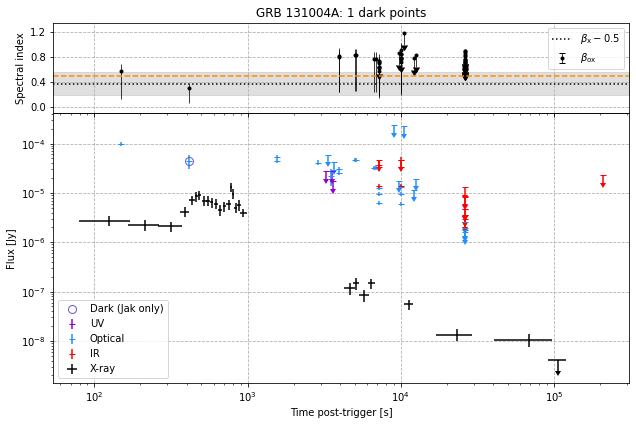

GRB      t_o       dt%  \
2309  131004A    150.0  0.199185   
2311  131004A    412.5  0.051755   
2314  131004A   3960.0  0.147661   
2315  131004A   3960.0  0.147661   
2317  131004A   5040.0  0.013325   
2320  131004A   5106.0  0.000405   
2323  131004A   6678.0  0.041696   
2325  131004A   6840.0  0.066966   
2326  131004A   7200.0  0.123122   
2327  131004A   7200.0  0.123122   
2328  131004A   7200.0  0.123122   
2329  131004A   7200.0  0.123122   
2330  131004A   7200.0  0.123122   
2331  131004A   7200.0  0.123122   
2332  131004A   7200.0  0.123122   
2333  131004A   9720.0  0.138666   
2334  131004A  10080.0  0.106765   
2335  131004A  10080.0  0.106765   
2336  131004A  10080.0  0.106765   
2337  131004A  10080.0  0.106765   
2338  131004A  10080.0  0.106765   
2339  131004A  10080.0  0.106765   
2340  131004A  10080.0  0.106765   
2341  131004A  10440.0  0.074864   
2342  131004A  12240.0  0.084643   
2343  131004A  12600.0  0.116544   
2344  131004A  26208.0  0.134530   
2345  131004A  26208.0  0.134530   
2346  131004A  26208.0  0.134530   
2347  131004A  26208.0  0.134530   
2348  131004A  26208.0  0.134530   
2349  131004A  26208.0  0.134530   
2350  131004A  26280.0  0.137647   
2351  131004A  26280.0  0.137647   
2352  131004A  26280.0  0.137647   
2353  131004A  26280.0  0.137647   
2354  131004A  26280.0  0.137647   
2355  131004A  26280.0  0.137647   

                                             B_ox_w_err  \
2309  0.5701365911293371 (+0.11406334761440731, -0.4...   
2311  0.2949948485695837 (+0.07605737220324377, -0.2...   
2314  0.818994263043481 (+0.12261997073581882, -0.57...   
2315  0.7934819335542955 (+0.12022341493557644, -0.5...   
2317  0.8237025009811004 (+0.10575414404273545, -0.5...   
2320  0.8235804165812407 (+0.10591618289470928, -0.5...   
2323  0.7719516163975538 (+0.0993390138694306, -0.53...   
2325  0.7723064082520155 (+0.10135117998383049, -0.5...   
2326  0.5786442459953199 (+0.09633431303737088, -0.4...   
2327  0.6180802015528337 (+0.09687324366469663, -0.4...   
2328  0.6393739341257555 (+0.09656749524569139, -0.4...   
2329  0.6366754555575301 (+0.09471102343261567, -0.4...   
2330  0.7399796709917466 (+0.10313598268681809, -0.4...   
2331  0.7032153132918811 (+0.09709886432752067, -0.4...   
2332    0.7200410717469378 (+0.09314300146763566, -inf)   
2333      0.8677972431663711 (+0.125553742818277, -inf)   
2334  0.7207391325921417 (+0.10754831142618534, -0.5...   
2335  0.7619230866559398 (+0.10830463404247268, -0.5...   
2336  0.7841812637544955 (+0.10794186281829476, -0.5...   
2337  0.7737914573085923 (+0.10464719214231306, -0.5...   
2338  0.9029975352918039 (+0.1146997805851153, -0.58...   
2339  0.8367016326428296 (+0.10703154829183413, -0.5...   
2340     0.8416085610066762 (+0.1004330339388944, -inf)   
2341    1.1831497454046538 (+0.14602966370836293, -inf)   
2342    0.7858856878111916 (+0.10644932938311347, -inf)   
2343    0.8339687250793366 (+0.11302998421824509, -inf)   
2344    0.7239667887278759 (+0.11088603775010324, -inf)   
2345     0.756736641505164 (+0.11152158802827916, -inf)   
2346    0.8260876465018508 (+0.11622290164553083, -inf)   
2347    0.8881387711510972 (+0.12025552054883985, -inf)   
2348    0.8602349973237662 (+0.11508493771866592, -inf)   
2349    0.8888508128466672 (+0.11459012427263181, -inf)   
2350    0.7057022934550411 (+0.10949723213252094, -inf)   
2351    0.7090663220232315 (+0.10733216280864039, -inf)   
2352    0.7554371348152611 (+0.11011192015364271, -inf)   
2353    0.8112216320773077 (+0.11371707056042098, -inf)   
2354    0.7486541103991339 (+0.10560248616554775, -inf)   
2355     0.7226623280122498 (+0.1007734230713053, -inf)   

                                    B_x     α Jak_dark vdH_dark  
2309  0.8700000000000001 (+0.19, -0.18)  0.97    False    False  
2311  0.8700000000000001 (+0.19, -0.18)  0.97     True    False  
2314  0.8700000000000001 (+0.19, -0.18)  0.97    False    False  
2315  0.8700000000000001 (+0.19, -0.18)

6 0 0


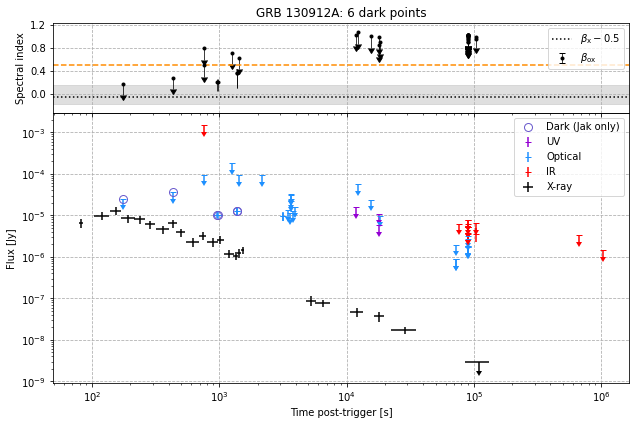

GRB       t_o       dt%  \
2357  130912A     174.0  0.097581   
2358  130912A     436.0  0.014383   
2360  130912A     756.0  0.021285   
2362  130912A     756.0  0.021285   
2365  130912A     960.0  0.055932   
2367  130912A     972.0  0.044131   
2369  130912A    1260.0  0.048603   
2374  130912A    1368.0  0.018486   
2378  130912A    1380.0  0.027420   
2383  130912A    1440.0  0.006277   
2385  130912A   11843.0  0.016180   
2386  130912A   12312.0  0.022781   
2387  130912A   15518.0  0.138390   
2388  130912A   17835.5  0.009715   
2389  130912A   18099.0  0.004916   
2390  130912A   18273.5  0.014604   
2391  130912A   89280.0  0.180952   
2392  130912A   89280.0  0.180952   
2393  130912A   89280.0  0.180952   
2394  130912A   89280.0  0.180952   
2395  130912A   89280.0  0.180952   
2396  130912A   89280.0  0.180952   
2397  130912A   89442.0  0.179466   
2398  130912A   89442.0  0.179466   
2399  130912A   89442.0  0.179466   
2400  130912A   89442.0  0.179466   
2401  130912A   89442.0  0.179466   
2402  130912A   89442.0  0.179466   
2403  130912A   89856.0  0.175668   
2404  130912A   89856.0  0.175668   
2405  130912A   89856.0  0.175668   
2406  130912A  103680.0  0.048848   
2407  130912A  103680.0  0.048848   

                                             B_ox_w_err  \
2357   0.17469806075059513 (+0.04296237884195829, -inf)   
2358   0.27710995138531946 (+0.05124674465275889, -inf)   
2360     0.498403604536854 (+0.07107055889575084, -inf)   
2362    0.7910022730423077 (+0.09062556916625857, -inf)   
2365  0.20673641485801725 (+0.061087462688075155, -0...   
2367  0.20607087206569014 (+0.05833002401703142, -0....   
2369     0.7125898447058443 (+0.0949311375006642, -inf)   
2374  0.36902922012024353 (+0.0646362100262244, -0.2...   
2378  0.3660680269309475 (+0.06461608223225399, -0.2...   
2383    0.6331371850569513 (+0.08372954775774044, -inf)   
2385    1.0262458751785455 (+0.15592848487092512, -inf)   
2386    1.0726813334922514 (+0.13952511163954928, -inf)   
2387    1.0080624898441168 (+0.15905519977008806, -inf)   
2388    0.9868826724602745 (+0.14892229377503743, -inf)   
2389    0.8500057740964203 (+0.12627298568899908, -inf)   
2390    0.8998651238423977 (+0.12730931322520947, -inf)   
2391                            0.943795038246798 ± inf   
2392                           0.9071824200824065 ± inf   
2393                           0.9997913382877329 ± inf   
2394                            1.033748349035115 ± inf   
2395                           1.0006212504628436 ± inf   
2396                           1.0174941064907135 ± inf   
2397                           0.9478678456711476 ± inf   
2398                            0.910581913979418 ± inf   
2399                           0.9973131927875805 ± inf   
2400                           1.0279997349045287 ± inf   
2401                             1.00003721354338 ± inf   
2402                           1.0203789973484438 ± inf   
2403                           1.0283035393026794 ± inf   
2404                            0.975438200435569 ± inf   
2405                            1.024730150773578 ± inf   
2406      0.949950105198353 (+inf, -0.6103666594625996)   
2407                           0.9922238075116937 ± inf   

                                    B_x      α Jak_dark vdH_dark  
2357  0.4399999999999999 (+0.21, -0.11)  0.270     True    False  
2358  0.4399999999999999 (+0.21, -0.11)  1.463     True    False  
2360  0.4399999999999999 (+0.21, -0.11)  1.463    False    False  
2362  0.4399999999999999 (+0.21, -0.11)  1.463    False    False  
2365  0.4399999999999999 (+0.21, -0.11)  1.463     True    False  
2367  0.4399999999999999 (+0.21, -0.11)  1.463     True    False  
2369  0.4399999999999999 (+0.21, -0.11)  1.463    False    False  
2374  0.4399999999999999 (+0.21, -0.11)  1.463     True    False  
2378  0.4399999999999999 (+0.21, -0.11)  1.463     True    False  
2383  0.4399999999999999 (+0.21, -0.11)  1.463    False    False  
2385  0

3 0 1


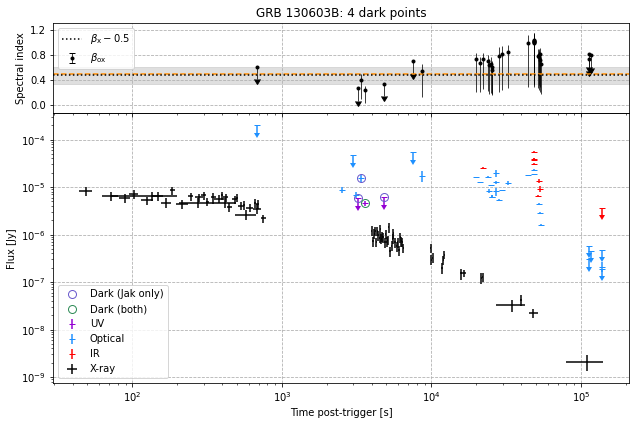

GRB       t_o       dt%  \
2413  130603B     684.0  0.002010   
2416  130603B    3228.0  0.192008   
2417  130603B    3371.0  0.156214   
2421  130603B    3567.5  0.107029   
2439  130603B    4778.5  0.003995   
2453  130603B    7560.0  0.166473   
2454  130603B    8640.0  0.122872   
2457  130603B   19966.0  0.071671   
2459  130603B   21240.0  0.012436   
2462  130603B   21960.0  0.000325   
2464  130603B   23760.0  0.081616   
2466  130603B   24120.0  0.098004   
2468  130603B   25200.0  0.147168   
2470  130603B   25560.0  0.163556   
2472  130603B   25560.0  0.163556   
2473  130603B   28440.0  0.182735   
2474  130603B   29520.0  0.151699   
2475  130603B   32400.0  0.068938   
2478  130603B   43920.0  0.086440   
2479  130603B   48222.0  0.003044   
2480  130603B   48222.0  0.003044   
2481  130603B   48222.0  0.003044   
2482  130603B   48222.0  0.003044   
2483  130603B   48222.0  0.003044   
2484  130603B   48222.0  0.003044   
2485  130603B   51840.0  0.078301   
2486  130603B   52200.0  0.085789   
2487  130603B   52560.0  0.093277   
2488  130603B   52920.0  0.100765   
2489  130603B   53280.0  0.108254   
2490  130603B   54000.0  0.123230   
2491  130603B  112320.0  0.022837   
2492  130603B  112320.0  0.022837   
2493  130603B  115920.0  0.055620   

                                             B_ox_w_err                  B_x  \
2413    0.6078781263385069 (+0.08355372447295904, -inf)  0.97 (+0.14, -0.13)   
2416   0.26394949664177414 (+0.09270423714248009, -inf)  0.97 (+0.14, -0.13)   
2417  0.3960732673214488 (+0.09202276246160318, -0.3...  0.97 (+0.14, -0.13)   
2421  0.23472142341616253 (+0.07196853096636335, -0....  0.97 (+0.14, -0.13)   
2439    0.3388014195293753 (+0.06297704697217059, -inf)  0.97 (+0.14, -0.13)   
2453    0.6998160746654591 (+0.11489984391839136, -inf)  0.97 (+0.14, -0.13)   
2454  0.5438911622301633 (+0.10182022839295, -0.4111...  0.97 (+0.14, -0.13)   
2457  0.7240281151065281 (+0.10125926241914775, -0.5...  0.97 (+0.14, -0.13)   
2459  0.6749244162748006 (+0.09023153270581252, -0.4...  0.97 (+0.14, -0.13)   
2462  0.733617343661548 (+0.08992005192332252, -0.48...  0.97 (+0.14, -0.13)   
2464  0.6962934580612733 (+0.09519952753985106, -0.4...  0.97 (+0.14, -0.13)   
2466  0.6307979253794036 (+0.09579595077918603, -0.4...  0.97 (+0.14, -0.13)   
2468  0.6563200783582868 (+0.10504443316761983, -0.4...  0.97 (+0.14, -0.13)   
2470  0.5597621866874678 (+0.09917280626187328, -0.3...  0.97 (+0.14, -0.13)   
2472  0.5988969569354411 (+0.10659137357029777, -0.4...  0.97 (+0.14, -0.13)   
2473  0.7848700359066813 (+0.13057452516789403, -0.5...  0.97 (+0.14, -0.13)   
2474  0.8170568987176035 (+0.12290305777781196, -0.5...  0.97 (+0.14, -0.13)   
2475  0.8495881373526624 (+0.11232269034674307, -0.5...  0.97 (+0.14, -0.13)   
2478  0.9882600946421588 (+0.1305096009476505, -0.69...  0.97 (+0.14, -0.13)   
2479  0.9929427727910082 (+0.12630435934017228, -0.7...  0.97 (+0.14, -0.13)   
2480  0.9967923134119577 (+0.12306521265262474, -0.6...  0.97 (+0.14, -0.13)   
2481  1.015606535995575 (+0.12261105318316584, -0.68...  0.97 (+0.14, -0.13)   
2482  1.027401035754334 (+0.1214338295386464, -0.676...  0.97 (+0.14, -0.13)   
2483  0.9953294612075222 (+0.11481899355904215, -0.6...  0.97 (+0.14, -0.13)   
2484  1.0114406539775094 (+0.11262294905834268, -0.6...  0.97 (+0.14, -0.13)   
2485  0.78517069178922 (+0.10104090058829607, -0.521...  0.97 (+0.14, -0.13)   
2486  0.7981488637810475 (+0.09484883820105608, -0.4...  0.97 (+0.14, -0.13)   
2487  0.75729687839666 (+0.10305064034430474, -0.519...  0.97 (+0.14, -0.13)   
2488  0.8066982658750247 (+0.10501251124397502, -0.5...  0.97 (+0.14, -0.13)   
2489  0.7163490752273707 (+0.10392007083467034, -0.5...  0.97 (+0.14, -0.13)   
2490  0.655956846421642 (+0.10396813995947965, -0.48...  0.97 (+0.14, -0.13)   
2491    0.7341276574976692 (+0.10296883918066316, -inf)  0.97 (+0.14, -0.13)   
2492    0.8064711787908835 (+0.10743470387894533, -inf)  0.97 (+0.14, -0.1

0 0 1


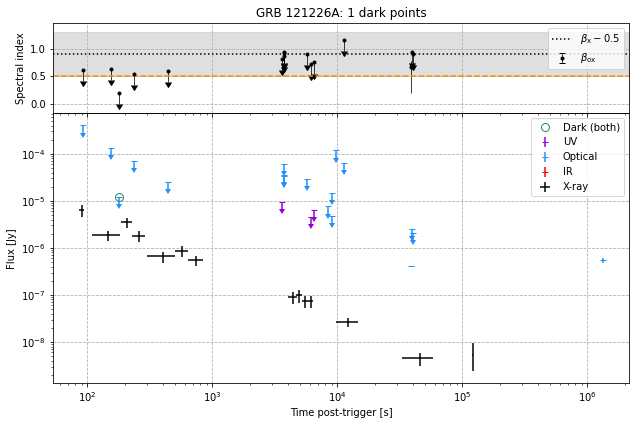

GRB        t_o       dt%  \
2496  121226A     92.800  0.030875   
2497  121226A    153.000  0.046626   
2498  121226A    179.000  0.134643   
2500  121226A    236.500  0.080764   
2501  121226A    441.500  0.104418   
2502  121226A   3621.000  0.175880   
2503  121226A   3743.712  0.147952   
2504  121226A   3743.712  0.147952   
2505  121226A   3743.712  0.147952   
2507  121226A   5681.000  0.038000   
2510  121226A   6146.000  0.004162   
2512  121226A   6543.000  0.069026   
2513  121226A  11301.120  0.077224   
2514  121226A  38520.000  0.153678   
2515  121226A  39906.000  0.123226   
2516  121226A  39960.000  0.122040   

                                             B_ox_w_err        B_x     α  \
2496    0.6088156090616437 (+0.08634601238084468, -inf)  1.4 ± 0.4  1.04   
2497    0.6303637742096536 (+0.08768682196571949, -inf)  1.4 ± 0.4  1.04   
2498   0.19939931994173682 (+0.07480697875377806, -inf)  1.4 ± 0.4  1.04   
2500    0.5374465578628711 (+0.08352019371841622, -inf)  1.4 ± 0.4  1.04   
2501     0.5902808936152806 (+0.1000999711816809, -inf)  1.4 ± 0.4  1.04   
2502      0.819561402244027 (+0.1494082939073408, -inf)  1.4 ± 0.4  1.04   
2503    0.9206772890969991 (+0.14040353908743852, -inf)  1.4 ± 0.4  1.04   
2504     0.8689430854563214 (+0.1300066480569974, -inf)  1.4 ± 0.4  1.04   
2505    0.9331795411056737 (+0.13347299830470952, -inf)  1.4 ± 0.4  1.04   
2507    0.8995901556082243 (+0.12195093387344962, -inf)  1.4 ± 0.4  1.04   
2510    0.7141985260686586 (+0.11486873541557231, -inf)  1.4 ± 0.4  1.04   
2512    0.7499126691477578 (+0.11973299743054248, -inf)  1.4 ± 0.4  1.04   
2513     1.1494055243936507 (+0.1475280687028564, -inf)  1.4 ± 0.4  1.04   
2514  0.6666602519593108 (+0.11410189504339434, -0.4...  1.4 ± 0.4  1.04   
2515     0.9354663179429547 (+0.1339511477807303, -inf)  1.4 ± 0.4  1.04   
2516     0.9035027849596424 (+0.1301357925455047, -inf)  1.4 ± 0.4  1.04   

     Jak_dark vdH_dark  
2496    False    False  
2497    False    False  
2498     True     True  
2500    False    False  
2501    False    False  
2502    False    False  
2503    False    False  
2504    False    False  
2505    False    False  
2507    False    False  
2510    False    False  
2512    False    False  
2513    False    False  
2514    False    False  
2515    False    False  
2516    False    False

2 0 1


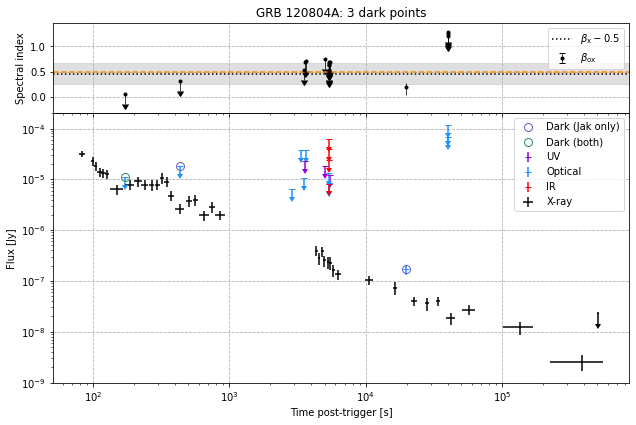

GRB       t_o       dt%  \
2518  120804A    172.00  0.074672   
2521  120804A    435.00  0.000324   
2523  120804A   3501.00  0.193322   
2524  120804A   3588.00  0.173276   
2525  120804A   3636.00  0.162216   
2530  120804A   5054.50  0.016340   
2539  120804A   5400.00  0.020125   
2546  120804A   5400.00  0.020125   
2553  120804A   5400.00  0.020125   
2560  120804A   5400.00  0.020125   
2567  120804A   5400.00  0.020125   
2574  120804A   5400.00  0.020125   
2581  120804A   5400.00  0.020125   
2587  120804A   5464.00  0.008512   
2590  120804A  19800.00  0.123502   
2592  120804A  40249.44  0.043178   
2594  120804A  40249.44  0.043178   
2596  120804A  40249.44  0.043178   

                                             B_ox_w_err                 B_x  \
2518  0.05628116489174747 (+0.049977210728545204, -inf)  0.96 (+0.21, -0.2)   
2521   0.31298462658694176 (+0.05647329959621704, -inf)  0.96 (+0.21, -0.2)   
2523     0.532231975641372 (+0.11610754227675377, -inf)  0.96 (+0.21, -0.2)   
2524     0.6874287498907186 (+0.1283596778443477, -inf)  0.96 (+0.21, -0.2)   
2525    0.7149064339965683 (+0.12208306764084416, -inf)  0.96 (+0.21, -0.2)   
2530    0.7542519044996243 (+0.11814123922088558, -inf)  0.96 (+0.21, -0.2)   
2539     0.6279922299632165 (+0.0915233617193176, -inf)  0.96 (+0.21, -0.2)   
2546     0.5365316167903782 (+0.0777822415319965, -inf)  0.96 (+0.21, -0.2)   
2553    0.5120406906452821 (+0.07291625911560846, -inf)  0.96 (+0.21, -0.2)   
2560     0.501814866425329 (+0.07031722615543273, -inf)  0.96 (+0.21, -0.2)   
2567     0.626452389793607 (+0.07921926873258009, -inf)  0.96 (+0.21, -0.2)   
2574    0.6670276253969813 (+0.08014899505568897, -inf)  0.96 (+0.21, -0.2)   
2581    0.6974654555429578 (+0.08022019242947577, -inf)  0.96 (+0.21, -0.2)   
2587    0.6876323434424885 (+0.10979195808699499, -inf)  0.96 (+0.21, -0.2)   
2590  0.20771521169885515 (+0.07555282701288185, -0....  0.96 (+0.21, -0.2)   
2592    1.2915571486591046 (+0.17087078001922076, -inf)  0.96 (+0.21, -0.2)   
2594     1.2083984399538599 (+0.1532991349541685, -inf)  0.96 (+0.21, -0.2)   
2596      1.25023728503006 (+0.15391740187753122, -inf)  0.96 (+0.21, -0.2)   

          α Jak_dark vdH_dark  
2518  1.095     True     True  
2521  1.095     True    False  
2523  1.095    False    False  
2524  1.095    False    False  
2525  1.095    False    False  
2530  1.095    False    False  
2539  1.095    False    False  
2546  1.095    False    False  
2553  1.095    False    False  
2560  1.095    False    False  
2567  1.095    False    False  
2574  1.095    False    False  
2581  1.095    False    False  
2587  1.095    False    False  
2590  1.095     True    False  
2592  1.095    False    False  
2594  1.095    False    False  
2596  1.095    False    False

1 0 0


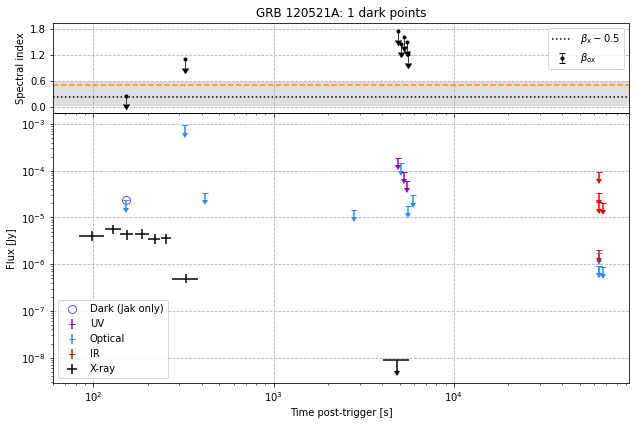

GRB     t_o       dt%  \
2599  120521A   152.0  0.012795   
2601  120521A   321.0  0.013864   
2602  120521A  4879.0  0.006462   
2603  120521A  5083.5  0.048647   
2604  120521A  5288.0  0.090832   
2605  120521A  5494.0  0.133327   
2606  120521A  5532.0  0.141166   

                                           B_ox_w_err                  B_x  \
2599  0.2651610920387164 (+0.05125032743714506, -inf)  0.74 (+0.33, -0.19)   
2601  1.1111432242080963 (+0.13879044173992963, -inf)  0.74 (+0.33, -0.19)   
2602                         1.7568717774256508 ± inf  0.74 (+0.33, -0.19)   
2603                         1.4646922793488397 ± inf  0.74 (+0.33, -0.19)   
2604                         1.6182471864659689 ± inf  0.74 (+0.33, -0.19)   
2605                          1.492644526512864 ± inf  0.74 (+0.33, -0.19)   
2606                          1.229591418162971 ± inf  0.74 (+0.33, -0.19)   

         α Jak_dark vdH_dark  
2599  1.81     True    False  
2601  1.81    False    False  
2602  1.81    False    False  
2603  1.81    False    False  
2604  1.81    False    False  
2605  1.81    False    False  
2606  1.81    False    False

0 0 2


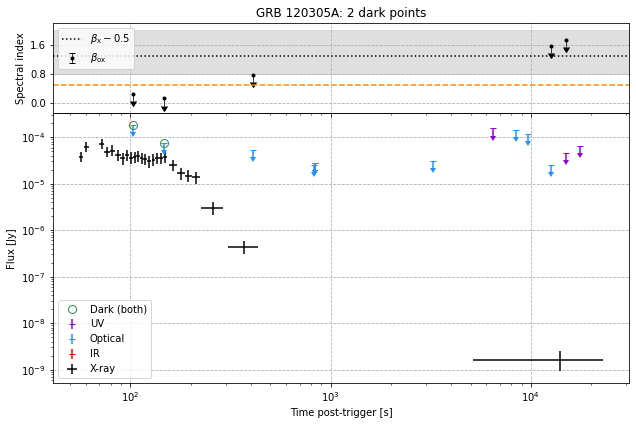

GRB      t_o       dt%  \
2611  120305A    102.6  0.021263   
2620  120305A    146.5  0.013328   
2623  120305A    409.0  0.106261   
2624  120305A  12591.0  0.101245   
2625  120305A  14927.5  0.065536   

                                            B_ox_w_err  \
2611  0.23434243239078842 (+0.04827035871211285, -inf)   
2620  0.11611174953625314 (+0.04256203635582089, -inf)   
2623   0.7777194093992553 (+0.12128596935904017, -inf)   
2624    1.5609192566850651 (+0.2227260987460595, -inf)   
2625     1.730362545660643 (+0.2528787778542496, -inf)   

                                  B_x    α Jak_dark vdH_dark  
2611  1.7999999999999998 (+0.7, -0.5)  1.0     True     True  
2620  1.7999999999999998 (+0.7, -0.5)  1.0     True     True  
2623  1.7999999999999998 (+0.7, -0.5)  1.0    False    False  
2624  1.7999999999999998 (+0.7, -0.5)  1.0    False    False  
2625  1.7999999999999998 (+0.7, -0.5)  1.0    False    False

2 0 0


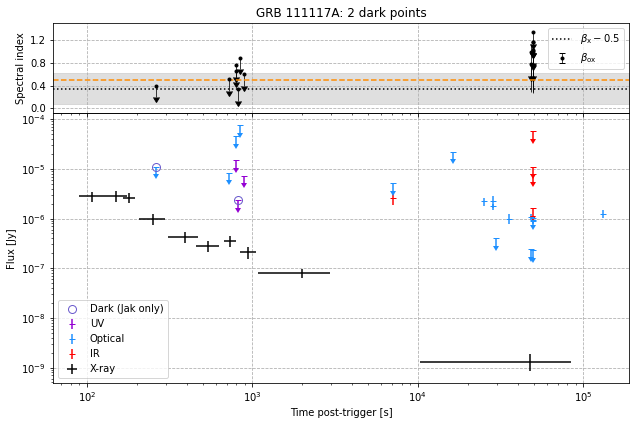

GRB         t_o       dt%  \
2671  111117A    262.0000  0.043833   
2672  111117A    726.0000  0.011143   
2673  111117A    791.5000  0.078072   
2675  111117A    792.5000  0.079434   
2677  111117A    818.0000  0.114167   
2680  111117A    842.0000  0.108830   
2681  111117A    891.5000  0.056439   
2682  111117A  48427.0272  0.019914   
2683  111117A  48600.0000  0.023557   
2684  111117A  49320.0000  0.038721   
2685  111117A  49680.0000  0.046303   
2686  111117A  49680.0000  0.046303   
2687  111117A  49680.0000  0.046303   
2688  111117A  49680.0000  0.046303   
2689  111117A  49680.0000  0.046303   
2690  111117A  49680.0000  0.046303   
2691  111117A  49680.0000  0.046303   

                                             B_ox_w_err  \
2671     0.3905048990778049 (+0.0692247526003332, -inf)   
2672    0.5123333528530376 (+0.07889517860359915, -inf)   
2673    0.7584226620514275 (+0.11274327040569912, -inf)   
2675     0.654043512805722 (+0.11130801242033611, -inf)   
2677     0.33558064651446956 (+0.088064428185012, -inf)   
2680    0.8865554280444614 (+0.13051412702572085, -inf)   
2681    0.5982173751247403 (+0.09913765716462393, -inf)   
2682    0.7724911503331385 (+0.10737959862035297, -inf)   
2683  0.9922774667210409 (+0.13359302378170204, -0.7...   
2684    0.7623659188491889 (+0.10758602998764741, -inf)   
2685  1.0198633849735832 (+0.14484047092617952, -0.7...   
2686  0.969391386510134 (+0.13320127519690458, -0.68...   
2687    0.9597635168705687 (+0.12635691815407876, -inf)   
2688    1.0012303955636905 (+0.12797065567643348, -inf)   
2689    1.1671196520108384 (+0.13965851124393408, -inf)   
2690    1.1703401836734726 (+0.13494938312352533, -inf)   
2691     1.3362725942971405 (+0.1464441935591579, -inf)   

                                    B_x     α Jak_dark vdH_dark  
2671  0.8400000000000001 (+0.28, -0.26)  1.27     True    False  
2672  0.8400000000000001 (+0.28, -0.26)  1.27    False    False  
2673  0.8400000000000001 (+0.28, -0.26)  1.27    False    False  
2675  0.8400000000000001 (+0.28, -0.26)  1.27    False    False  
2677  0.8400000000000001 (+0.28, -0.26)  1.27     True    False  
2680  0.8400000000000001 (+0.28, -0.26)  1.27    False    False  
2681  0.8400000000000001 (+0.28, -0.26)  1.27    False    False  
2682  0.8400000000000001 (+0.28, -0.26)  1.27    False    False  
2683  0.8400000000000001 (+0.28, -0.26)  1.27    False    False  
2684  0.8400000000000001 (+0.28, -0.26)  1.27    False    False  
2685  0.8400000000000001 (+0.28, -0.26)  1.27    False    False  
2686  0.8400000000000001 (+0.28, -0.26)  1.27    False    False  
2687  0.8400000000000001 (+0.28, -0.26)  1.27    False    False  
2688  0.8400000000000001 (+0.28, -0.26)  1.27    False    False  
2689  0.8400000000000001 (+0.28, -0.26)  1.27    False    False  
2690  0.8400000000000001 (+0.28, -0.26)  1.27    False    False  
2691  0.8400000000000001 (+0.28, -0.26)  1.27    False    False

0 0 1


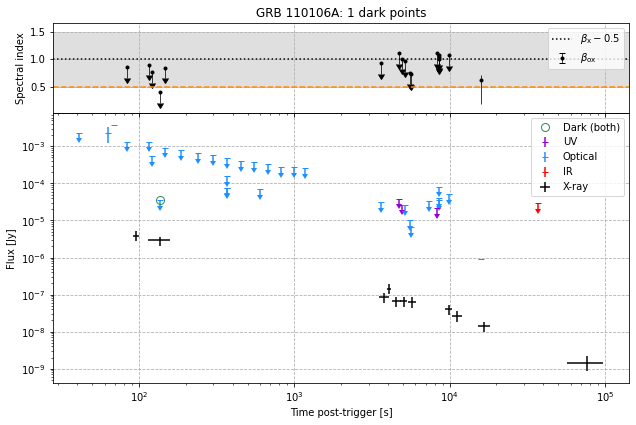

GRB        t_o       dt%  \
2733  110106A     84.000  0.122100   
2734  110106A    115.000  0.150313   
2735  110106A    120.000  0.113370   
2736  110106A    136.000  0.004847   
2737  110106A    146.000  0.078733   
2738  110106A   3605.000  0.050843   
2741  110106A   4710.500  0.038750   
2745  110106A   4915.500  0.029071   
2748  110106A   5120.500  0.011421   
2751  110106A   5527.872  0.033575   
2753  110106A   5652.000  0.011874   
2754  110106A   8317.500  0.158478   
2755  110106A   8584.704  0.131444   
2756  110106A   8584.704  0.131444   
2757  110106A   8584.704  0.131444   
2758  110106A   9866.500  0.001758   
2760  110106A  15876.000  0.048811   

                                             B_ox_w_err        B_x     α  \
2733    0.8593080495883408 (+0.12634664443018587, -inf)  1.5 ± 0.5  1.11   
2734    0.9035345136400693 (+0.13520827245097633, -inf)  1.5 ± 0.5  1.11   
2735    0.7696124028752046 (+0.11452894340993054, -inf)  1.5 ± 0.5  1.11   
2736    0.3955148107219521 (+0.06799658258436435, -inf)  1.5 ± 0.5  1.11   
2737    0.8493401222200034 (+0.11684943222248267, -inf)  1.5 ± 0.5  1.11   
2738    0.9391780818777056 (+0.13489929713373555, -inf)  1.5 ± 0.5  1.11   
2741    1.1105084963677918 (+0.16967385517973407, -inf)  1.5 ± 0.5  1.11   
2745    1.0142646162651325 (+0.15146128137271167, -inf)  1.5 ± 0.5  1.11   
2748    0.9614914061376749 (+0.13775315433323715, -inf)  1.5 ± 0.5  1.11   
2751    0.7456140577600381 (+0.10277377801243866, -inf)  1.5 ± 0.5  1.11   
2753    0.7369708077609889 (+0.10875178530093245, -inf)  1.5 ± 0.5  1.11   
2754    1.1064968854260988 (+0.18455971661089898, -inf)  1.5 ± 0.5  1.11   
2755      1.04626862051361 (+0.15374585570132585, -inf)  1.5 ± 0.5  1.11   
2756     1.013589174375667 (+0.14425501864699544, -inf)  1.5 ± 0.5  1.11   
2757    1.0863205719340059 (+0.14835635242498094, -inf)  1.5 ± 0.5  1.11   
2758     1.0767428033505129 (+0.1423776610053139, -inf)  1.5 ± 0.5  1.11   
2760  0.6147052041805736 (+0.08951424103372473, -0.4...  1.5 ± 0.5  1.11   

     Jak_dark vdH_dark  
2733    False    False  
2734    False    False  
2735    False    False  
2736     True     True  
2737    False    False  
2738    False    False  
2741    False    False  
2745    False    False  
2748    False    False  
2751    False    False  
2753    False    False  
2754    False    False  
2755    False    False  
2756    False    False  
2757    False    False  
2758    False    False  
2760    False    False

1 0 0


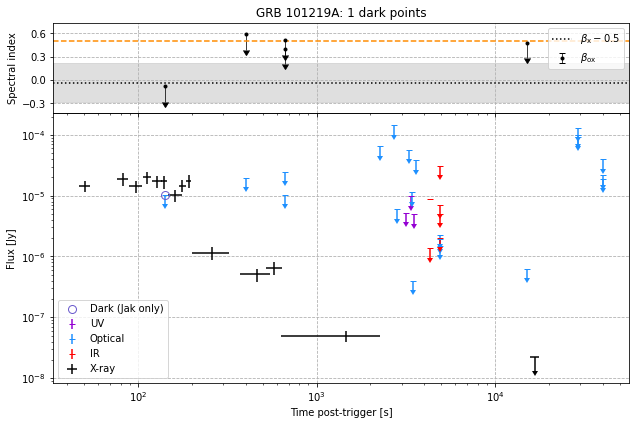

GRB      t_o       dt%  \
2762  101219A    142.0  0.013309   
2765  101219A    403.5  0.125461   
2766  101219A    666.0  0.149386   
2767  101219A    666.0  0.149386   
2768  101219A  15120.0  0.094377   

                                             B_ox_w_err  \
2762  -0.08032539371266008 (+0.040495150670132395, -...   
2765     0.591046242916151 (+0.12275979249258792, -inf)   
2766   0.40475941311911723 (+0.11768598580283707, -inf)   
2767    0.5184465105342154 (+0.12281553305501818, -inf)   
2768                           0.4797443688796422 ± inf   

                                    B_x     α Jak_dark vdH_dark  
2762  0.4599999999999999 (+0.26, -0.24)  1.67     True    False  
2765  0.4599999999999999 (+0.26, -0.24)  1.67    False    False  
2766  0.4599999999999999 (+0.26, -0.24)  1.67    False    False  
2767  0.4599999999999999 (+0.26, -0.24)  1.67    False    False  
2768  0.4599999999999999 (+0.26, -0.24)  1.67    False    False

1 0 0


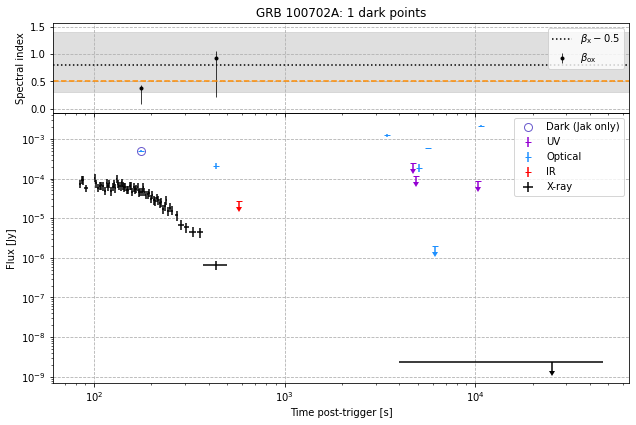

GRB    t_o       dt%  \
2839  100702A  176.0  0.004050   
2852  100702A  439.0  0.011283   

                                             B_ox_w_err  \
2839  0.3762568652979101 (+0.062115099329621296, -0....   
2852  0.9281497760085539 (+0.13338508778982908, -0.7...   

                                  B_x    α Jak_dark vdH_dark  
2839  1.2999999999999998 (+0.6, -0.5)  2.9     True    False  
2852  1.2999999999999998 (+0.6, -0.5)  2.9    False    False

0 1 1


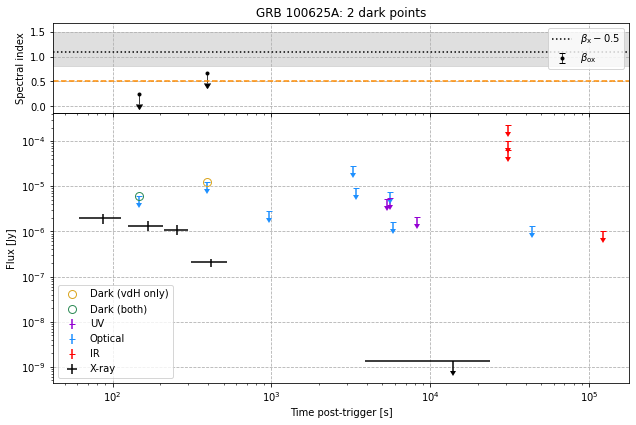

GRB    t_o       dt%  \
2853  100625A  146.5  0.118304   
2854  100625A  394.0  0.059538   

                                            B_ox_w_err               B_x  \
2853  0.23921578602800378 (+0.08643968662355281, -inf)  1.6 (+0.4, -0.3)   
2854    0.661307473055828 (+0.10092550933649871, -inf)  1.6 (+0.4, -0.3)   

         α Jak_dark vdH_dark  
2853  1.45     True     True  
2854  1.45    False     True

0 0 1


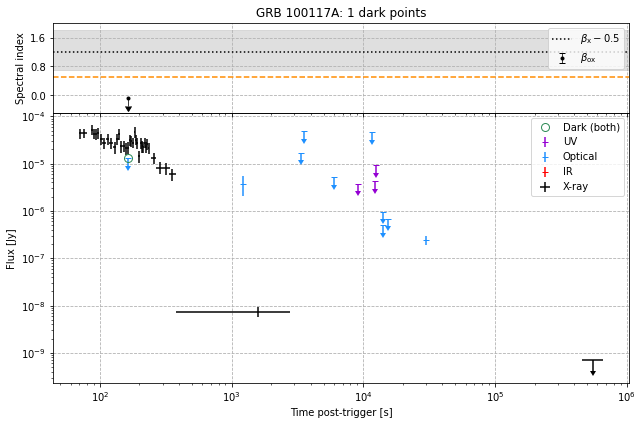

GRB    t_o       dt%  \
2863  100117A  163.5  0.003735   

                                             B_ox_w_err  \
2863  -0.08384044747938293 (+0.04582344545091654, -inf)   

                                  B_x    α Jak_dark vdH_dark  
2863  1.7000000000000002 (+0.6, -0.5)  1.0     True     True

0 0 1


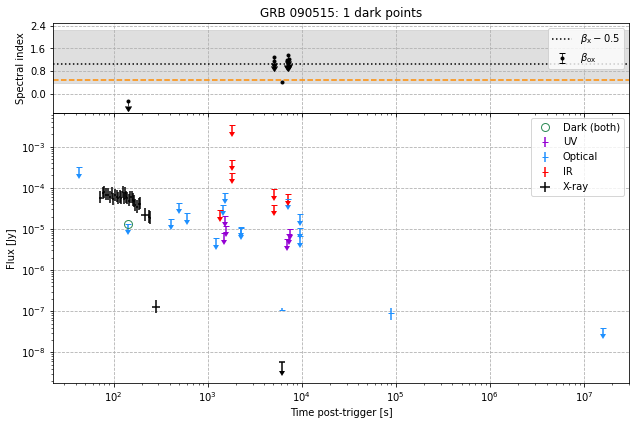

GRB     t_o       dt%  \
2885  090515   141.5  0.007089   
2892  090515  5040.0  0.187907   
2893  090515  5040.0  0.187907   
2894  090515  6120.0  0.013888   
2895  090515  6924.5  0.115741   
2896  090515  7129.0  0.148692   
2897  090515  7140.0  0.150464   
2898  090515  7333.5  0.181643   

                                            B_ox_w_err  \
2885  -0.2287223009743839 (+0.05486187789698157, -inf)   
2892                           1.293431540632887 ± inf   
2893                           1.178400032404398 ± inf   
2894    0.4300818397269228 (+inf, -0.3098806896917142)   
2895                          1.2051310399812327 ± inf   
2896                          1.3767661920129626 ± inf   
2897                          1.1699398662176843 ± inf   
2898                          1.2445968746052147 ± inf   

                                    B_x     α Jak_dark vdH_dark  
2885  1.5699999999999998 (+1.19, -0.68)  4.49     True     True  
2892  1.5699999999999998 (+1.19, -0.68)  4.49    False    False  
2893  1.5699999999999998 (+1.19, -0.68)  4.49    False    False  
2894  1.5699999999999998 (+1.19, -0.68)  4.49    False    False  
2895  1.5699999999999998 (+1.19, -0.68)  4.49    False    False  
2896  1.5699999999999998 (+1.19, -0.68)  4.49    False    False  
2897  1.5699999999999998 (+1.19, -0.68)  4.49    False    False  
2898  1.5699999999999998 (+1.19, -0.68)  4.49    False    False

7 0 0


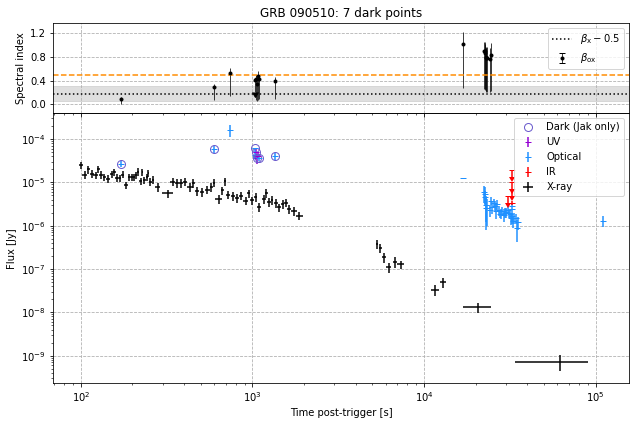

GRB      t_o       dt%  \
2904  090510    172.0  0.018360   
2913  090510    598.0  0.002051   
2922  090510    745.0  0.028477   
2929  090510   1033.0  0.011171   
2937  090510   1048.0  0.003188   
2946  090510   1069.5  0.023768   
2956  090510   1083.0  0.013953   
2965  090510   1094.5  0.003483   
2974  090510   1346.5  0.017940   
2979  090510  16920.0  0.182582   
2980  090510  22320.0  0.078296   
2981  090510  22680.0  0.095688   
2982  090510  22680.0  0.095688   
2983  090510  23040.0  0.113080   
2984  090510  23040.0  0.113080   
2985  090510  23400.0  0.130472   
2986  090510  24120.0  0.165255   
2987  090510  24480.0  0.182647   

                                             B_ox_w_err  \
2904  0.08784455192610077 (+0.04083739134265433, -0....   
2913  0.2830830381506375 (+0.061043597051168914, -0....   
2922  0.5286355783855248 (+0.08745686716508215, -0.3...   
2929    0.4055768160779434 (+0.06336317724028344, -inf)   
2937  0.4174284916801267 (+0.08014109114776327, -0.3...   
2946  0.34726398313115825 (+0.07506029538187704, -0....   
2956  0.47825224660054355 (+0.08570599257051385, -0....   
2965  0.4205399973673835 (+0.07172437802329212, -0.3...   
2974  0.3961574973703175 (+0.06958701930388769, -0.3...   
2979  1.0097524933513828 (+0.20239001077715285, -0.7...   
2980  0.9011947377451318 (+0.14996387322010746, -0.6...   
2981  0.8908206311073994 (+0.15625128960035578, -0.6...   
2982  0.8644152860935175 (+0.15015267634391702, -0.6...   
2983  0.7801056827274128 (+0.17606986321294585, -0.5...   
2984  0.8012517419542088 (+0.1699850622434121, -0.58...   
2985  0.7801056827274128 (+0.17855276549395088, -0.5...   
2986  0.7619886968428493 (+0.1802477891343109, -0.55...   
2987  0.8361829902566151 (+0.19281818342770124, -0.6...   

                            B_x     α Jak_dark vdH_dark  
2904  0.6799999999999999 ± 0.12  0.66     True    False  
2913  0.6799999999999999 ± 0.12  0.66     True    False  
2922  0.6799999999999999 ± 0.12  0.66    False    False  
2929  0.6799999999999999 ± 0.12  0.66     True    False  
2937  0.6799999999999999 ± 0.12  0.66     True    False  
2946  0.6799999999999999 ± 0.12  0.66     True    False  
2956  0.6799999999999999 ± 0.12  0.66    False    False  
2965  0.6799999999999999 ± 0.12  0.66     True    False  
2974  0.6799999999999999 ± 0.12  0.66     True    False  
2979  0.6799999999999999 ± 0.12  2.14    False    False  
2980  0.6799999999999999 ± 0.12  2.14    False    False  
2981  0.6799999999999999 ± 0.12  2.14    False    False  
2982  0.6799999999999999 ± 0.12  2.14    False    False  
2983  0.6799999999999999 ± 0.12  2.14    False    False  
2984  0.6799999999999999 ± 0.12  2.14    False    False  
2985  0.6799999999999999 ± 0.12  2.14    False    False  
2986  0.6799999999999999 ± 0.12  2.14    False    False  
2987  0.6799999999999999 ± 0.12  2.14    False    False

4 0 1


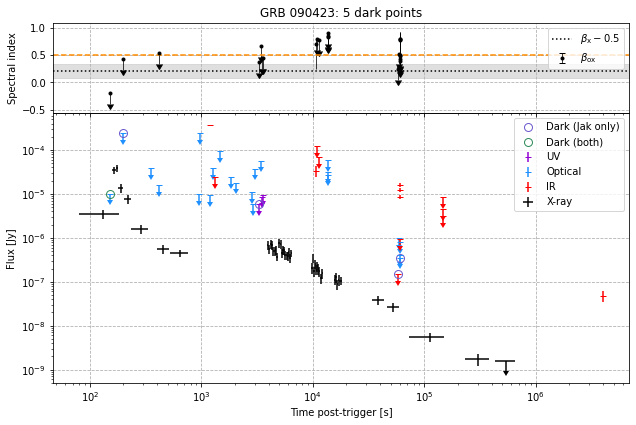

GRB        t_o       dt%  \
3105  090423    152.000  0.073001   
3109  090423    200.000  0.059277   
3111  090423    415.000  0.090313   
3112  090423   3276.000  0.171292   
3114  090423   3390.500  0.142327   
3117  090423   3505.500  0.113237   
3121  090423   3585.500  0.092999   
3130  090423  10693.728  0.006462   
3141  090423  10872.576  0.007603   
3153  090423  11351.232  0.007832   
3159  090423  13716.864  0.124212   
3166  090423  13716.864  0.124212   
3173  090423  13716.864  0.124212   
3177  090423  58500.000  0.118792   
3178  090423  59417.280  0.136334   
3179  090423  60120.000  0.149773   
3180  090423  60120.000  0.149773   
3181  090423  60120.000  0.149773   
3182  090423  60120.000  0.149773   
3183  090423  60120.000  0.149773   
3184  090423  60120.000  0.149773   
3185  090423  60120.000  0.149773   

                                             B_ox_w_err          B_x     α  \
3105  -0.19625502204644998 (+0.03786611839727725, -inf)  0.71 ± 0.13  0.00   
3109     0.4220631211100543 (+0.0610898281985447, -inf)  0.71 ± 0.13  0.00   
3111    0.5435660948662138 (+0.08139323197387692, -inf)  0.71 ± 0.13  0.00   
3112    0.3778416196377353 (+0.06813196395948531, -inf)  0.71 ± 0.13  0.00   
3114    0.6658786646168151 (+0.08989219777961938, -inf)  0.71 ± 0.13  0.00   
3117    0.4394081846359419 (+0.07459329130180321, -inf)  0.71 ± 0.13  0.00   
3121    0.4446744741666907 (+0.07297264310172949, -inf)  0.71 ± 0.13  0.00   
3130  0.6957393755851607 (+0.09282476413483007, -0.4...  0.71 ± 0.13  1.41   
3141    0.7854933071113882 (+0.08763641731540132, -inf)  0.71 ± 0.13  1.41   
3153    0.7728866554589707 (+0.08936460668675664, -inf)  0.71 ± 0.13  1.41   
3159     0.847739734882957 (+0.13587887920961053, -inf)  0.71 ± 0.13  1.41   
3166     0.830417564370326 (+0.12968172612757223, -inf)  0.71 ± 0.13  1.41   
3173    0.8975812153941012 (+0.13344324587886056, -inf)  0.71 ± 0.13  1.41   
3177    0.23958836645575843 (+0.0816700617834124, -inf)  0.71 ± 0.13  1.41   
3178    0.5271418944797194 (+0.10743597116444928, -inf)  0.71 ± 0.13  1.41   
3179    0.4187436832196045 (+0.10790819171185169, -inf)  0.71 ± 0.13  1.41   
3180    0.3816049476006451 (+0.10400469637947632, -inf)  0.71 ± 0.13  1.41   
3181    0.4857696275950172 (+0.10894871519902481, -inf)  0.71 ± 0.13  1.41   
3182     0.4991531886133853 (+0.1088290718132078, -inf)  0.71 ± 0.13  1.41   
3183  0.7729482930587027 (+0.1261568028602808, -0.50...  0.71 ± 0.13  1.41   
3184  0.7908384216645626 (+0.12492531993960605, -0.4...  0.71 ± 0.13  1.41   
3185  0.7974320408905083 (+0.12309694707090166, -0.4...  0.71 ± 0.13  1.41   

     Jak_dark vdH_dark  
3105     True     True  
3109     True    False  
3111    False    False  
3112     True    False  
3114    False    False  
3117    False    False  
3121    False    False  
3130    False    False  
3141    False    False  
3153    False    False  
3159    False    False  
3166    False    False  
3173    False    False  
3177     True    False  
3178    False    False  
3179    False    False  
3180     True    False  
3181    False    False  
3182    False    False  
3183    False    False  
3184    False    False  
3185    False    False

8 0 0


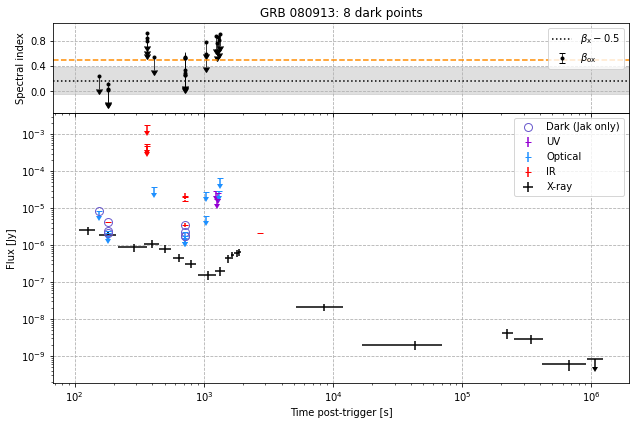

GRB     t_o       dt%  \
3219  080913   155.0  0.142334   
3220  080913   180.0  0.004001   
3221  080913   180.0  0.004001   
3222  080913   180.0  0.004001   
3223  080913   360.0  0.090916   
3224  080913   360.0  0.090916   
3225  080913   360.0  0.090916   
3226  080913   411.0  0.037871   
3229  080913   720.0  0.087132   
3231  080913   720.0  0.087132   
3233  080913   720.0  0.087132   
3235  080913   720.0  0.087132   
3237  080913   720.0  0.087132   
3239  080913   720.0  0.087132   
3241  080913   720.0  0.087132   
3242  080913  1034.5  0.042055   
3243  080913  1034.5  0.042055   
3245  080913  1249.0  0.068168   
3248  080913  1274.0  0.049517   
3251  080913  1277.0  0.047279   
3253  080913  1299.0  0.030865   
3255  080913  1324.0  0.012214   

                                             B_ox_w_err  \
3219    0.2399314397193824 (+0.08439495698970664, -inf)   
3220  0.01605618847209473 (+0.034030454093975926, -inf)   
3221   0.03748108498254906 (+0.03320026502328484, -inf)   
3222  0.11163150427182805 (+0.03467104322158288, -0....   
3223    0.8340860037015736 (+0.10785842933373392, -inf)   
3224    0.7896194722319819 (+0.10051970738181493, -inf)   
3225    0.9205862265650239 (+0.10909538872767571, -inf)   
3226      0.53490837967778 (+0.07793681219762023, -inf)   
3229   0.26489000672688745 (+0.06617518208200583, -inf)   
3231    0.2529994851385232 (+0.06378663228882395, -inf)   
3233     0.284634977772599 (+0.06459595553754052, -inf)   
3235  0.3402391403389642 (+0.0701010792938108, -0.23...   
3237  0.5262222241705741 (+0.07976032687869382, -0.3...   
3239  0.5340339423580948 (+0.0787020286608472, -0.33...   
3241  0.5304888899837922 (+0.07960682218046862, -0.3...   
3242    0.5839763950759678 (+0.09002343165309114, -inf)   
3243    0.7813906865248299 (+0.10748809163580542, -inf)   
3245    0.8733635330354589 (+0.13838766940616562, -inf)   
3248    0.7629561167954357 (+0.11842174355956153, -inf)   
3251    0.8594025754558471 (+0.13604177854436672, -inf)   
3253    0.8116196567764709 (+0.11771554479040972, -inf)   
3255    0.9089272082940604 (+0.12471175608300691, -inf)   

                                   B_x    α Jak_dark vdH_dark  
3219  0.6599999999999999 (+0.23, -0.2)  1.2     True    False  
3220  0.6599999999999999 (+0.23, -0.2)  1.2     True    False  
3221  0.6599999999999999 (+0.23, -0.2)  1.2     True    False  
3222  0.6599999999999999 (+0.23, -0.2)  1.2     True    False  
3223  0.6599999999999999 (+0.23, -0.2)  1.2    False    False  
3224  0.6599999999999999 (+0.23, -0.2)  1.2    False    False  
3225  0.6599999999999999 (+0.23, -0.2)  1.2    False    False  
3226  0.6599999999999999 (+0.23, -0.2)  1.2    False    False  
3229  0.6599999999999999 (+0.23, -0.2)  1.2     True    False  
3231  0.6599999999999999 (+0.23, -0.2)  1.2     True    False  
3233  0.6599999999999999 (+0.23, -0.2)  1.2     True    False  
3235  0.6599999999999999 (+0.23, -0.2)  1.2     True    False  
3237  0.6599999999999999 (+0.23, -0.2)  1.2    False    False  
3239  0.6599999999999999 (+0.23, -0.2)  1.2    False    False  
3241  0.6599999999999999 (+0.23, -0.2)  1.2    False    False  
3242  0.6599999999999999 (+0.23, -0.2)  1.2    False    False  
3243  0.6599999999999999 (+0.23, -0.2)  1.2    False    False  
3245  0.6599999999999999 (+0.23, -0.2)  1.2    False    False  
3248  0.6599999999999999 (+0.23, -0.2)  1.2    False    False  
3251  0.6599999999999999 (+0.23, -0.2)  1.2    False    False  
3253  0.6599999999999999 (+0.23, -0.2)  1.2    False    False  
3255  0.6599999999999999 (+0.23, -0.2)  1.2    False    False

0 0 2


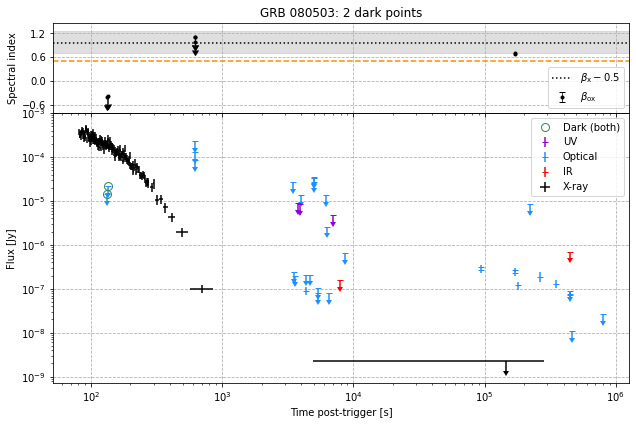

GRB       t_o       dt%  \
3284  080503     133.2  0.001207   
3340  080503     134.5  0.002226   
3369  080503     620.0  0.123748   
3370  080503     620.0  0.123748   
3371  080503     620.0  0.123748   
3372  080503  170640.0  0.176841   
3373  080503  170640.0  0.176841   

                                            B_ox_w_err  \
3284  -0.41446458075626785 (+0.0604287156633898, -inf)   
3340  -0.3717373566638188 (+0.05574912379071332, -inf)   
3369   1.1050866413669602 (+0.43039424861514924, -inf)   
3370   0.9898254392685115 (+0.42398845549253483, -inf)   
3371     1.103017708565408 (+0.4268936581266706, -inf)   
3372    0.7063283846912259 (+inf, -0.7540846248150592)   
3373    0.6817994831780811 (+inf, -0.7425139963765917)   

                                    B_x     α Jak_dark vdH_dark  
3284  1.4500000000000002 (+0.32, -0.24)  1.64     True     True  
3340  1.4500000000000002 (+0.32, -0.24)  1.64     True     True  
3369  1.4500000000000002 (+0.32, -0.24)  8.00    False    False  
3370  1.4500000000000002 (+0.32, -0.24)  8.00    False    False  
3371  1.4500000000000002 (+0.32, -0.24)  8.00    False    False  
3372  1.4500000000000002 (+0.32, -0.24)  8.00    False    False  
3373  1.4500000000000002 (+0.32, -0.24)  8.00    False    False

0 0 2


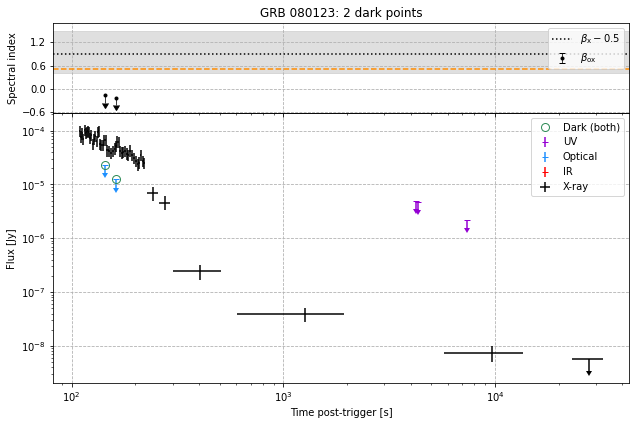

GRB    t_o       dt%  \
3387  080123  144.0  0.005923   
3410  080123  161.5  0.003585   

                                             B_ox_w_err               B_x  \
3387  -0.16940545058698822 (+0.04211980335327065, -inf)  1.4 (+0.6, -0.5)   
3410  -0.22627806369666828 (+0.04645418153007017, -inf)  1.4 (+0.6, -0.5)   

        α Jak_dark vdH_dark  
3387  2.2     True     True  
3410  2.2     True     True

1 0 0


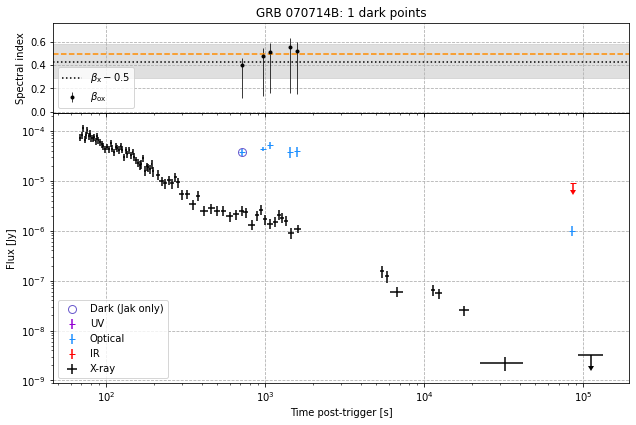

GRB     t_o       dt%  \
3447  070714B   720.0  0.012677   
3454  070714B   972.0  0.026857   
3459  070714B  1080.0  0.002530   
3466  070714B  1440.0  0.007071   
3470  070714B  1584.0  0.010861   

                                             B_ox_w_err                  B_x  \
3447  0.3991626238539481 (+0.06473473485990588, -0.2...  0.93 (+0.15, -0.14)   
3454  0.47821776821143014 (+0.06977052780202826, -0....  0.93 (+0.15, -0.14)   
3459  0.5160295816074629 (+0.07340671391827903, -0.3...  0.93 (+0.15, -0.14)   
3466  0.5527350413762803 (+0.08467823188812844, -0.3...  0.93 (+0.15, -0.14)   
3470  0.5246467021403641 (+0.07713257228976919, -0.3...  0.93 (+0.15, -0.14)   

         α Jak_dark vdH_dark  
3447  0.68     True    False  
3454  0.68    False    False  
3459  0.68    False    False  
3466  0.68    False    False  
3470  0.68    False    False

0 0 2


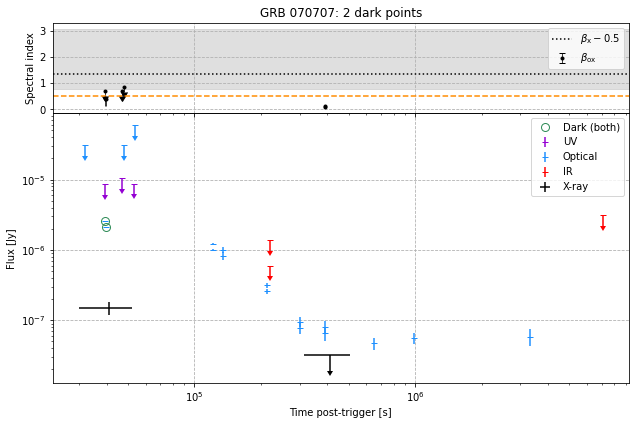

GRB         t_o       dt%  \
3471  070707   39328.000  0.040780   
3472  070707   39521.088  0.036071   
3473  070707   39600.000  0.034146   
3474  070707   47149.000  0.149976   
3475  070707   47905.000  0.168415   
3476  070707  388800.000  0.051707   
3477  070707  388907.136  0.051446   

                                             B_ox_w_err                  B_x  \
3471    0.7036409684769428 (+0.10918105703057798, -inf)  1.86 (+1.71, -0.57)   
3472  0.41689736741625993 (+0.0615635719850237, -0.2...  1.86 (+1.71, -0.57)   
3473  0.3870179453790122 (+0.05831681402895094, -0.2...  1.86 (+1.71, -0.57)   
3474    0.7162274538115445 (+0.12231699836875151, -inf)  1.86 (+1.71, -0.57)   
3475    0.8594059156485568 (+0.13746233272517053, -inf)  1.86 (+1.71, -0.57)   
3476   0.10616274934031909 (+inf, -0.08434067845047725)  1.86 (+1.71, -0.57)   
3477   0.13511853490535963 (+inf, -0.10167503741313387)  1.86 (+1.71, -0.57)   

        α Jak_dark vdH_dark  
3471  1.0    False    False  
3472  1.0     True     True  
3473  1.0     True     True  
3474  1.0    False    False  
3475  1.0    False    False  
3476  1.0    False    False  
3477  1.0    False    False

4 0 0


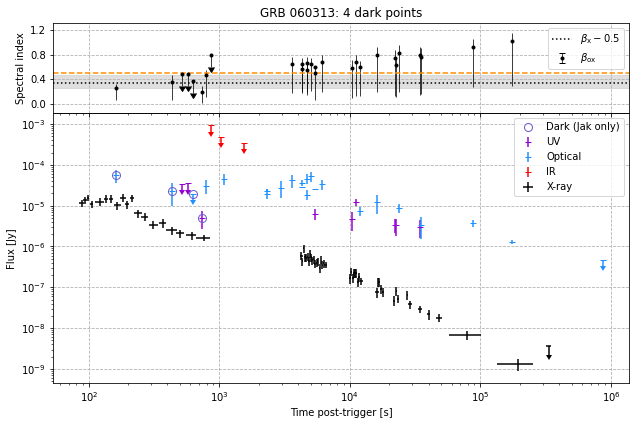

GRB       t_o       dt%  \
3502  060313     162.0  0.022188   
3506  060313     432.0  0.004432   
3508  060313     521.5  0.039860   
3511  060313     575.5  0.059823   
3512  060313     629.5  0.028395   
3514  060313     739.0  0.023547   
3515  060313     792.0  0.046483   
3516  060313     864.0  0.141617   
3517  060313    3570.0  0.156451   
3520  060313    4260.0  0.006588   
3532  060313    4320.0  0.002519   
3546  060313    4680.0  0.009227   
3561  060313    4680.0  0.009227   
3580  060313    5040.0  0.001225   
3597  060313    5400.0  0.002408   
3613  060313    5400.0  0.002408   
3628  060313    6120.0  0.005706   
3633  060313   10440.0  0.007365   
3645  060313   11160.0  0.002267   
3656  060313   11880.0  0.012105   
3658  060313   16200.0  0.003235   
3663  060313   21960.0  0.005735   
3667  060313   22680.0  0.000491   
3672  060313   23760.0  0.013823   
3676  060313   34560.0  0.004177   
3678  060313   35280.0  0.025098   
3680  060313   87120.0  0.098278   
3681  060313  174600.0  0.092153   

                                             B_ox_w_err  \
3502  0.25537158441562124 (+0.06979786317533948, -0....   
3506  0.3570767530886726 (+0.11049834993494675, -0.2...   
3508   0.48769492019673866 (+0.08230726076659017, -inf)   
3511    0.4931519663391611 (+0.08274795138981317, -inf)   
3512   0.37546685197672236 (+0.06330506308398082, -inf)   
3514  0.20120618337611967 (+0.09275371685417784, -0....   
3515  0.46341318236392615 (+0.09231653407481417, -0....   
3516    0.7924140850988121 (+0.10259382391279188, -inf)   
3517  0.6446507463465975 (+0.1206741797479412, -0.47...   
3520  0.5698665473911164 (+0.07679954767542656, -0.4...   
3532  0.6542278633692479 (+0.09044808446874764, -0.4...   
3546  0.6606015828774862 (+0.09634175060213641, -0.4...   
3561  0.5566236123299706 (+0.09112192469376035, -0.4...   
3580  0.6527827096004698 (+0.09224095420898909, -0.4...   
3597                    0.6041416629190015 (+nan, -nan)   
3613  0.5073076300428265 (+0.10038001451000375, -0.4...   
3628  0.6855677010146835 (+0.10132158983479143, -0.4...   
3633  0.5778200125615623 (+0.12752336981640153, -0.4...   
3645  0.6805572047926256 (+0.10928537929332284, -0.5...   
3656  0.5993256765074654 (+0.09899893548785473, -0.4...   
3658  0.791353745332162 (+0.13255216643432127, -0.59...   
3663  0.743464669584619 (+0.13173942064149197, -0.62...   
3667  0.6263590963506426 (+0.12510269200701496, -0.5...   
3672  0.827272234050091 (+0.12340950888602387, -0.64...   
3676  0.7849654690490396 (+0.14023890099729938, -0.6...   
3678  0.7685654661777407 (+0.1414310419657587, -0.60...   
3680  0.9256875830068744 (+0.1292146557191775, -0.65...   
3681  1.0151510820356378 (+0.13914314180029091, -0.7...   

                                     B_x    α Jak_dark vdH_dark  
3502  0.8460000000000001 (+0.12, -0.087)  1.0     True    False  
3506  0.8460000000000001 (+0.12, -0.087)  1.0     True    False  
3508  0.8460000000000001 (+0.12, -0.087)  1.0    False    False  
3511  0.8460000000000001 (+0.12, -0.087)  1.0    False    False  
3512  0.8460000000000001 (+0.12, -0.087)  1.0     True    False  
3514  0.8460000000000001 (+0.12, -0.087)  1.0     True    False  
3515  0.8460000000000001 (+0.12, -0.087)  1.0    False    False  
3516  0.8460000000000001 (+0.12, -0.087)  1.0    False    False  
3517  0.8460000000000001 (+0.12, -0.087)  1.0    False    False  
3520  0.8460000000000001 (+0.12, -0.087)  1.0    False    False  
3532  0.8460000000000001 (+0.12, -0.087)  1.0    False    False  
3546  0.8460000000000001 (+0.12, -0.087)  1.0    False    False  
3561  0.8460000000000001 (+0.12, -0.087)  1.0    False    False  
3580  0.8460000000000001 (+0.12, -0.087)  1.0    False    False  
3597  0.8460000000000001 (+0.12, -0.087)  1.0    False    False  
3613  0.8460000000000001 (+0.12, -0.087)  1.0    False    False  
3628  0.8460000000000001 (+0.12, -0.087)  1.0    False    False  
3633  0.8460000000000001 (+0.12, -0.087)  1.0    False    False 

1 0 6


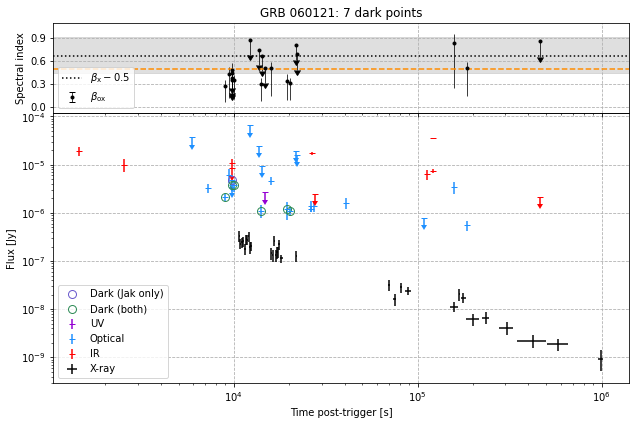

GRB       t_o       dt%  \
3682  060121    9000.0  0.157425   
3685  060121    9360.0  0.123723   
3691  060121    9720.0  0.090020   
3699  060121    9720.0  0.090020   
3707  060121    9720.0  0.090020   
3715  060121    9720.0  0.090020   
3723  060121   10080.0  0.056317   
3741  060121   12278.0  0.007990   
3748  060121   13680.5  0.099647   
3758  060121   14040.0  0.123561   
3767  060121   14240.0  0.111076   
3775  060121   14713.0  0.081550   
3783  060121   15840.0  0.011197   
3797  060121   19440.0  0.075842   
3804  060121   20160.0  0.075713   
3805  060121   21836.0  0.001128   
3806  060121   21960.0  0.006813   
3807  060121  156906.0  0.006968   
3812  060121  185400.0  0.045644   
3814  060121  460080.0  0.085020   

                                             B_ox_w_err                  B_x  \
3682  0.27149783096802343 (+0.08247250900487009, -0....  1.17 (+0.24, -0.23)   
3685  0.42808911485764395 (+0.09260667298003425, -0....  1.17 (+0.24, -0.23)   
3691   0.35803760216680375 (+0.06742669774850686, -inf)  1.17 (+0.24, -0.23)   
3699    0.3855022700594813 (+0.06812484175493841, -inf)  1.17 (+0.24, -0.23)   
3707    0.4453261255820076 (+0.07094370749352824, -inf)  1.17 (+0.24, -0.23)   
3715  0.48908632739746694 (+0.08235368722522932, -0....  1.17 (+0.24, -0.23)   
3723  0.3535077042933797 (+0.07124627609340599, -0.2...  1.17 (+0.24, -0.23)   
3741     0.8775203988518827 (+0.1168967139283292, -inf)  1.17 (+0.24, -0.23)   
3748    0.7496440828562636 (+0.11004637735640163, -inf)  1.17 (+0.24, -0.23)   
3758  0.2985555209527817 (+0.08611528914976126, -0.2...  1.17 (+0.24, -0.23)   
3767    0.6658659935964851 (+0.10775803998418679, -inf)  1.17 (+0.24, -0.23)   
3775    0.5158024669737835 (+0.09547740641367722, -inf)  1.17 (+0.24, -0.23)   
3783  0.5086105935735652 (+0.07835341437672705, -0.3...  1.17 (+0.24, -0.23)   
3797  0.34641101242275574 (+0.08515068021389786, -0....  1.17 (+0.24, -0.23)   
3804  0.3110520372331474 (+0.06748754502340887, -0.2...  1.17 (+0.24, -0.23)   
3805    0.8103670094780884 (+0.11533895223378804, -inf)  1.17 (+0.24, -0.23)   
3806    0.6879091107314499 (+0.08855806459837616, -inf)  1.17 (+0.24, -0.23)   
3807  0.838628101194818 (+0.11559405004116226, -0.59...  1.17 (+0.24, -0.23)   
3812  0.5062691302413981 (+0.08195604484876517, -0.3...  1.17 (+0.24, -0.23)   
3814    0.8578247024692394 (+0.10243200128260374, -inf)  1.17 (+0.24, -0.23)   

        α Jak_dark vdH_dark  
3682  1.0     True     True  
3685  1.0    False    False  
3691  1.0     True     True  
3699  1.0     True    False  
3707  1.0    False    False  
3715  1.0    False    False  
3723  1.0     True     True  
3741  1.0    False    False  
3748  1.0    False    False  
3758  1.0     True     True  
3767  1.0    False    False  
3775  1.0    False    False  
3783  1.0    False    False  
3797  1.0     True     True  
3804  1.0     True     True  
3805  1.0    False    False  
3806  1.0    False    False  
3807  1.0    False    False  
3812  1.0    False    False  
3814  1.0    False    False

In [4]:
for grb in close_times.loc[(close_times["Jak_dark"]|close_times["vdH_dark"]),"GRB"].unique():
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_axes((0,0,1,.75))

    subset = all_optical.loc[(all_optical["GRB"]==grb)].copy()
    dark_points = close_times.loc[(close_times["GRB"]==grb) & (close_times["vdH_dark"]|close_times["Jak_dark"])]

    subset.loc[:,"band"] = ["UV" if wavelength<3000 else "IR" if wavelength>8000 else None if pd.isna(wavelength) else "Optical" for wavelength in subset["λ_eff"]]
    bands = {"UV":["darkviolet","$\lambda<3000$ Å"],"Optical":["dodgerblue","$\lambda<3000$ Å"],"IR":"red"}
    for band,info in bands.items():
        subsubset = subset[subset["band"]==band]
        neg_err = [0.3*flux.value if np.isinf(flux.minus) else flux.minus for flux in subsubset["Flux (Jy)"]]
        pos_err = [0.3*flux.value if np.isinf(flux.plus) else flux.plus for flux in subsubset["Flux (Jy)"]]
        ax.errorbar(subsubset["Time (s)"],[flux.value for flux in subsubset["Flux (Jy)"]],
                    marker="_",linestyle="",color=info[0],label=f"{band}",yerr=np.array((neg_err,pos_err)),
                    uplims=[np.isinf(point.minus) for point in subsubset["Flux (Jy)"]],
                    lolims=[np.isinf(point.plus) for point in subsubset["Flux (Jy)"]],capthick=0)

    subset = xrt_data.loc[xrt_data["GRB"]==grb]
    neg_err = [0.4*flux.value if np.isinf(flux.minus) else flux.minus for flux in subset["SpecFlux"]]
    pos_err = [0.4*flux.value if np.isinf(flux.plus) else flux.plus for flux in subset["SpecFlux"]]
    ax.errorbar(subset.Time,[flux.value for flux in subset.SpecFlux],
                xerr=np.array(subset.Tneg,subset.Tpos).T,yerr=np.array((neg_err,pos_err)),
                uplims=[np.isinf(point.minus) for point in subset["SpecFlux"]],
                lolims=[np.isinf(point.plus) for point in subset["SpecFlux"]],
                linestyle="",capthick=0,color="k",label="X-ray")

    jak = dark_points[dark_points["Jak_dark"] & ~dark_points["vdH_dark"]]
    vdh = dark_points[dark_points["vdH_dark"] & ~dark_points["Jak_dark"]]
    both = dark_points[dark_points["Jak_dark"] & dark_points["vdH_dark"]]
    print(len(jak),len(vdh),len(both))
    
    if len(jak)>0:
        ax.plot(jak["t_o"],[flux.value for flux in jak["F_o"]],
            marker="o",markersize=8,mfc="none",mec="slateblue",
            linestyle="",label="Dark (Jak only)")
    if len(vdh)>0:
        ax.plot(vdh["t_o"],[flux.value for flux in vdh["F_o"]],
            marker="o",markersize=8,mfc="none",mec="goldenrod",
            linestyle="",label="Dark (vdH only)")
    if len(both)>0:
        ax.plot(both["t_o"],[flux.value for flux in both["F_o"]],
            marker="o",markersize=8,mfc="none",mec="seagreen",
            linestyle="",label="Dark (both)")
#     ax.axvline(11*60*60,linestyle="--",color="k",label="11 hr")
    ax.set(xscale="log",yscale="log",xlabel="Time post-trigger [s]",ylabel="Flux [Jy]")
    tmin,tmax = ax.get_xlim()
    ax.legend()
    ax.grid(linestyle="--")

    ax2 = fig.add_axes((0,.75,1,.25))
    matches = results[results["GRB"]==grb].copy()
    for t,sub in matches.groupby("t_o"):
        matches.drop(sub[sub["dt%"]!=sub["dt%"].min()].index,axis=0,inplace=True)
        
    ax2.errorbar(matches["t_o"],UncertaintyArray(matches[B_ox_name]).values,
                 yerr=[[e if np.isfinite(e) else 0.2 for e in UncertaintyArray(matches[B_ox_name]).minus],
                       UncertaintyArray(matches[B_ox_name]).plus],uplims=np.isinf(UncertaintyArray(matches[B_ox_name]).minus),
                 linestyle="",marker=".",color="k",elinewidth=0.75,label=r"$\beta_\mathrm{ox}$")
    ax2.axhline(0.5,color="darkorange",linestyle="--")

    B_x = AsymmetricUncertainty(*sGRBs.loc[sGRBs["GRB"]==grb,["Beta_X","Beta_X_pos","Beta_X_neg"]].values[0])
    ax2.axhline(B_x.value-0.5,color="k",linestyle=":",label=r"$\beta_\mathrm{x}-0.5$")
    ax2.fill_between([tmin,tmax],B_x.minimum-0.5,B_x.maximum-0.5,alpha=0.5,color="silver")
    ax2.legend()
    default_lolim,default_uplim = ax2.get_ylim()

    ax2.set(xscale="log",xlim=(tmin,tmax),ylim=(default_lolim-.1,default_uplim+.1),#xlabel="Time [s]",
            ylabel="Spectral index",xticklabels=[],title=f"GRB {grb}: {len(dark_points)} dark points")
    ax2.yaxis.set_major_locator(ticker.MaxNLocator(4))
    ax2.grid(linestyle="--")
    
    fig.savefig(f"./products/dark lightcurves/{grb}.png",dpi=300,transparent=False,facecolor="white",bbox_inches="tight")
    plt.show()
    display(close_times.loc[close_times["GRB"]==grb,["GRB","t_o","dt%",B_ox_name,"B_x","α","Jak_dark","vdH_dark"]])

In [273]:
def interp_xray_flux(grb,time):
    lightcurve = xrt_data[xrt_data["GRB"]==grb]
    time_series = [lightcurve.loc[i,"Time"] for i in lightcurve.index if np.isfinite(lightcurve.loc[i,"SpecFlux"].minus)]
    flux_series = [Fx.value for Fx in lightcurve["SpecFlux"] if np.isfinite(Fx.minus)]
    interp_func = interpolate.interp1d(time_series,flux_series)
    return interp_func(time)

# def interp_opt_flux(grb,time):

def interp_B_ox(optical_index):
    grb = all_optical.loc[optical_index,"GRB"]
    t_o = all_optical.loc[optical_index,"Time (s)"]
    F_o = all_optical.loc[optical_index,"Flux (Jy)"]
    print("B_x",results.loc[results["GRB"]==grb,"B_x"])
    print(grb,t_o,F_o)
    F_x = interp_xray_flux(grb,t_o)
    nu_o = 299792458/float(all_optical.loc[optical_index,"λ_eff"]/1e10)
    return -np.log10(F_x/F_o)/np.log10(nu_x/nu_o)

def bpl(xvals,alphas,breaks):
    assert len(alphas)==len(breaks)+1, "There must be one more index than there are breaks"
    assert min(xvals)<min(breaks) and max(xvals)>max(breaks), "Breaks must be within domain"
    breakpoints = [np.min(xvals)] + breaks + [np.max(xvals)] # create a list of all the bounding x-values
    chunks = [np.array([x for x in xvals if x >= breakpoints[i] and x <= breakpoints[i+1]]) for i in range(len(breakpoints)-1)]
    
    all_y = []
    
    for idx,xchunk in enumerate(chunks):
        yvals = xchunk**alphas[idx]
        all_y.append(yvals) # add this piece to the output
    
    for i in range(1,len(all_y)):
        all_y[i] *= np.abs(all_y[i-1][-1]/all_y[i][0]) # scale the beginning of each piece to the end of the last so it is continuous
    
    return np.array([y for ychunk in all_y for y in ychunk]) # return flattened list

In [ ]:
for grb in all_optical[(all_optical["Magnitude"]>=23) & (all_optical["Time (s)"]>=1000) & (all_optical["GRB"].isin(xrt_data["GRB"]))]["GRB"].unique():
    fig, ax = plt.subplots()

    subset = all_optical.loc[(all_optical["GRB"]==grb)].copy()
    dark_points = close_times[close_times["GRB"]==grb]
    of_interest = subset[(subset["Magnitude"]>=23) & (subset["Time (s)"]>=1000) & ~(subset["Time (s)"].isin(results.loc[results["GRB"]==grb,"t_o"]))]
    display(of_interest)
    display(results[(results["GRB"]==grb) & results["t_o"].isin(of_interest["Time (s)"])])

    subset.loc[:,"band"] = ["UV" if wavelength<3000 else "IR" if wavelength>8000 else None if pd.isna(wavelength) else "Optical" for wavelength in subset["λ_eff"]]
    bands = {"UV":["darkviolet","$\lambda<3000$ Å"],"Optical":["dodgerblue","$\lambda<3000$ Å"],"IR":"red"}
    for band,info in bands.items():
        subsubset = subset[subset["band"]==band]
        neg_err = [0.3*flux.value if np.isinf(flux.minus) else flux.minus for flux in subsubset["Flux (Jy)"]]
        pos_err = [0.3*flux.value if np.isinf(flux.plus) else flux.plus for flux in subsubset["Flux (Jy)"]]
        ax.errorbar(subsubset["Time (s)"],[flux.value for flux in subsubset["Flux (Jy)"]],
                    marker="_",linestyle="",color=info[0],label=f"{band}",yerr=np.array((neg_err,pos_err)),
                    uplims=[np.isinf(point.minus) for point in subsubset["Flux (Jy)"]],
                    lolims=[np.isinf(point.plus) for point in subsubset["Flux (Jy)"]],capthick=0)

    subset = xrt_data.loc[xrt_data["GRB"]==grb]
    neg_err = [0.4*flux.value if np.isinf(flux.minus) else flux.minus for flux in subset["SpecFlux"]]
    pos_err = [0.4*flux.value if np.isinf(flux.plus) else flux.plus for flux in subset["SpecFlux"]]
    ax.errorbar(subset.Time,[flux.value for flux in subset.SpecFlux],
                xerr=np.array(subset.Tneg,subset.Tpos).T,yerr=np.array((neg_err,pos_err)),
                uplims=[np.isinf(point.minus) for point in subset["SpecFlux"]],
                lolims=[np.isinf(point.plus) for point in subset["SpecFlux"]],
                linestyle="",capthick=0,color="k",label="X-ray")
    
    jak = dark_points[dark_points["Jak_dark"] & ~dark_points["vdH_dark"]]
    vdh = dark_points[dark_points["vdH_dark"] & ~dark_points["Jak_dark"]]
    both = dark_points[dark_points["Jak_dark"] & dark_points["vdH_dark"]]
    
    if len(jak)>0:
        ax.plot(jak["t_o"],[flux.value for flux in jak["F_o"]],
                marker="o",markersize=8,mfc="none",mec="slateblue",
                linestyle="",label="Dark (Jak only)")
    if len(vdh)>0:
        ax.plot(vdh["t_o"],[flux.value for flux in vdh["F_o"]],
                marker="o",markersize=8,mfc="none",mec="goldenrod",
                linestyle="",label="Dark (vdH only)")
    if len(both)>0:
        ax.plot(both["t_o"],[flux.value for flux in both["F_o"]],
                marker="o",markersize=8,mfc="none",mec="seagreen",
                linestyle="",label="Dark (both)")
        
    ax.plot(of_interest["Time (s)"],[flux.value for flux in of_interest["Flux (Jy)"]],"s",mec="green",mfc="none",ms=12)
    
    ax.set(xscale="log",yscale="log",xlabel="Time [s]",ylabel=f"Flux [Jy]",title=f"GRB {grb} lightcurve")
    ax.legend(loc="upper left",bbox_to_anchor=(1.02,1))
    ax.grid(linestyle="--")
    
    plt.title("GRB "+grb+": "+str(close_times["GRB"].tolist().count(grb))+" dark point(s)")
    plt.show()

## Population statistics

### Spectral index distributions

In [36]:
notvalid = lambda x : any((np.isinf(x), pd.isna(x)))
b_ox = [b.value for b in darkest_times[B_ox_name]]
oxplus = [0.2 if notvalid(v.plus) else v.plus for v in darkest_times[B_ox_name]]
oxminus = [0.2 if notvalid(v.minus) else v.minus for v in darkest_times[B_ox_name]]
oxuplims = [notvalid(v.minus) for v in darkest_times[B_ox_name]]
oxlolims = [notvalid(v.plus) for v in darkest_times[B_ox_name]]
b_x = [b.value for b in darkest_times["B_x"]]
xplus = [0.2 if notvalid(v.plus) else v.plus for v in darkest_times["B_x"]]
xminus = [0.2 if notvalid(v.minus) else v.minus for v in darkest_times["B_x"]]
t_obs = darkest_times["t_o"].values

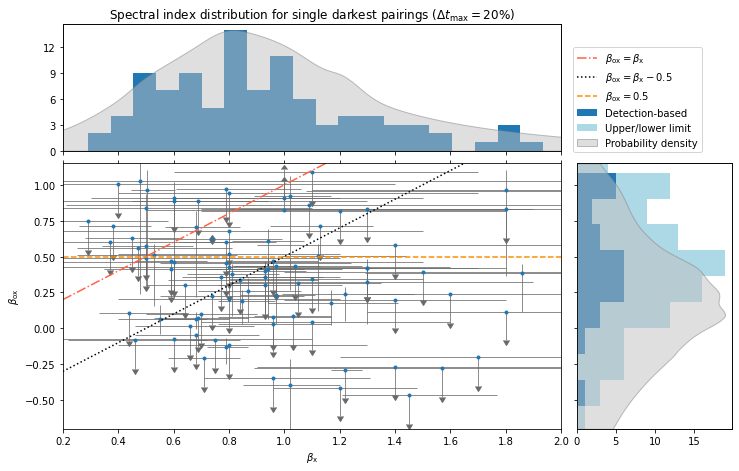

In [39]:
fig = plt.figure(figsize=(12,10))
grid = plt.GridSpec(4, 4, hspace=0.1, wspace=0.1)

ax_main = fig.add_subplot(grid[1:-1, 0:-1])
ax_right = fig.add_subplot(grid[1:-1, -1], yticklabels=[])#, xticklabels=[])
ax_top = fig.add_subplot(grid[0, 0:-1], xticklabels=[])#, yticklabels=[])

x = np.linspace(0.2,2,500)
y = np.linspace(-.7,1.15,500)
X,Y = np.meshgrid(x,y)

ax_main.errorbar(b_x,b_ox,xerr=[xminus,xplus],yerr=[oxminus,oxplus],
                 uplims=oxuplims,lolims=oxlolims,zorder=0,
                 linestyle="",marker=".",
                 ecolor="dimgrey",elinewidth=0.75,capthick=1)
# scatter = ax_main.scatter(b_x,b_ox,c=np.log10(t_obs),cmap="PuBu",vmin=-1,marker=".",zorder=1)
ax_main.plot(x,x,linestyle="-.",color="tomato",label=r"$\beta_\mathrm{ox}=\beta_\mathrm{x}$")
ax_main.plot(x,x-.5,"k:",label=r"$\beta_\mathrm{ox}=\beta_\mathrm{x}-0.5$")
ax_main.plot(x,[.5]*len(x),linestyle="--",color="darkorange",label=r"$\beta_\mathrm{ox}=0.5$")
ax_main.set(xlim=(x.min(),x.max()),ylim=(y.min(),y.max()),
            xlabel=r"$\beta_\mathrm{x}$",ylabel=r"$\beta_\mathrm{ox}$")
ax_main.xaxis.set_ticks_position("both")

ax_kde_x = ax_top.twinx()
valid_bx = UncertaintyArray([entry for entry in darkest_times["B_x"] if pd.notna(entry.value)])
ax_kde_x.fill_between(x,valid_bx.pdf(x),facecolor="silver",edgecolor="grey",alpha=.5)
ax_kde_x.set_ylim(0,)
ax_kde_x.set(yticks=[])
ax_top.hist(b_x,22,orientation='vertical', color="C0")
ax_top.set(xlim=ax_main.get_xlim(),yticks=range(0,14,3))

ax_kde_y = ax_right.twiny()
valid_box = UncertaintyArray()
for i,row in darkest_times.iterrows():
    if np.isfinite(row[B_ox_name].minus):
        neg = row[B_ox_name].minus
    else:
        neg = 0.5
    if np.isfinite(row[B_ox_name].plus):
        pos = row[B_ox_name].plus
    else:
        pos = 0.5
    if np.isfinite(row[B_ox_name].value):
        valid_box.append(AsymmetricUncertainty(row[B_ox_name].value,pos,neg))
ax_kde_y.fill_betweenx(y,valid_box.pdf(y),alpha=.5,
                       facecolor="silver",edgecolor="grey",label="Probability density")
ax_kde_y.set_xlim(0,)
ax_kde_y.set(xticks=[])
ax_right.hist([[b.value for b in darkest_times[B_ox_name] if all(np.isfinite(b.items()))],
               [b.value for b in darkest_times[B_ox_name] if not all(np.isfinite(b.items()))]],
              19, orientation='horizontal', stacked=True, color=["C0","lightblue"],
              label=["Detection-based","Upper/lower limit"])
ax_right.set(ylim=(ax_main.get_ylim()))
ax_right.set_xlim(0,)

# Z_x = np.sum([bx.pdf(X) for bx in valid_bx],axis=0)
# Z_x /= np.sum(Z_x)
# Z_ox = np.sum([box.pdf(Y) for box in valid_box],axis=0)
# Z_ox /= np.sum(Z_ox)
# ax_main.contourf(X,Y,np.sqrt(Z_x**2+Z_ox**2),30,cmap="Greys",vmax=4e-5,vmin=0)

fig.legend(loc="lower left",bbox_to_anchor=(0.71,0.695))
# fig.colorbar(scatter,ax=ax_right,label=r"$\log_{10}(t_\mathrm{o}\ \mathrm{[s]})$")

ax_top.set_title(r"Spectral index distribution for single darkest pairings ($\Delta t_\mathrm{max}="+"{:.0%}$%)".format(max_dt))

plt.savefig("./products/beta_distributions.png",dpi=300,bbox_inches="tight")

plt.show()

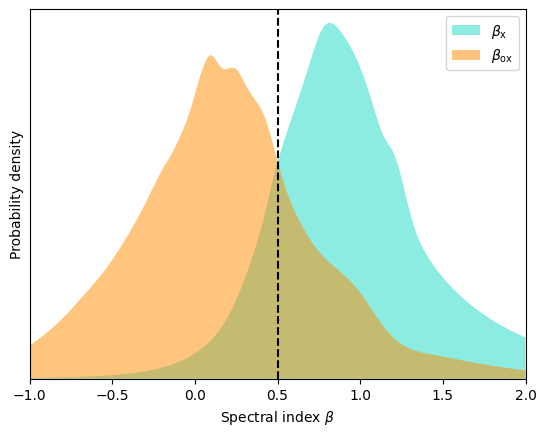

In [170]:
x = np.linspace(-1,2,500)
# for box in valid_bx:
#     plt.plot(x,box.pdf(x),"k-",linewidth=0.4)
#     if any(box.pdf(x)>6):
#         print(box)
# plt.yticks([])
# plt.ylim(0,15)
# plt.twinx()

plt.fill_between(x,valid_bx.pdf(x),fc="turquoise",alpha=.6,label=r"$\beta_\mathrm{x}$")
plt.fill_between(x,valid_box.pdf(x),fc="darkorange",alpha=.5,label=r"$\beta_\mathrm{ox}$")
plt.axvline(0.5,linestyle="--",color="k")
plt.legend()
plt.ylim(0,100)
plt.xlabel(r"Spectral index $\beta$")
plt.xlim(x.min(),x.max())
plt.yticks([])
plt.ylabel("Probability density")

plt.savefig("./products/beta_comparison.png",dpi=300,bbox_inches="tight")
plt.show()

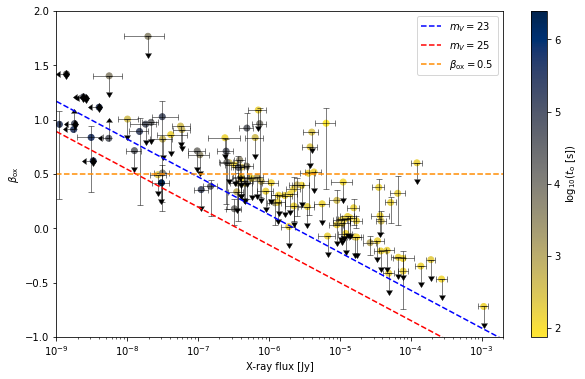

In [40]:
fig = plt.figure(figsize=(10,6))
b_ox = [b.value for b in darkest_times[B_ox_name]]
oxplus = [0.15 if notvalid(v.plus) else v.plus for v in darkest_times[B_ox_name]]
oxminus = [0.15 if notvalid(v.minus) else v.minus for v in darkest_times[B_ox_name]]
oxuplims = [notvalid(v.minus) for v in darkest_times[B_ox_name]]
Fx = [f.value for f in darkest_times["F_x"]]
Fxplus = [v.value*0.2 if notvalid(v.plus) else v.plus for v in darkest_times["F_x"]]
Fxminus = [v.value*0.2 if notvalid(v.minus) else v.minus for v in darkest_times["F_x"]]
Fxuplims = [notvalid(v.minus) for v in darkest_times["F_x"]]
plt.scatter(Fx,b_ox,c=np.log10(darkest_times["t_o"]),cmap="cividis_r")
plt.errorbar(Fx,b_ox,xerr=[Fxminus,Fxplus],yerr=[oxminus,oxplus],uplims=oxuplims,lolims=oxlolims,
             xuplims=Fxuplims,elinewidth=0.5,capsize=3,capthick=0.5,color="k",linestyle="",marker="")
plt.colorbar(label=r"$\log_{10}(t_\mathrm{o}\ \mathrm{[s]})$")
fx = np.linspace(1e-9,2e-3,10)
box_m23 = -np.log10(fx/(3631*10**(-23/2.5)))/np.log10(4.18794e17/5.539986e14)
box_m25 = -np.log10(fx/(3631*10**(-25/2.5)))/np.log10(4.18794e17/5.539986e14)
plt.plot(fx,box_m23,"b--",label="$m_V=23$")
plt.plot(fx,box_m25,"r--",label="$m_V=25$")
plt.axhline(0.5,linestyle="--",color="darkorange",label=r"$\beta_\mathrm{ox}=0.5$")
plt.xlim(fx.min(),fx.max())
plt.ylim(-1,2)
plt.legend()
plt.xscale("log")
plt.ylabel(r"$\beta_\mathrm{ox}$")
plt.xlabel("X-ray flux [Jy]")
plt.savefig("./products/Fx-Box.png",dpi=300,bbox_inches="tight")
plt.show()

In [314]:
dark11hrFx = UncertaintyArray()
notdark11hrFx = UncertaintyArray()
for grb in results["GRB"].unique():
    print(grb,end=" ")
    try:
        Fx11hr = interp_xray_flux(grb,11*60*60)
        print('success')
    except ValueError:
        try:
            lc = xrt_data[(xrt_data["GRB"]==grb) & np.isfinite(xrt_data["Fluxneg"])].copy().reset_index()
            last_time = AsymmetricUncertainty(*np.abs(lc.loc[np.argmin(np.abs(lc["Time"]-11*60*60)),["Time","Tpos","Tneg"]]))
            last_flux = AsymmetricUncertainty(*lc.loc[np.argmin(np.abs(lc["Time"]-11*60*60)),["Flux","Fluxpos","Fluxneg"]])
            alpha = get_temporalIndex(grb,last_time)
            dt = 11*60*60 - last_time
            A = last_flux/(last_time**-alpha)
            Fx11hr = A*(11*60*60)**-alpha
            print(last_flux,"->",Fx11hr)
        except:
            print("failed")
            continue
    if grb in dark["GRB"].tolist():
        dark11hrFx.append(Fx11hr)
    else:
        notdark11hrFx.append(Fx11hr)

210410A success
210323A success
201006A 6.96703021e-13 ± 1.183287441e-13 -> 3.464479585728353e-14 ± 5.168384733807875e-14
200907B 1.21804848e-12 ± 2.35849488e-13 -> 5.599697294200655e-16 ± 8.369959648187023e-16
200826A 8.96295456e-13 ± 2.216090394e-13 -> 1.3107930087308966e-12 ± 3.899002853930534e-12
200716C success
200522A success
200411A 3.780113316e-13 ± 7.30480164e-14 -> 2.7585075024265504e-13 ± 2.681797896867286e-13
200219A 8.90589164e-14 ± 2.0835866420000002e-14 -> 8.37018564712601e-16 ± 1.9592676665977593e-15
191031D 2.940896273e-14 ± 1.379377624e-14 -> 1.1957458585488575e-15 ± 2.84086147005878e-15
190719C success
190627A success
181123B 1.868211287e-13 ± 3.88428342e-14 -> 1.207177119416174e-14 ± 1.4280171990995336e-14
180727A success
180618A success
180418A success
180402A failed
180204A success
170827A 1.3378059e-09 ± 2.2729815e-10 -> 3.933816412743405e-12 ± 3.3980345896035797e-12
170822A success
170728B success
170728A success
170127B 1.135321164e-12 ± 2.712109884e-13 -> 1.02

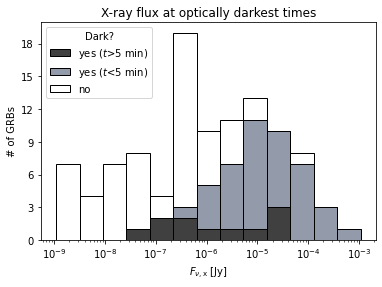

In [41]:
darkest_times["Fx"] = UncertaintyArray(darkest_times["F_x"]).values
darkest_times["dark"] = (darkest_times["vdH_dark"]|darkest_times["Jak_dark"])
for i,entry in darkest_times.iterrows():
    if entry["dark"]:
        if entry["t_o"]>300:
            darkest_times.loc[i,"dark"] = 2
        else:
            darkest_times.loc[i,"dark"] = 1
    else:
        darkest_times.loc[i,"dark"] = 0
sns.histplot(data=darkest_times,x="Fx",hue="dark",palette="bone_r",
             bins=13,log_scale=True,multiple="stack",edgecolor="k")
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(3))
plt.xlabel(r"$F_{\nu,\mathrm{x}}$ [Jy]")
plt.ylabel("# of GRBs")
plt.title("X-ray flux at optically darkest times")
plt.legend(labels=["yes ($t$>5 min)","yes ($t$<5 min)","no"],title="Dark?")
plt.savefig("./products/Fx_hist.png",dpi=300,bbox_inches="tight")
plt.show()

### Extinction/absorption analysis

In [17]:
from code.xrt import grb_list
sGRBs["N_H (intrinsic)"] = np.nan
sGRBs["N_H (intrinsic)"] = [AsymmetricUncertainty(nh) if pd.notna(nh) else np.nan for nh in sGRBs["N_H (intrinsic)"]]
for i in sGRBs.index:
    grb = sGRBs.loc[i,"GRB"]
    print(grb,end=": ")
    if pd.notna(sGRBs.loc[i,"N_H (intrinsic)"]):
        print("already present")
        continue
    try:
        sGRBs.loc[i,"N_H (intrinsic)"],mode = get_columnDensity(grb,sGRBs)
        print(f"retrieved ({mode} mode)")
    except AssertionError:
        print("info doesn't exist")
    except ValueError:
        print("couldn't be parsed")
    except TypeError:
        print("trigger not found")

211227A: retrieved (PC mode)
211221A: retrieved (PC mode)
211207A: retrieved (PC mode)
211106A: retrieved (PC mode)
211023B: retrieved (PC mode)
210919A: retrieved (PC mode)
210726A: retrieved (PC mode)
210725B: retrieved (PC mode)
210708A: retrieved (PC mode)
210704A: retrieved (PC mode)
210618A: retrieved (PC mode)
210413B: info doesn't exist
210410A: retrieved (PC mode)
210323A: retrieved (PC mode)
210217A: retrieved (PC mode)
210119A: info doesn't exist
201221D: retrieved (PC mode)
201015A: retrieved (PC mode)
201006A: retrieved (PC mode)
200917A: retrieved (PC mode)
200907B: retrieved (PC mode)
200826A: retrieved (PC mode)
200729A: retrieved (PC mode)
200716C: retrieved (PC mode)
200623A: info doesn't exist
200522A: retrieved (PC mode)
200517A: retrieved (PC mode)
200512A: retrieved (PC mode)
200411A: retrieved (PC mode)
200409A: retrieved (PC mode)
200219A: retrieved (PC mode)
191031D: retrieved (PC mode)
190719C: retrieved (PC mode)
190627A: retrieved (PC mode)
190610A: info doe

Text(0.5, 1.0, 'Hydrogen column densities by category')

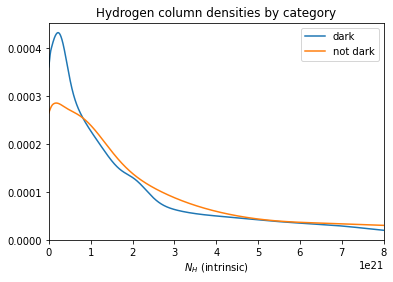

In [323]:
dark_nh = sGRBs.loc[sGRBs["GRB"].isin(dark["GRB"]) & sGRBs["N_H (intrinsic)"].notna(), "N_H (intrinsic)"]
# dark_nh = [v for v in dark_nh if v.value>0]
notdark_nh = sGRBs.loc[~sGRBs["GRB"].isin(dark["GRB"]) & sGRBs["N_H (intrinsic)"].notna(), "N_H (intrinsic)"]
# notdark_nh = [v for v in notdark_nh if v.value>0]
max_x = 8e21
x = np.linspace(0,max_x,10000)
p_NH_dark = np.sum([nh.pdf(x) for nh in dark_nh],axis=0)
plt.plot(x,p_NH_dark/np.sum(p_NH_dark),label="dark")
p_NH_notdark = np.sum([nh.pdf(x) for nh in notdark_nh],axis=0)
plt.plot(x,p_NH_notdark/np.sum(p_NH_notdark),label="not dark")
plt.xlabel("$N_H$ (intrinsic)")
plt.xlim(0,max_x)
plt.ylim(0)
plt.legend()
plt.title("Hydrogen column densities by category")
# plt.savefig("./products/NH_dists.png",dpi=300,bbox_inches="tight",facecolor="white",transparent=False)

Text(0.5, 1.0, 'Cumulative distributions of Hydrogen column density')

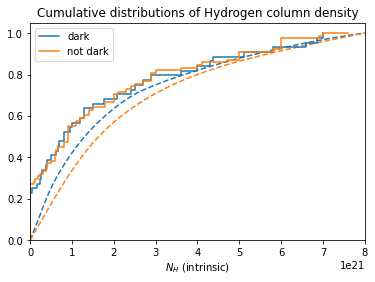

In [321]:
plt.plot(x,np.cumsum(p_NH_dark)/np.sum(p_NH_dark),color="tab:blue",linestyle="--")
plt.plot(x,np.cumsum(p_NH_notdark)/np.sum(p_NH_notdark),color="tab:orange",linestyle="--")
x1 = np.sort([v.value for v  in dark_nh if v.value<max_x])
plt.step(x1, np.linspace(0, 1, len(x1)), where="pre", label="dark")
x2 = np.sort([v.value for v  in notdark_nh if v.value<max_x])
plt.step(x2, np.linspace(0, 1, len(x2)), where="pre", label="not dark")
plt.xlabel("$N_H$ (intrinsic)")
plt.xlim(0,max_x)
plt.ylim(0)
plt.legend()
plt.title("Cumulative distributions of Hydrogen column density")

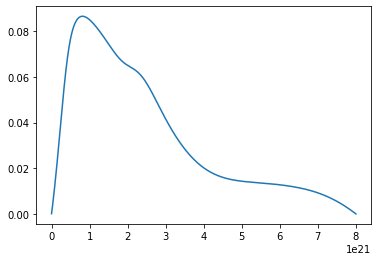

In [324]:
plt.plot(x,np.cumsum(p_NH_dark)/np.sum(p_NH_dark)-np.cumsum(p_NH_notdark)/np.sum(p_NH_notdark))

In [325]:
stats.ks_2samp(sGRBs.loc[~sGRBs["GRB"].isin(dark["GRB"]) & sGRBs["N_H (intrinsic)"].notna(), "N_H (intrinsic)"],
               sGRBs.loc[sGRBs["GRB"].isin(dark["GRB"]) & sGRBs["N_H (intrinsic)"].notna(), "N_H (intrinsic)"])

KstestResult(statistic=0.10408163265306122, pvalue=0.8217943134832417)

In [327]:
comparison_table = pd.DataFrame(columns=["GRB","nu_o","F_o","nu_x","F_x","B_x","B_ox","N_H","Dark"])

for i,row in darkest_times.iterrows():
    grb = row["GRB"]
    b_ox = row[B_ox_name]
    b_x = row["B_x"]
    t_o = row["t_o"]
    flag = row["vdH_dark"] or row["Jak_dark"]
    try:
        n_h = sGRBs.loc[sGRBs["GRB"]==grb,"N_H (intrinsic)"].values[0]
    except IndexError:
        continue
#     n_h = (AsymmetricUncertainty(n_h)+1)/1e21 - 1e-21
    if np.isfinite(b_ox.minus):
        neg = b_ox.minus
    else:
        neg = 1
    if np.isfinite(b_ox.plus):
        pos = b_ox.plus
    else:
        pos = 1
    if np.isfinite(b_ox.value) and np.isfinite(b_x.value):
        comparison_table = comparison_table.append({"GRB":grb,"t_o":t_o,"nu_o":row["nu_o"],"F_o":row["F_o"],
                                                    "nu_x":row["nu_x"],"F_x":row["F_x"],"B_x":b_x,
                                                    "B_ox":AsymmetricUncertainty(b_ox.value,pos,neg),
                                                    "N_H":n_h,"Dark":flag},ignore_index=True)

comparison_table

GRB          nu_o                                             F_o  \
0   210410A  8.514533e+14              1.896435366219928e-05 (+0.0, -inf)   
1   210323A  7.715315e+14              2.563308796098916e-05 (+0.0, -inf)   
2   201006A  7.715315e+14              0.0006668452230788575 (+0.0, -inf)   
3   200907B  7.715315e+14             0.00011276729182535795 (+0.0, -inf)   
4   200826A  7.715315e+14    4.051214492769071e-06 ± 4.85069837177718e-07   
..      ...           ...                                             ...   
94   060427  4.735452e+14             1.6030766349889176e-06 (+0.0, -inf)   
95   060313  5.480667e+14                              5.5e-05 ± 1.88e-05   
96   060121  4.612192e+14                               1.1e-06 ± 3.3e-07   
97  051221A  4.758610e+14                              1.56e-05 ± 1.2e-06   
98   050724  3.811927e+14  3.563785812706925e-05 ± 1.6411840173925271e-06   

                                                 nu_x  \
0   4.1880632448032506e+17 (+1.9991731172900093e+1...   
1   4.1880632448032506e+17 (+1.9991731172900093e+1...   
2   4.1880632448032506e+17 (+1.9991731172900093e+1...   
3   4.1880632448032506e+17 (+1.9991731172900093e+1...   
4   4.1880632448032506e+17 (+1.9991731172900093e+1...   
..                                                ...   
94  4.1880632448032506e+17 (+1.9991731172900093e+1...   
95  4.1880632448032506e+17 (+1.9991731172900093e+1...   
96  4.1880632448032506e+17 (+1.9991731172900093e+1...   
97  4.1880632448032506e+17 (+1.9991731172900093e+1...   
98  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                  F_x  \
0        3.854022893284991e-07 ± 7.00824756079806e-08   
1      1.3922226974815335e-05 ± 3.120230778601041e-06   
2   7.063938154844077e-07 (+2.1232658339496227e-07...   
3      4.323644582195267e-06 ± 1.1261491867362311e-06   
4     1.4870471936736438e-08 ± 4.7163621126729474e-09   
..                                                ...   
94    1.2608960676787186e-08 ± 2.9669358710195416e-09   
95  1.5715689796351337e-05 (+3.2204751708184446e-0...   
96      3.2467407100320857e-07 ± 7.73561730947887e-08   
97       2.54380389493966e-07 ± 5.822660323437297e-08   
98     2.4824393126761855e-07 ± 6.601694551012292e-08   

                                   B_x  \
0    0.4499999999999999 (+0.18, -0.17)   
1                            0.7 ± 0.2   
2                     1.1 (+0.6, -0.5)   
3                            0.8 ± 0.4   
4      0.6000000000000001 (+0.7, -0.6)   
..                                 ...   
94                 1.13 (+0.19, -0.18)   
95  0.8460000000000001 (+0.12, -0.087)   
96                 1.17 (+0.24, -0.23)   
97                         0.94 ± 0.13   
98   0.6799999999999999 (+0.16, -0.11)   

                                                 B_ox  \
0     0.6285722665573303 (+0.08879908244386428, -1.0)   
1      0.0969379230400152 (+0.1010984371082567, -1.0)   
2     1.0878787981994062 (+0.15198114436633936, -1.0)   
3     0.5179193728034049 (+0.13141213465665275, -1.0)   
4   0.8905168749703297 (+0.1277894092486439, -0.67...   
..                                                ...   
94    0.7141240740155758 (+0.10995739412822128, -1.0)   
95  0.18869070573800314 (+0.08067170212970823, -0....   
96  0.17915013836032706 (+0.0897908415379748, -0.1...   
97  0.6071050733931347 (+0.0821552715693223, -0.42...   
98  0.7093476329543233 (+0.11128852010308485, -0.4...   

                               N_H   Dark       t_o  
0           4e+20 (+6e+20, -4e+20)  False    4861.5  
1   1.76e+21 (+1.02e+21, -8.9e+20)   True     164.0  
2           8e+21 (+7e+21, -5e+21)  False     163.0  
3     1.4e+21 (+2.9e+21, -1.4e+21)  False     158.5  
4     1.5e+21 (+3.4e+21, -1.5e+21)  False  155180.0  
..                             ...    ...       ...  
94                   9e+20 ± 5e+20  False   33300.0  
95          5e+19 (+3e+20, -5e+19)   True     162.0  
96          8e+20 (+6e+20, -5e+20)   

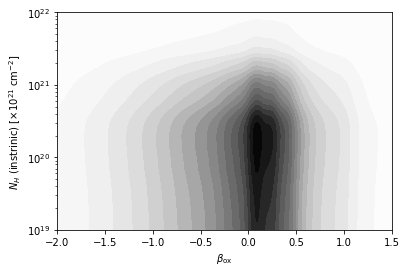

In [328]:
x,y = np.linspace(-2,1.5,250),np.linspace(0,10e21,150)
X,Y = np.meshgrid(x,y)
Z1 = np.sum([box.pdf(X) for box in comparison_table["B_ox"]],axis=0)
Z2 = np.sum([NH.pdf(Y) for NH in comparison_table["N_H"]],axis=0)
plt.contourf(X,Y,Z1*Z2,25,cmap="Greys")
plt.yscale("log")
plt.ylim(0.01e21,10e21)
plt.xlabel(r"$\beta_\mathrm{ox}$")
plt.ylabel(r"$N_H$ (instrinic) [$\times10^{21}$ cm$^{-2}$]")
# plt.colorbar(label="Probability density")
plt.savefig("./products/B_ox-N_H.png",dpi=300,bbox_inches="tight",facecolor="white")

error term: $\sigma_{\beta_x} \cdot \frac{-2.5}{\ln(10)}(\ln(\nu_o) - \ln(\nu_x))$

error term: $\sigma_{F_x} \cdot -\frac{2.5}{\ln(10)F_x}$

$$ \sigma_{m_\text{AB}} =  \sqrt{\left(\sigma_{\beta_x} \cdot \frac{-2.5}{\ln(10)}(\ln(\nu_o) - \ln(\nu_x))\right)^2 + \left(\sigma_{F_x} \cdot -\frac{2.5}{\ln(10)F_x}\right)^2} $$

In [329]:
E_x = log_mean(0.3,10)
nu_x = E_x*241797944177033445
# nu_x = AsymmetricUncertainty(nu_x,10-nu_x,nu_x-0.3)
ABmag = lambda flux : -2.5*np.log10(flux/3631)

for i,row in comparison_table.iterrows():
    A_Bx = row["F_x"]/(nu_x**-row["B_x"])
    A_Bx05 = row["F_x"]/(nu_x**-(row["B_x"]-0.5))
    optflux_BoxBx = A_Bx*nu_o**-row["B_x"]
    optflux_BoxBx05 = A_Bx05*nu_o**-(row["B_x"]-0.5)
    
    obs_mag = ABmag(row["F_o"])
    
    m_plus = np.sqrt((row["B_x"].minus*-2.5/np.log(10) * (np.log(row["nu_o"])-np.log(row["nu_x"].value)))**2 + \
                     (row["F_x"].plus*-2.5/np.log(10)/row["F_x"].value)**2)
    m_minus = np.sqrt((row["B_x"].plus*-2.5/np.log(10) * (np.log(row["nu_o"])-np.log(row["nu_x"].value)))**2 + \
                      (row["F_x"].minus*-2.5/np.log(10)/row["F_x"].value)**2)
    
    unext_mag = AsymmetricUncertainty(ABmag(optflux_BoxBx),m_plus,m_minus)
    Av = obs_mag - unext_mag
    if np.isinf(Av.minus):
        Av.minus = 10
    comparison_table.loc[i,"Av (B_ox=B_x)"] = Av
    
    unext_mag = AsymmetricUncertainty(ABmag(optflux_BoxBx05),m_plus,m_minus)
    Av = obs_mag - unext_mag
    if np.isinf(Av.minus):
        Av.minus = 10
    comparison_table.loc[i,"Av (B_ox=B_x-0.5)"] = Av
    
    print(obs_mag,unext_mag,obs_mag-unext_mag)

20.7052205078125 (+0.0, -inf) 25.32017810862307 (+1.160948319706097, -1.2271302730460396) -4.614957600810573 (+1.2271302730460396, -inf)
20.37806330272135 (+0.0, -inf) 19.501201001595355 ± 1.3888131752443829 0.8768623011259962 (+1.3888131752443829, -inf)
16.84000301111537 (+0.0, -inf) 19.658669863000597 (+3.4338674235472233, -4.11319352553129) -2.818666851885226 (+4.11319352553129, -inf)
18.76960774549636 (+0.0, -inf) 20.001051387250442 ± 2.749242692838718 -1.2314436417540833 (+2.749242692838718, -inf)
22.381102528171716 ± 0.13000000000000003 27.699457319880757 (+4.116417992698036, -4.796246349010359) -5.318354791709041 (+4.79800781995978, -4.118470236702959)
17.079726698535083 ± 0.2 24.20429743640074 (+0.49013590994275835, -0.8103626095253392) -7.124570737865657 (+0.8346781169509102, -0.5293705792877195)
21.180472512073592 (+0.0, -inf) 26.305846901111384 (+1.8706297226645852, -3.020741648681666) -5.125374389037791 (+3.020741648681666, -inf)
21.520315008049064 (+0.0, -inf) 19.802968742

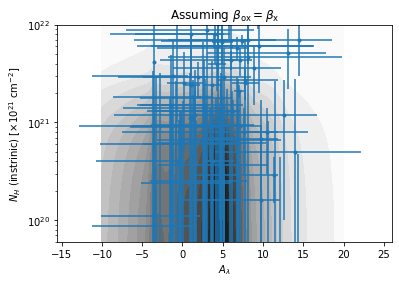

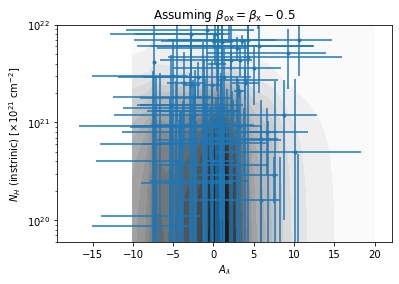

In [342]:
x,y = np.linspace(-10,20,250),np.linspace(0,10e22,150)
X,Y = np.meshgrid(x,y)
NH = UncertaintyArray(comparison_table["N_H"])
Av = UncertaintyArray(comparison_table["Av (B_ox=B_x)"])
Z1 = Av.pdf(X)
Z2 = NH.pdf(Y)
plt.contourf(X,Y,Z1*Z2,25,cmap="binary")
plt.errorbar(Av.values,NH.values,xerr=(Av.minus,Av.plus),yerr=[NH.minus,NH.plus],marker=".",linestyle="")
plt.yscale("log")
plt.ylim(0.06e21,10e21)
plt.xlabel(r"$A_\lambda$")
plt.ylabel(r"$N_H$ (instrinic) [$\times10^{21}$ cm$^{-2}$]")
plt.title(r"Assuming $\beta_\mathrm{ox}=\beta_\mathrm{x}$")
plt.show()

Av = UncertaintyArray(comparison_table["Av (B_ox=B_x-0.5)"])
Z1 = Av.pdf(X)
Z2 = NH.pdf(Y)
plt.contourf(X,Y,Z1*Z2,25,cmap="binary")
plt.errorbar(Av.values,NH.values,xerr=(Av.minus,Av.plus),yerr=[NH.minus,NH.plus],marker=".",linestyle="")
plt.yscale("log")
plt.ylim(0.06e21,10e21)
plt.xlabel(r"$A_\lambda$")
plt.ylabel(r"$N_H$ (instrinic) [$\times10^{21}$ cm$^{-2}$]")
plt.title(r"Assuming $\beta_\mathrm{ox}=\beta_\mathrm{x}-0.5$")
plt.show()

(-5.0, 10.0)

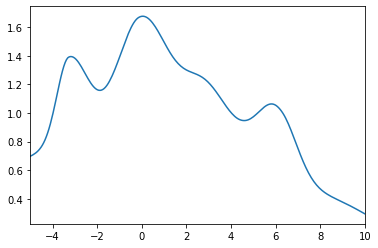

In [82]:
Z = np.sum([row["Av (B_ox=B_x)"].pdf(x) for i,row in comparison_table.iterrows() if (all(np.isfinite(row["Av (B_ox=B_x)"].items())) and row["t_o"]>1000)],axis=0)
plt.plot(x,Z)
plt.xlim(x.min(),x.max())

### Observation depth over time

150301A


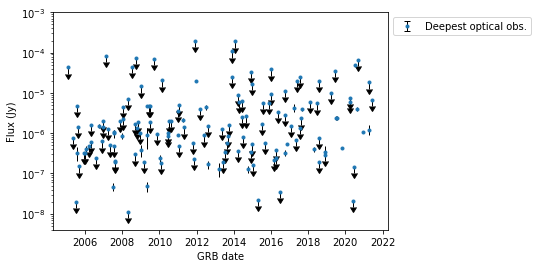

In [42]:
fig = plt.figure()
datestamps = []
deepests = []
for grb,opt in all_optical.dropna(subset=["Flux (Jy)"]).groupby("GRB"):
    yy = grb[:2]
    mm = grb[2:4]
    dd = grb[4:6]
    deepest_obs = min(opt["Flux (Jy)"])
    if deepest_obs>1e-1:
        print(grb)
    if pd.notna(deepest_obs):
        datestamps.append(mm+"/"+dd+"/20"+yy)
        deepests.append(deepest_obs)
datestamps = pd.to_datetime(datestamps)
vals = [v.value for v in deepests]
pos = [0.3*v.value if np.isinf(v.plus) else v.plus for v in deepests]
neg = [0.3*v.value if np.isinf(v.minus) else v.minus for v in deepests]
plt.errorbar(datestamps,[d.value for d in deepests],yerr=(neg,pos),linestyle="",marker=".",
             ecolor="k",elinewidth=1,label="Deepest optical obs.",
             uplims=[np.isinf(point.minus) for point in deepests],
                lolims=[np.isinf(point.plus) for point in deepests],capsize=0)
#plt.plot(df.Date,df.Value,":",label=r"Log regression (R$^2=%.2f$)"%(r*r))
plt.yscale("log")
plt.ylim(4e-9,1e-3)
plt.ylabel("Flux (Jy)")
plt.xlabel("GRB date")
plt.legend(loc="upper left",bbox_to_anchor=(1,1))
plt.show()
fig.savefig("./products/deepest_flux_over_time.png",bbox_inches="tight",dpi=300)

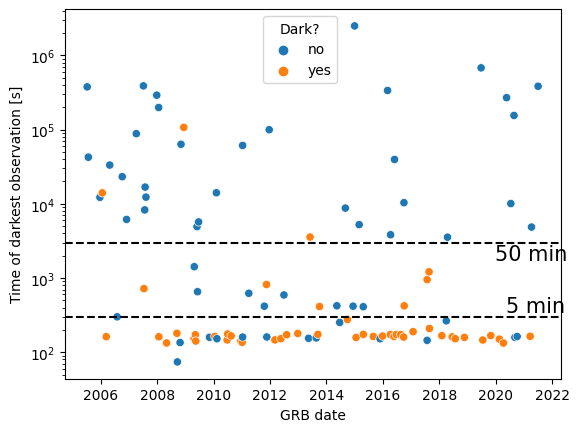

In [50]:
fig,ax = plt.subplots()
datestamps = []
darkest_t = []
cs = []

for grb,data in results.groupby("GRB"):
    yy = grb[:2]
    mm = grb[2:4]
    dd = grb[4:6]
#     data = data[data["t_o"]>500]
    try:
        datestamps.append(mm+"/"+dd+"/20"+yy)
        point = data.loc[data[B_ox_name]==data[B_ox_name].min(),:]
        darkest_t.append(float(point["t_o"]))
        if all(point["Jak_dark"]) or all(point["vdH_dark"]):
            cs.append("yes")
        else:
            cs.append("no")
    except:
        continue

datestamps = pd.to_datetime(datestamps)
sns.scatterplot(x="Date",y="Time",hue="Dark?",palette="tab10",
                data=pd.DataFrame(zip(datestamps,darkest_t,cs),
                                  columns=["Date","Time","Dark?"]))
plt.axhline(300,linestyle="--",color="k")
plt.text(18400,350,"5 min",size=15)
plt.axhline(3000,linestyle="--",color="k")
plt.text(18250,1750,"50 min",size=15)
plt.xlabel("GRB date")
plt.ylabel("Time of darkest observation [s]")
# plt.rcParams['legend.title_fontsize'] = 14
plt.legend(title="Dark?",loc="upper center",bbox_to_anchor=(.475,1))
plt.yscale("log")
# plt.ylim(4e2,4e6)
plt.savefig("./products/darkest_time_over_time.png",dpi=300,bbox_inches="tight")
plt.show()

### Time distributions of dark vs. not dark observation pairs

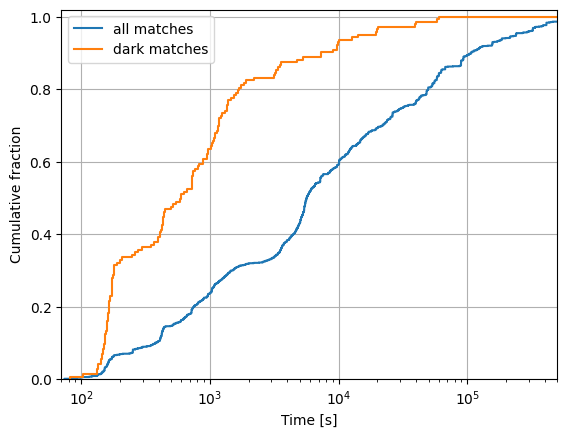

In [54]:
plt.step(close_times["t_o"].sort_values(ascending=True),np.linspace(0,1,len(close_times)),label="all matches")
plt.step(close_times.loc[close_times["vdH_dark"]|close_times["Jak_dark"],"t_o"].sort_values(ascending=True),np.linspace(0,1,sum(close_times["vdH_dark"]|close_times["Jak_dark"])),label="dark matches")
plt.legend()
plt.xscale("log")
plt.xlim(70,5e5)
plt.ylim(0,1.02)
plt.ylabel("Cumulative fraction")
plt.xlabel("Time [s]")
plt.grid()

KstestResult(statistic=0.5913604305864885, pvalue=4.440892098500626e-16)

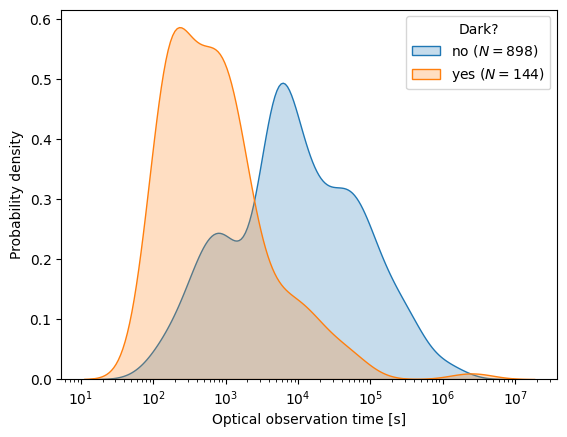

In [56]:
sns.kdeplot(data=close_times[~(close_times["vdH_dark"]|close_times["Jak_dark"])],x="t_o",
            fill=True,log_scale=True,bw_adjust=1.1,
            label="no ($N=%d$)"%sum(~(close_times["vdH_dark"]|close_times["Jak_dark"])))
sns.kdeplot(data=close_times[close_times["vdH_dark"]|close_times["Jak_dark"]],x="t_o",
            fill=True,log_scale=True,bw_adjust=1.1,
            label="yes ($N=%d$)"%sum(close_times["vdH_dark"]|close_times["Jak_dark"]))
plt.legend(title="Dark?")
plt.xlabel("Optical observation time [s]")
plt.ylabel("Probability density")
plt.savefig("./products/t_o_dist_split.png",dpi=300,bbox_inches="tight")
stats.ks_2samp(close_times.loc[(close_times["vdH_dark"]|close_times["Jak_dark"]), "t_o"],
               close_times.loc[~(close_times["vdH_dark"]|close_times["Jak_dark"]), "t_o"],)

### $T_{90}$ sample

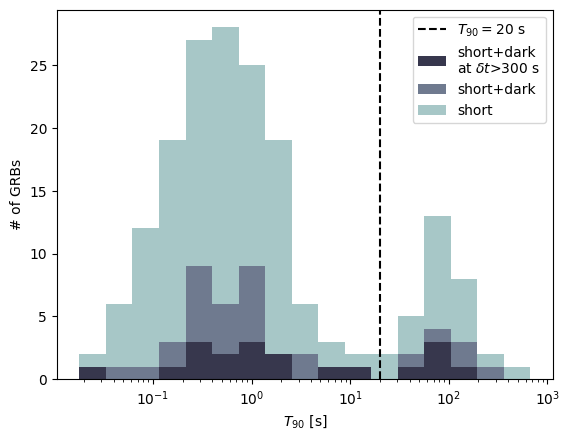

In [64]:
ee_cut = 20
early_cut = 300
for i,row in sGRBs.iterrows():
    grb = row["GRB"].strip()
    if grb in dark["GRB"].values:
        if len(dark[(dark["GRB"]==grb) & (dark["t_o"]>=early_cut)]):
            sGRBs.loc[i,"flag"] = "short+dark+late"
        else:
            sGRBs.loc[i,"flag"] = "short+dark"
    else:
        sGRBs.loc[i,"flag"] = "short"

sns.histplot(data=sGRBs,x="T90",hue="flag",log_scale=True,bins=17,multiple="stack",palette="bone_r",alpha=1,
             element="step",fill=True,edgecolor="none")
plt.axvline(ee_cut,linestyle="--",color="k")
# plt.xticks(ticks=range(-2,4), labels=["$10^{%d}$"%int(i) for i in range(-2,4)])
plt.xlabel("$T_{90}$ [s]")
plt.ylabel("# of GRBs")
plt.legend(labels=["$T_{90}=20$ s",f"short+dark\nat $\delta t$>{early_cut} s","short+dark","short"])
plt.savefig("./products/T90hist.png",dpi=300,bbox_inches="tight",facecolor="white",transparent=False)

In [65]:
ee_cut = 20
split_20s = [len(sGRBs.loc[sGRBs["GRB"].isin(dark.loc[dark["t_o"]>=early_cut,"GRB"]) & (sGRBs["T90"]>ee_cut)]),
             len(sGRBs.loc[sGRBs["GRB"].isin(dark["GRB"]) & (sGRBs["T90"]>ee_cut)]),
             len(sGRBs.loc[sGRBs["T90"]>ee_cut]),
             len(sGRBs.loc[sGRBs["GRB"].isin(dark.loc[dark["t_o"]>=early_cut,"GRB"]) & (sGRBs["T90"]<=ee_cut)]),
             len(sGRBs.loc[sGRBs["GRB"].isin(dark["GRB"]) & (sGRBs["T90"]<=ee_cut)]),
             len(sGRBs.loc[sGRBs["T90"]<=ee_cut])]
ee_cut = 2
split_2s = [len(sGRBs.loc[sGRBs["GRB"].isin(dark.loc[dark["t_o"]>=early_cut,"GRB"]) & (sGRBs["T90"]>ee_cut)]),
            len(sGRBs.loc[sGRBs["GRB"].isin(dark["GRB"]) & (sGRBs["T90"]>ee_cut)]),
            len(sGRBs.loc[sGRBs["T90"]>ee_cut]),
            len(sGRBs.loc[sGRBs["GRB"].isin(dark.loc[dark["t_o"]>=early_cut,"GRB"]) & (sGRBs["T90"]<=ee_cut)]),
            len(sGRBs.loc[sGRBs["GRB"].isin(dark["GRB"]) & (sGRBs["T90"]<=ee_cut)]),
            len(sGRBs.loc[sGRBs["T90"]<=ee_cut])]
print(pd.DataFrame(np.array(split_20s+split_2s).reshape(3,4,order="F"),columns=["T90>20","T90<=20","T90>2","T90<=2"],index=["dark/late","dark","short"]).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  T90>20 &  T90<=20 &  T90>2 &  T90<=2 \\
\midrule
dark/late &       5 &       14 &      7 &      12 \\
dark      &      10 &       36 &     14 &      32 \\
short     &      29 &      151 &     48 &     132 \\
\bottomrule
\end{tabular}



### Numbers

6.176470588235294 ± 0.47150645711415873 short bursts per year
2.9411764705882355 ± 0.39733106135606755 dark short bursts per year


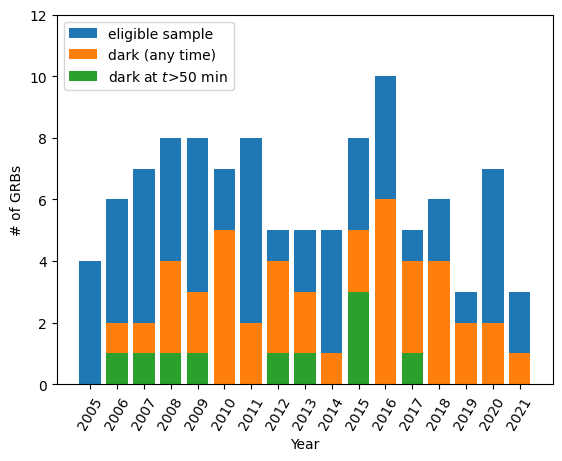

In [66]:
from code.utilities import addYear
addYear(sGRBs)
addYear(close_times)
addYear(all_optical)
addYear(results)
addYear(dark)

dark_year_counts = {}
darklate_counts = {}
all_year_counts = {}

for year in range(2005,2022):
    sample = dark[dark["Year"]==year]
    dark_year_counts[str(year)] = len(sample["GRB"].unique())
        
for year in range(2005,2022):
    sample = results[results["Year"]==year]
    all_year_counts[str(year)] = len(sample["GRB"].unique())

for year in range(2005,2022):
    sample = dark[(dark["Year"]==year) & (dark["t_o"]>50*60)]
    darklate_counts[str(year)] = len(sample["GRB"].unique())

plt.bar(all_year_counts.keys(),all_year_counts.values(),label="eligible sample")
plt.bar(dark_year_counts.keys(),dark_year_counts.values(),label="dark (any time)")
plt.bar(darklate_counts.keys(),darklate_counts.values(),label="dark at $t$>50 min")
plt.xlabel("Year")
plt.ylabel("# of GRBs")
plt.legend()
plt.xticks(rotation=60)
plt.ylim(0,12)
print(np.mean(list(all_year_counts.values())),"±",stats.sem(list(all_year_counts.values())),"short bursts per year")
print(np.mean(list(dark_year_counts.values())),"±",stats.sem(list(dark_year_counts.values())),"dark short bursts per year")
plt.savefig("./products/numbers.png",dpi=300,bbox_inches="tight")
plt.show()

In [67]:
close_times["time class"] = ["early" if t<300 else "mid" if (t>=300 and t<3000) else "late" if t>=3000 \
                             else None for t in close_times["t_o"]]
ct = pd.crosstab(close_times["time class"],close_times["Jak_dark"]|close_times["vdH_dark"],
                 rownames=["time"],colnames=["dark"])
display(ct)
chisq,p,dof,E = stats.chi2_contingency(ct)
chisq,p,dof

dark   False  True 
time               
early     39     52
late     671     25
mid      188     67

(237.7544048833747, 2.3566058719614945e-52, 2)

In [68]:
conf = np.zeros((5,5))
tables = (sGRBs,xrt_data,all_optical,results,dark)
names = ["main","xray","optical","matched","dark"]
for grb in sGRBs["GRB"].tolist():
    for i in range(5):
        for j in range(5):
            if j>i:
                conf[i,j] = np.nan
            elif grb in tables[i].GRB.tolist() and grb in tables[j].GRB.tolist():
                conf[i,j] += 1
conf 

array([[195.,  nan,  nan,  nan,  nan],
       [165., 165.,  nan,  nan,  nan],
       [159., 139., 159.,  nan,  nan],
       [102., 102., 102., 102.,  nan],
       [ 50.,  50.,  50.,  50.,  50.]])

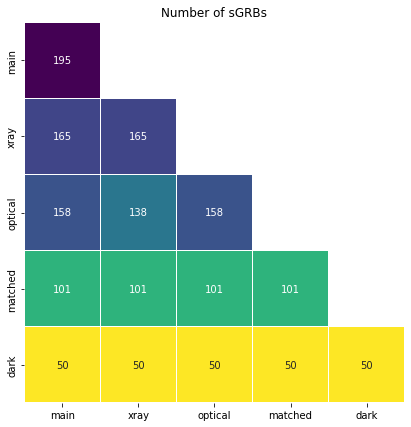

In [140]:
fig,ax = plt.subplots(figsize=(7,7))
sns.heatmap(data=conf,annot=True,fmt="g",
            cmap="viridis_r",cbar=False,
            xticklabels=names,
            yticklabels=names,
            square=True,linewidths=0.1,ax=ax)
for label in ax.yaxis.get_ticklabels():
    label.set_verticalalignment('center')
plt.title("Number of sGRBs")
plt.show()

### Violin plots

(10, 10000000.0)

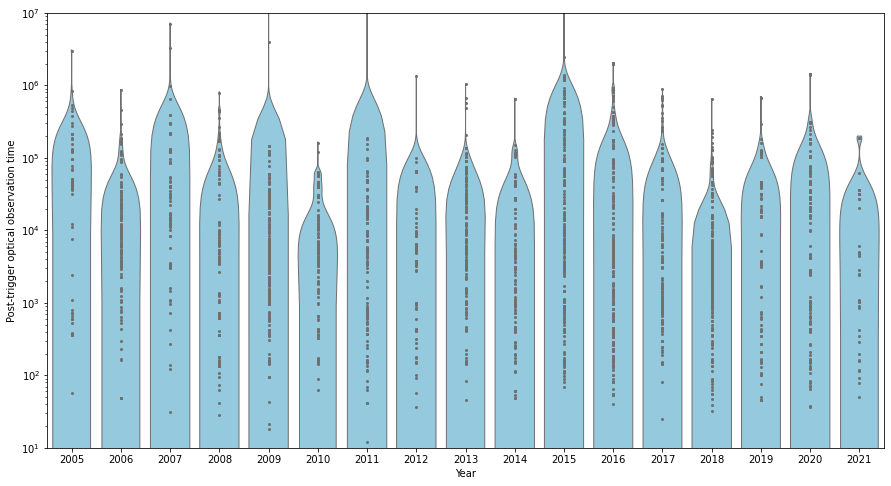

In [599]:
fig,ax = plt.subplots(figsize=(15,8))
sns.violinplot(x="Year",y="Time (s)",data=all_optical,linewidth=1,color="skyblue",
               scale="width",cut=.5,inner="point",ax=ax)
plt.ylabel("Post-trigger optical observation time")
plt.yscale("log")
plt.ylim(10,1e7)

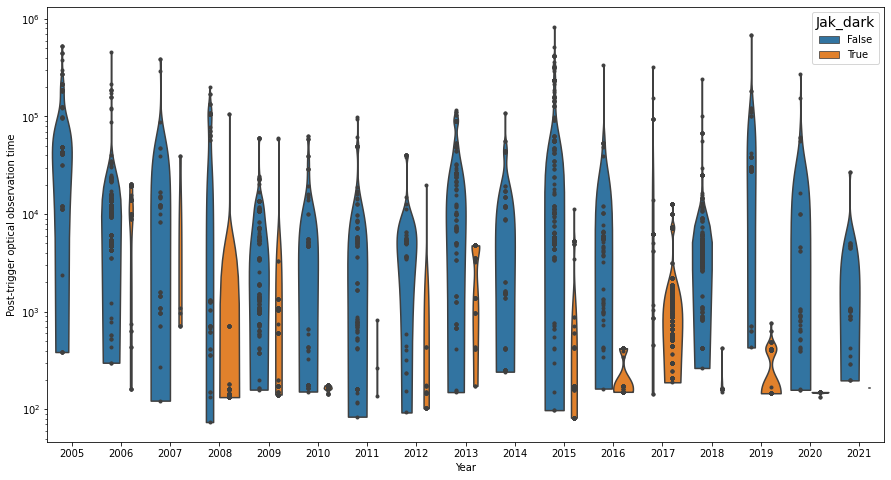

In [35]:
fig,ax = plt.subplots(figsize=(15,8))
sns.violinplot(x="Year",y="t_o",data=results[(results["t_o"]<1e6) & (results["Year"]>2004)],
               scale="count",inner="point",cut=0,hue="Jak_dark",split=False,ax=ax)
plt.ylabel("Post-trigger optical observation time")
plt.yscale("log")
#plt.ylim(1,1e5)

## Optical spectra

In [48]:
for grb,data in results.groupby("GRB"):
    done = []
    for t_o in data["t_o"].unique():
        tmatch = data[np.abs(data["t_o"]-t_o)/t_o < 0.1].copy()
        for to,obs in tmatch.groupby("t_o"):
            tmatch.drop(tmatch[tmatch["dt%"]!=tmatch["dt%"].min()].index,axis=0,inplace=True)
        if t_o not in done and len(tmatch["nu_o"].unique()) > 2:
                print(grb,t_o)
                display(tmatch)
                done += tmatch["t_o"].unique().tolist()

060121 9000.0


GRB     t_o       dt%          nu_o  \
3490  060121  9720.0  0.116364  4.863784e+14   
3491  060121  9720.0  0.116364  4.863784e+14   
3492  060121  9720.0  0.116364  4.863784e+14   
3493  060121  9720.0  0.116364  4.863784e+14   
3494  060121  9720.0  0.116364  4.863784e+14   
3500  060121  9720.0  0.116364  3.916501e+14   
3501  060121  9720.0  0.116364  3.916501e+14   
3502  060121  9720.0  0.116364  3.916501e+14   
3503  060121  9720.0  0.116364  3.916501e+14   
3504  060121  9720.0  0.116364  3.916501e+14   
3510  060121  9720.0  0.116364  2.935631e+14   
3511  060121  9720.0  0.116364  2.935631e+14   
3512  060121  9720.0  0.116364  2.935631e+14   
3513  060121  9720.0  0.116364  2.935631e+14   
3514  060121  9720.0  0.116364  2.935631e+14   
3520  060121  9720.0  0.116364  3.372244e+14   
3521  060121  9720.0  0.116364  3.372244e+14   
3522  060121  9720.0  0.116364  3.372244e+14   
3523  060121  9720.0  0.116364  3.372244e+14   
3524  060121  9720.0  0.116364  3.372244e+14   

                                      F_o  \
3490  3.7239072180869405e-06 (+0.0, -inf)   
3491  3.7239072180869405e-06 (+0.0, -inf)   
3492  3.7239072180869405e-06 (+0.0, -inf)   
3493  3.7239072180869405e-06 (+0.0, -inf)   
3494  3.7239072180869405e-06 (+0.0, -inf)   
3500   4.873884834658412e-06 (+0.0, -inf)   
3501   4.873884834658412e-06 (+0.0, -inf)   
3502   4.873884834658412e-06 (+0.0, -inf)   
3503   4.873884834658412e-06 (+0.0, -inf)   
3504   4.873884834658412e-06 (+0.0, -inf)   
3510   8.410891167436347e-06 (+0.0, -inf)   
3511   8.410891167436347e-06 (+0.0, -inf)   
3512   8.410891167436347e-06 (+0.0, -inf)   
3513   8.410891167436347e-06 (+0.0, -inf)   
3514   8.410891167436347e-06 (+0.0, -inf)   
3520                   1.08e-05 ± 2.5e-06   
3521                   1.08e-05 ± 2.5e-06   
3522                   1.08e-05 ± 2.5e-06   
3523                   1.08e-05 ± 2.5e-06   
3524                   1.08e-05 ± 2.5e-06   

                                                   nu_x  \
3490  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3491  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3492  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3493  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3494  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3500  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3501  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3502  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3503  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3504  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3510  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3511  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3512  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3513  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3514  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3520  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3521  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3522  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3523  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3524  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                  F_x  \
3490                                6.1e-07 ± 1.4e-07   
3491                                4.2e-07 ± 9.5e-08   
3492  4.5000000000000003e-07 ± 1.0000000000000001e-07   
3493                 4.6999999999999995e-07 ± 1.1e-07   
3494                 3.4000000000000003e-07 ± 8.7e-07   
3500                                6.1e-07 ± 1.4e-07   
3501                                4.2e-07 ± 9.5e-08   
3502  4.5000000000000003e-07 ± 1.0000000000000001e-07   
3503                 4.6999999999999995e-07 ± 1.1e-07   
3504                 3.4000000000000003e-07 ± 8.7e-07   
3510                                6.1e-07 ± 1.4e-07   
3511                                4.2e-07 ± 9.5e-08   
3512  4.5000000000000003e-07 ± 1.0000000000000001e-07   
3513            

080503 620.0


GRB    t_o       dt%          nu_o  \
3168  080503  620.0  0.123748  6.361576e+14   
3169  080503  620.0  0.123748  4.626870e+14   
3170  080503  620.0  0.123748  3.821188e+14   

                                      F_o  \
3168  0.00013164354645135812 (+0.0, -inf)   
3169   8.539105490522088e-05 (+0.0, -inf)   
3170  0.00022789739450369243 (+0.0, -inf)   

                                                   nu_x  \
3168  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3169  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3170  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                              F_x  \
3168  1.0110433739701649e-07 ± 2.297938039451e-08   
3169  1.0110433739701649e-07 ± 2.297938039451e-08   
3170  1.0110433739701649e-07 ± 2.297938039451e-08   

                                                 B_ox    α  \
3168  1.1050866413669602 (+0.14467013193440337, -inf)  8.0   
3169  0.9898254392685115 (+0.12432396480109532, -inf)  8.0   
3170   1.103017708565408 (+0.13389709922806223, -inf)  8.0   

                                           B_ox_w_err  \
3168  1.1050866413669602 (+0.43039424861514924, -inf)   
3169  0.9898254392685115 (+0.42398845549253483, -inf)   
3170    1.103017708565408 (+0.4268936581266706, -inf)   

                                    B_x Jak_dark vdH_dark  Year  
3168  1.4500000000000002 (+0.32, -0.24)    False    False  2008  
3169  1.4500000000000002 (+0.32, -0.24)    False    False  2008  
3170  1.4500000000000002 (+0.32, -0.24)    False    False  2008

080913 180.0


GRB    t_o       dt%          nu_o  \
3019  080913  180.0  0.004001  4.916258e+14   
3020  080913  180.0  0.004001  3.942179e+14   
3021  080913  180.0  0.004001  3.357390e+14   

                                     F_o  \
3019  2.121749687386341e-06 (+0.0, -inf)   
3020  2.472131557899378e-06 (+0.0, -inf)   
3021         4.219450020502084e-06 ± 0.0   

                                                   nu_x  \
3019  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3020  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3021  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                F_x  \
3019  1.903896944943868e-06 ± 4.415637365634573e-07   
3020  1.903896944943868e-06 ± 4.415637365634573e-07   
3021  1.903896944943868e-06 ± 4.415637365634573e-07   

                                                   B_ox    α  \
3019  0.01605618847209473 (+0.033966781132171324, -inf)  1.2   
3020   0.03748108498254906 (+0.03313499678972337, -inf)  1.2   
3021  0.11163150427182805 (+0.03460854883856727, -0....  1.2   

                                             B_ox_w_err  \
3019   0.01605618847209473 (+0.03403045409397591, -inf)   
3020   0.03748108498254906 (+0.03320026502328483, -inf)   
3021  0.11163150427182805 (+0.034671043221582876, -0...   

                                   B_x Jak_dark vdH_dark  Year  
3019  0.6599999999999999 (+0.23, -0.2)     True    False  2008  
3020  0.6599999999999999 (+0.23, -0.2)     True    False  2008  
3021  0.6599999999999999 (+0.23, -0.2)     True    False  2008

080913 360.0


GRB    t_o       dt%          nu_o  \
3022  080913  360.0  0.090916  2.455797e+14   
3023  080913  360.0  0.090916  1.838814e+14   
3024  080913  360.0  0.090916  1.369818e+14   

                                      F_o  \
3022   0.0005394043662051895 (+0.0, -inf)   
3023  0.00048688466512590166 (+0.0, -inf)   
3024   0.0017573716758739568 (+0.0, -inf)   

                                                   nu_x  \
3022  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3023  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3024  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
3022  1.0871714979756532e-06 ± 2.577277212404609e-07   
3023  1.0871714979756532e-06 ± 2.577277212404609e-07   
3024  1.0871714979756532e-06 ± 2.577277212404609e-07   

                                                 B_ox    α  \
3022  0.8340860037015736 (+0.09786142192508118, -inf)  1.2   
3023  0.7896194722319819 (+0.08970857648510752, -inf)  1.2   
3024  0.9205862265650239 (+0.09922308685231154, -inf)  1.2   

                                           B_ox_w_err  \
3022  0.8340860037015736 (+0.10785842933373392, -inf)   
3023  0.7896194722319819 (+0.10051970738181493, -inf)   
3024  0.9205862265650239 (+0.10909538872767571, -inf)   

                                   B_x Jak_dark vdH_dark  Year  
3022  0.6599999999999999 (+0.23, -0.2)    False    False  2008  
3023  0.6599999999999999 (+0.23, -0.2)    False    False  2008  
3024  0.6599999999999999 (+0.23, -0.2)    False    False  2008

080913 720.0


GRB    t_o       dt%          nu_o  \
3028  080913  720.0  0.087132  6.655414e+14   
3030  080913  720.0  0.087132  4.916258e+14   
3032  080913  720.0  0.087132  3.942179e+14   
3034  080913  720.0  0.087132  3.357390e+14   
3036  080913  720.0  0.087132  2.447983e+14   
3038  080913  720.0  0.087132  1.835816e+14   
3040  080913  720.0  0.087132  1.391121e+14   

                                                  F_o  \
3028              1.7379058652234989e-06 (+0.0, -inf)   
3030              1.7379058652234989e-06 (+0.0, -inf)   
3032               2.291006117807585e-06 (+0.0, -inf)   
3034     3.5647267811055704e-06 ± 4.9248520480622e-07   
3036   1.5849889868640448e-05 ± 8.758972832910923e-07   
3038  1.9589630703524253e-05 ± 1.6238444988669629e-06   
3040  2.2081381896430282e-05 ± 4.2709179061440324e-06   

                                                   nu_x  \
3028  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3030  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3032  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3034  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3036  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3038  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3040  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
3028  3.1524048793554437e-07 ± 7.501152180985261e-08   
3030  3.1524048793554437e-07 ± 7.501152180985261e-08   
3032  3.1524048793554437e-07 ± 7.501152180985261e-08   
3034  3.1524048793554437e-07 ± 7.501152180985261e-08   
3036  3.1524048793554437e-07 ± 7.501152180985261e-08   
3038  3.1524048793554437e-07 ± 7.501152180985261e-08   
3040  3.1524048793554437e-07 ± 7.501152180985261e-08   

                                                   B_ox    α  \
3028   0.26489000672688745 (+0.04983506698980007, -inf)  1.2   
3030    0.2529994851385232 (+0.04661666694478352, -inf)  1.2   
3032    0.284634977772599 (+0.047718095625235796, -inf)  1.2   
3034  0.3402391403389642 (+0.05494124585817459, -0.2...  1.2   
3036  0.5262222241705741 (+0.06682880308734643, -0.3...  1.2   
3038  0.5340339423580948 (+0.06556209647062891, -0.3...  1.2   
3040  0.5304888899837922 (+0.06664551984915405, -0.3...  1.2   

                                             B_ox_w_err  \
3028   0.26489000672688745 (+0.06617518208200589, -inf)   
3030      0.2529994851385232 (+0.063786632288824, -inf)   
3032     0.284634977772599 (+0.06459595553754059, -inf)   
3034  0.3402391403389642 (+0.07010107929381086, -0.2...   
3036  0.5262222241705741 (+0.07976032687869387, -0.3...   
3038  0.5340339423580948 (+0.07870202866084726, -0.3...   
3040  0.5304888899837922 (+0.07960682218046868, -0.3...   

                                   B_x Jak_dark vdH_dark  Year  
3028  0.6599999999999999 (+0.23, -0.2)     True    False  2008  
3030  0.6599999999999999 (+0.23, -0.2)     True    False  2008  
3032  0.6599999999999999 (+0.23, -0.2)     True    False  2008  
3034  0.6599999999999999 (+0.23, -0.2)     True    False  2008  
3036  0.6599999999999999 (+0.23, -0.2)    False    False  2008  
3038  0.6599999999999999 (+0.23, -0.2)    False    False  2008  
3040  0.6599999999999999 (+0.23, -0.2)    False    False  2008

090423 13716.864000000001


GRB        t_o       dt%          nu_o  \
2986  090423  13716.864  0.124212  6.361576e+14   
2993  090423  13716.864  0.124212  4.626870e+14   
3000  090423  13716.864  0.124212  3.821188e+14   

                                      F_o  \
2986  2.7524086323556257e-05 (+0.0, -inf)   
2993   3.204197770117918e-05 (+0.0, -inf)   
3000   6.010115310236266e-05 (+0.0, -inf)   

                                                   nu_x  \
2986  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2993  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3000  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2986  1.123057848924482e-07 ± 2.9678819485253674e-08   
2993  1.123057848924482e-07 ± 2.9678819485253674e-08   
3000  1.123057848924482e-07 ± 2.9678819485253674e-08   

                                                B_ox     α  \
2986  0.847739734882957 (+0.11542435421285616, -inf)  1.41   
2993   0.830417564370326 (+0.1080604544762866, -inf)  1.41   
3000  0.8975812153941012 (+0.1125469306595297, -inf)  1.41   

                                           B_ox_w_err          B_x Jak_dark  \
2986   0.847739734882957 (+0.13587887920961053, -inf)  0.71 ± 0.13    False   
2993   0.830417564370326 (+0.12968172612757223, -inf)  0.71 ± 0.13    False   
3000  0.8975812153941012 (+0.13344324587886056, -inf)  0.71 ± 0.13    False   

     vdH_dark  Year  
2986    False  2009  
2993    False  2009  
3000    False  2009

090426 376.704


GRB      t_o       dt%          nu_o  \
2817  090426  376.704  0.088658  6.361576e+14   
2819  090426  376.704  0.088658  4.626870e+14   
2821  090426  376.704  0.088658  3.821188e+14   

                                                F_o  \
2817  0.0002900574494604127 ± 2.137222269566145e-05   
2819   0.0004541036146342407 ± 3.34595908394085e-05   
2821    0.0006495271153159908 ± 5.9823658128881e-05   

                                                   nu_x  \
2817  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2819  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2821  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                  F_x  \
2817  1.9067051798127283e-06 ± 4.2987684486984494e-07   
2819  1.9067051798127283e-06 ± 4.2987684486984494e-07   
2821  1.9067051798127283e-06 ± 4.2987684486984494e-07   

                                                   B_ox     α  \
2817  0.7742559346880049 (+0.10515512911583419, -0.5...  0.94   
2819  0.8038862677674623 (+0.10362029645527401, -0.5...  0.94   
2821  0.8330486864883209 (+0.10433901938502343, -0.5...  0.94   

                                             B_ox_w_err                  B_x  \
2817  0.7742559346880049 (+0.11072563169201569, -0.5...  0.96 (+0.16, -0.15)   
2819  0.8038862677674623 (+0.10926907234760906, -0.5...  0.96 (+0.16, -0.15)   
2821  0.8330486864883209 (+0.1099508767607446, -0.57...  0.96 (+0.16, -0.15)   

     Jak_dark vdH_dark  Year  
2817    False    False  2009  
2819    False    False  2009  
2821    False    False  2009

090426 964.224


GRB       t_o       dt%          nu_o  \
2846  090426  1035.072  0.014465  6.361576e+14   
2849  090426  1035.072  0.014465  4.626870e+14   
2852  090426  1035.072  0.014465  3.821188e+14   

                                                 F_o  \
2846  6.523550426659195e-05 ± 1.8626077157617312e-05   
2849  8.187568733739936e-05 ± 2.0360779611307614e-05   
2852  0.00017889462245997354 ± 4.283968945288582e-05   

                                                   nu_x  \
2846  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2849  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2852  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                F_x  \
2846  5.478940951090471e-07 ± 1.262003838027628e-07   
2849  5.478940951090471e-07 ± 1.262003838027628e-07   
2852  5.478940951090471e-07 ± 1.262003838027628e-07   

                                                   B_ox     α  \
2846  0.7365000297957721 (+0.10950500635973141, -0.5...  0.94   
2849  0.7354277515246661 (+0.10221589606917719, -0.5...  0.94   
2852  0.8269913854324535 (+0.1085776081541656, -0.56...  0.94   

                                             B_ox_w_err                  B_x  \
2846  0.7365000297957721 (+0.109661844571703, -0.544...  0.96 (+0.16, -0.15)   
2849  0.7354277515246661 (+0.10238390081574526, -0.5...  0.96 (+0.16, -0.15)   
2852  0.8269913854324535 (+0.10873578403406607, -0.5...  0.96 (+0.16, -0.15)   

     Jak_dark vdH_dark  Year  
2846    False    False  2009  
2849    False    False  2009  
2852    False    False  2009

090426 5040.0


GRB       t_o       dt%          nu_o  \
2899  090426  5480.352  0.020503  6.361576e+14   
2902  090426  5480.352  0.020503  4.626870e+14   
2905  090426  5480.352  0.020503  3.821188e+14   

                                                 F_o  \
2899   2.6211026155413417e-05 ± 9.17367395082486e-06   
2902  4.2968971527745086e-05 ± 8.706694770494286e-06   
2905    6.14606693826714e-05 ± 1.981257895763646e-05   

                                                   nu_x  \
2899  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2902  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2905  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2899  1.3680813654310403e-07 ± 3.642941631008612e-08   
2902  1.3680813654310403e-07 ± 3.642941631008612e-08   
2905  1.3680813654310403e-07 ± 3.642941631008612e-08   

                                                   B_ox     α  \
2899  0.8097973394603906 (+0.12340032416090582, -0.5...  0.94   
2902  0.8445297429445892 (+0.11369727557595544, -0.5...  0.94   
2905  0.8725812324595142 (+0.11910155347210366, -0.5...  0.94   

                                             B_ox_w_err                  B_x  \
2899  0.8097973394603906 (+0.1236781658597461, -0.59...  0.96 (+0.16, -0.15)   
2902  0.8445297429445892 (+0.11399876833022794, -0.5...  0.96 (+0.16, -0.15)   
2905  0.8725812324595142 (+0.11938939964202264, -0.5...  0.96 (+0.16, -0.15)   

     Jak_dark vdH_dark  Year  
2899    False    False  2009  
2902    False    False  2009  
2905    False    False  2009

090426 5760.0


GRB       t_o       dt%          nu_o  \
2899  090426  5480.352  0.020503  6.361576e+14   
2902  090426  5480.352  0.020503  4.626870e+14   
2905  090426  5480.352  0.020503  3.821188e+14   

                                                 F_o  \
2899   2.6211026155413417e-05 ± 9.17367395082486e-06   
2902  4.2968971527745086e-05 ± 8.706694770494286e-06   
2905    6.14606693826714e-05 ± 1.981257895763646e-05   

                                                   nu_x  \
2899  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2902  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2905  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2899  1.3680813654310403e-07 ± 3.642941631008612e-08   
2902  1.3680813654310403e-07 ± 3.642941631008612e-08   
2905  1.3680813654310403e-07 ± 3.642941631008612e-08   

                                                   B_ox     α  \
2899  0.8097973394603906 (+0.12340032416090582, -0.5...  0.94   
2902  0.8445297429445892 (+0.11369727557595544, -0.5...  0.94   
2905  0.8725812324595142 (+0.11910155347210366, -0.5...  0.94   

                                             B_ox_w_err                  B_x  \
2899  0.8097973394603906 (+0.1236781658597461, -0.59...  0.96 (+0.16, -0.15)   
2902  0.8445297429445892 (+0.11399876833022794, -0.5...  0.96 (+0.16, -0.15)   
2905  0.8725812324595142 (+0.11938939964202264, -0.5...  0.96 (+0.16, -0.15)   

     Jak_dark vdH_dark  Year  
2899    False    False  2009  
2902    False    False  2009  
2905    False    False  2009

090426 7200.0


GRB     t_o      dt%          nu_o  \
2914  090426  7200.0  0.04132  3.757363e+14   
2918  090426  7200.0  0.04132  4.673887e+14   
2922  090426  7200.0  0.04132  5.505123e+14   
2926  090426  7200.0  0.04132  4.163784e+14   

                                                F_o  \
2914  7.949221981227501e-05 ± 4.392902408370009e-06   
2918  2.893310868754059e-05 ± 5.329675580632599e-07   
2922  1.5630692105522657e-05 ± 5.75855978165699e-07   
2926                             2.46e-05 ± 3.9e-06   

                                                   nu_x  \
2914  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2918  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2922  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2926  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2914  8.770752409196573e-08 ± 2.3297121213128358e-08   
2918  8.770752409196573e-08 ± 2.3297121213128358e-08   
2922  8.770752409196573e-08 ± 2.3297121213128358e-08   
2926  8.770752409196573e-08 ± 2.3297121213128358e-08   

                                                   B_ox     α  \
2914  0.9705157538514715 (+0.12069646347029996, -0.6...  0.94   
2918  0.8530055786032785 (+0.11085890313044564, -0.6...  0.94   
2922  0.7812388003580433 (+0.10538116392544472, -0.5...  0.94   
2926  0.815279884549556 (+0.10724219591114781, -0.56...  0.94   

                                             B_ox_w_err                  B_x  \
2914  0.9705157538514715 (+0.12182302526321022, -0.6...  0.96 (+0.16, -0.15)   
2918  0.8530055786032785 (+0.1120843860371677, -0.60...  0.96 (+0.16, -0.15)   
2922  0.7812388003580433 (+0.10666959688835781, -0.5...  0.96 (+0.16, -0.15)   
2926  0.815279884549556 (+0.10850853318466853, -0.56...  0.96 (+0.16, -0.15)   

     Jak_dark vdH_dark  Year  
2914    False    False  2009  
2918    False    False  2009  
2922    False    False  2009  
2926    False    False  2009

110106A 8317.5


GRB       t_o       dt%          nu_o  \
2582  110106A  8584.704  0.131444  6.361576e+14   
2583  110106A  8584.704  0.131444  4.626870e+14   
2584  110106A  8584.704  0.131444  3.821188e+14   

                                      F_o  \
2582   3.610102623089009e-05 (+0.0, -inf)   
2583  4.0324665023164604e-05 (+0.0, -inf)   
2584   8.144767535214837e-05 (+0.0, -inf)   

                                                   nu_x  \
2582  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2583  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2584  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                  F_x  \
2582  4.0613023643797727e-08 ± 1.2711438854735009e-08   
2583  4.0613023643797727e-08 ± 1.2711438854735009e-08   
2584  4.0613023643797727e-08 ± 1.2711438854735009e-08   

                                                 B_ox     α  \
2582     1.04626862051361 (+0.1417520858924979, -inf)  1.11   
2583   1.013589174375667 (+0.13139777819425336, -inf)  1.11   
2584  1.0863205719340059 (+0.13588772208844457, -inf)  1.11   

                                           B_ox_w_err        B_x Jak_dark  \
2582    1.04626862051361 (+0.15374585570132585, -inf)  1.5 ± 0.5    False   
2583   1.013589174375667 (+0.14425501864699544, -inf)  1.5 ± 0.5    False   
2584  1.0863205719340059 (+0.14835635242498094, -inf)  1.5 ± 0.5    False   

     vdH_dark  Year  
2582    False  2011  
2583    False  2011  
2584    False  2011

120804A 40249.439999999995


GRB       t_o       dt%          nu_o  \
2419  120804A  40249.44  0.043178  6.361576e+14   
2421  120804A  40249.44  0.043178  4.626870e+14   
2423  120804A  40249.44  0.043178  3.821188e+14   

                                      F_o  \
2419   8.022147818660016e-05 (+0.0, -inf)   
2421    6.87078586326926e-05 (+0.0, -inf)   
2423  0.00011603611367984676 (+0.0, -inf)   

                                                   nu_x  \
2419  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2421  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2423  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2419  1.8369754505165708e-08 ± 4.956214647375757e-09   
2421  1.8369754505165708e-08 ± 4.956214647375757e-09   
2423  1.8369754505165708e-08 ± 4.956214647375757e-09   

                                                 B_ox      α  \
2419  1.2915571486591046 (+0.16968414926932468, -inf)  1.095   
2421  1.2083984399538599 (+0.15197536585438406, -inf)  1.095   
2423    1.25023728503006 (+0.15259899622738995, -inf)  1.095   

                                           B_ox_w_err                 B_x  \
2419  1.2915571486591046 (+0.17087078001922076, -inf)  0.96 (+0.21, -0.2)   
2421   1.2083984399538599 (+0.1532991349541685, -inf)  0.96 (+0.21, -0.2)   
2423    1.25023728503006 (+0.15391740187753122, -inf)  0.96 (+0.21, -0.2)   

     Jak_dark vdH_dark  Year  
2419    False    False  2012  
2421    False    False  2012  
2423    False    False  2012

121226A 3621.0


GRB       t_o       dt%          nu_o  \
2330  121226A  3743.712  0.147952  6.361576e+14   
2331  121226A  3743.712  0.147952  4.626870e+14   
2332  121226A  3743.712  0.147952  3.821188e+14   

                                     F_o  \
2330   3.57096118716993e-05 (+0.0, -inf)   
2331  3.366124705196544e-05 (+0.0, -inf)   
2332  6.231557414690432e-05 (+0.0, -inf)   

                                                   nu_x  \
2330  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2331  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2332  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                F_x  \
2330  9.076190564751554e-08 ± 2.680644949568071e-08   
2331  9.076190564751554e-08 ± 2.680644949568071e-08   
2332  9.076190564751554e-08 ± 2.680644949568071e-08   

                                                 B_ox     α  \
2330  0.9206772890969991 (+0.12581455551490522, -inf)  1.04   
2331  0.8689430854563214 (+0.11409591197826185, -inf)  1.04   
2332  0.9331795411056737 (+0.11803046160879098, -inf)  1.04   

                                           B_ox_w_err        B_x Jak_dark  \
2330  0.9206772890969991 (+0.14040353908743852, -inf)  1.4 ± 0.4    False   
2331   0.8689430854563214 (+0.1300066480569974, -inf)  1.4 ± 0.4    False   
2332  0.9331795411056737 (+0.13347299830470952, -inf)  1.4 ± 0.4    False   

     vdH_dark  Year  
2330    False  2012  
2331    False  2012  
2332    False  2012

130603B 43920.0


GRB      t_o       dt%          nu_o  \
2306  130603B  48222.0  0.003044  4.875221e+14   
2307  130603B  48222.0  0.003044  3.980626e+14   
2308  130603B  48222.0  0.003044  3.411380e+14   
2309  130603B  48222.0  0.003044  2.947018e+14   
2310  130603B  48222.0  0.003044  2.411140e+14   
2311  130603B  48222.0  0.003044  1.860597e+14   

                                                  F_o  \
2306   1.8467041630481676e-05 ± 5.102632172405707e-07   
2307   2.3198105676394787e-05 ± 6.409873477940062e-07   
2308  3.0929821070392294e-05 ± 1.4243708985131687e-06   
2309   3.909311382994146e-05 ± 1.8003044228708514e-06   
2310    3.782193109767061e-05 ± 2.090117153609863e-06   
2311    5.543684432520371e-05 ± 3.063553232300295e-06   

                                                   nu_x  \
2306  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2307  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2308  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2309  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2310  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2311  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                  F_x  \
2306  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2307  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2308  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2309  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2310  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2311  2.2546776018122463e-08 ± 5.2193438980126646e-09   

                                                   B_ox    α  \
2306  0.9929427727910082 (+0.12629745964193007, -0.7...  1.0   
2307  0.9967923134119577 (+0.12305813134006764, -0.6...  1.0   
2308  1.015606535995575 (+0.12260394563943981, -0.68...  1.0   
2309  1.027401035754334 (+0.12142665308775755, -0.67...  1.0   
2310  0.9953294612075222 (+0.11481140363912007, -0.6...  1.0   
2311  1.0114406539775094 (+0.11261521113185216, -0.6...  1.0   

                                             B_ox_w_err                  B_x  \
2306  0.9929427727910082 (+0.12630435934017228, -0.7...  0.97 (+0.14, -0.13)   
2307  0.9967923134119577 (+0.12306521265262474, -0.6...  0.97 (+0.14, -0.13)   
2308  1.015606535995575 (+0.12261105318316584, -0.68...  0.97 (+0.14, -0.13)   
2309  1.027401035754334 (+0.1214338295386464, -0.676...  0.97 (+0.14, -0.13)   
2310  0.9953294612075222 (+0.11481899355904215, -0.6...  0.97 (+0.14, -0.13)   
2311  1.0114406539775094 (+0.11262294905834268, -0.6...  0.97 (+0.14, -0.13)   

     Jak_dark vdH_dark  Year  
2306    False    False  2013  
2307    False    False  2013  
2308    False    False  2013  
2309    False    False  2013  
2310    False    False  2013  
2311    False    False  2013

130603B 51840.0


GRB      t_o       dt%          nu_o  \
2306  130603B  48222.0  0.003044  4.875221e+14   
2307  130603B  48222.0  0.003044  3.980626e+14   
2308  130603B  48222.0  0.003044  3.411380e+14   
2309  130603B  48222.0  0.003044  2.947018e+14   
2310  130603B  48222.0  0.003044  2.411140e+14   
2311  130603B  48222.0  0.003044  1.860597e+14   

                                                  F_o  \
2306   1.8467041630481676e-05 ± 5.102632172405707e-07   
2307   2.3198105676394787e-05 ± 6.409873477940062e-07   
2308  3.0929821070392294e-05 ± 1.4243708985131687e-06   
2309   3.909311382994146e-05 ± 1.8003044228708514e-06   
2310    3.782193109767061e-05 ± 2.090117153609863e-06   
2311    5.543684432520371e-05 ± 3.063553232300295e-06   

                                                   nu_x  \
2306  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2307  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2308  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2309  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2310  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2311  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                  F_x  \
2306  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2307  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2308  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2309  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2310  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2311  2.2546776018122463e-08 ± 5.2193438980126646e-09   

                                                   B_ox    α  \
2306  0.9929427727910082 (+0.12629745964193007, -0.7...  1.0   
2307  0.9967923134119577 (+0.12305813134006764, -0.6...  1.0   
2308  1.015606535995575 (+0.12260394563943981, -0.68...  1.0   
2309  1.027401035754334 (+0.12142665308775755, -0.67...  1.0   
2310  0.9953294612075222 (+0.11481140363912007, -0.6...  1.0   
2311  1.0114406539775094 (+0.11261521113185216, -0.6...  1.0   

                                             B_ox_w_err                  B_x  \
2306  0.9929427727910082 (+0.12630435934017228, -0.7...  0.97 (+0.14, -0.13)   
2307  0.9967923134119577 (+0.12306521265262474, -0.6...  0.97 (+0.14, -0.13)   
2308  1.015606535995575 (+0.12261105318316584, -0.68...  0.97 (+0.14, -0.13)   
2309  1.027401035754334 (+0.1214338295386464, -0.676...  0.97 (+0.14, -0.13)   
2310  0.9953294612075222 (+0.11481899355904215, -0.6...  0.97 (+0.14, -0.13)   
2311  1.0114406539775094 (+0.11262294905834268, -0.6...  0.97 (+0.14, -0.13)   

     Jak_dark vdH_dark  Year  
2306    False    False  2013  
2307    False    False  2013  
2308    False    False  2013  
2309    False    False  2013  
2310    False    False  2013  
2311    False    False  2013

130603B 52200.0


GRB      t_o       dt%          nu_o  \
2306  130603B  48222.0  0.003044  4.875221e+14   
2307  130603B  48222.0  0.003044  3.980626e+14   
2308  130603B  48222.0  0.003044  3.411380e+14   
2309  130603B  48222.0  0.003044  2.947018e+14   
2310  130603B  48222.0  0.003044  2.411140e+14   
2311  130603B  48222.0  0.003044  1.860597e+14   

                                                  F_o  \
2306   1.8467041630481676e-05 ± 5.102632172405707e-07   
2307   2.3198105676394787e-05 ± 6.409873477940062e-07   
2308  3.0929821070392294e-05 ± 1.4243708985131687e-06   
2309   3.909311382994146e-05 ± 1.8003044228708514e-06   
2310    3.782193109767061e-05 ± 2.090117153609863e-06   
2311    5.543684432520371e-05 ± 3.063553232300295e-06   

                                                   nu_x  \
2306  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2307  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2308  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2309  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2310  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2311  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                  F_x  \
2306  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2307  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2308  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2309  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2310  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2311  2.2546776018122463e-08 ± 5.2193438980126646e-09   

                                                   B_ox    α  \
2306  0.9929427727910082 (+0.12629745964193007, -0.7...  1.0   
2307  0.9967923134119577 (+0.12305813134006764, -0.6...  1.0   
2308  1.015606535995575 (+0.12260394563943981, -0.68...  1.0   
2309  1.027401035754334 (+0.12142665308775755, -0.67...  1.0   
2310  0.9953294612075222 (+0.11481140363912007, -0.6...  1.0   
2311  1.0114406539775094 (+0.11261521113185216, -0.6...  1.0   

                                             B_ox_w_err                  B_x  \
2306  0.9929427727910082 (+0.12630435934017228, -0.7...  0.97 (+0.14, -0.13)   
2307  0.9967923134119577 (+0.12306521265262474, -0.6...  0.97 (+0.14, -0.13)   
2308  1.015606535995575 (+0.12261105318316584, -0.68...  0.97 (+0.14, -0.13)   
2309  1.027401035754334 (+0.1214338295386464, -0.676...  0.97 (+0.14, -0.13)   
2310  0.9953294612075222 (+0.11481899355904215, -0.6...  0.97 (+0.14, -0.13)   
2311  1.0114406539775094 (+0.11262294905834268, -0.6...  0.97 (+0.14, -0.13)   

     Jak_dark vdH_dark  Year  
2306    False    False  2013  
2307    False    False  2013  
2308    False    False  2013  
2309    False    False  2013  
2310    False    False  2013  
2311    False    False  2013

130603B 52560.0


GRB      t_o       dt%          nu_o  \
2306  130603B  48222.0  0.003044  4.875221e+14   
2307  130603B  48222.0  0.003044  3.980626e+14   
2308  130603B  48222.0  0.003044  3.411380e+14   
2309  130603B  48222.0  0.003044  2.947018e+14   
2310  130603B  48222.0  0.003044  2.411140e+14   
2311  130603B  48222.0  0.003044  1.860597e+14   

                                                  F_o  \
2306   1.8467041630481676e-05 ± 5.102632172405707e-07   
2307   2.3198105676394787e-05 ± 6.409873477940062e-07   
2308  3.0929821070392294e-05 ± 1.4243708985131687e-06   
2309   3.909311382994146e-05 ± 1.8003044228708514e-06   
2310    3.782193109767061e-05 ± 2.090117153609863e-06   
2311    5.543684432520371e-05 ± 3.063553232300295e-06   

                                                   nu_x  \
2306  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2307  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2308  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2309  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2310  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2311  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                  F_x  \
2306  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2307  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2308  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2309  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2310  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2311  2.2546776018122463e-08 ± 5.2193438980126646e-09   

                                                   B_ox    α  \
2306  0.9929427727910082 (+0.12629745964193007, -0.7...  1.0   
2307  0.9967923134119577 (+0.12305813134006764, -0.6...  1.0   
2308  1.015606535995575 (+0.12260394563943981, -0.68...  1.0   
2309  1.027401035754334 (+0.12142665308775755, -0.67...  1.0   
2310  0.9953294612075222 (+0.11481140363912007, -0.6...  1.0   
2311  1.0114406539775094 (+0.11261521113185216, -0.6...  1.0   

                                             B_ox_w_err                  B_x  \
2306  0.9929427727910082 (+0.12630435934017228, -0.7...  0.97 (+0.14, -0.13)   
2307  0.9967923134119577 (+0.12306521265262474, -0.6...  0.97 (+0.14, -0.13)   
2308  1.015606535995575 (+0.12261105318316584, -0.68...  0.97 (+0.14, -0.13)   
2309  1.027401035754334 (+0.1214338295386464, -0.676...  0.97 (+0.14, -0.13)   
2310  0.9953294612075222 (+0.11481899355904215, -0.6...  0.97 (+0.14, -0.13)   
2311  1.0114406539775094 (+0.11262294905834268, -0.6...  0.97 (+0.14, -0.13)   

     Jak_dark vdH_dark  Year  
2306    False    False  2013  
2307    False    False  2013  
2308    False    False  2013  
2309    False    False  2013  
2310    False    False  2013  
2311    False    False  2013

130603B 52920.0


GRB      t_o       dt%          nu_o  \
2306  130603B  48222.0  0.003044  4.875221e+14   
2307  130603B  48222.0  0.003044  3.980626e+14   
2308  130603B  48222.0  0.003044  3.411380e+14   
2309  130603B  48222.0  0.003044  2.947018e+14   
2310  130603B  48222.0  0.003044  2.411140e+14   
2311  130603B  48222.0  0.003044  1.860597e+14   

                                                  F_o  \
2306   1.8467041630481676e-05 ± 5.102632172405707e-07   
2307   2.3198105676394787e-05 ± 6.409873477940062e-07   
2308  3.0929821070392294e-05 ± 1.4243708985131687e-06   
2309   3.909311382994146e-05 ± 1.8003044228708514e-06   
2310    3.782193109767061e-05 ± 2.090117153609863e-06   
2311    5.543684432520371e-05 ± 3.063553232300295e-06   

                                                   nu_x  \
2306  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2307  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2308  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2309  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2310  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2311  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                  F_x  \
2306  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2307  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2308  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2309  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2310  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2311  2.2546776018122463e-08 ± 5.2193438980126646e-09   

                                                   B_ox    α  \
2306  0.9929427727910082 (+0.12629745964193007, -0.7...  1.0   
2307  0.9967923134119577 (+0.12305813134006764, -0.6...  1.0   
2308  1.015606535995575 (+0.12260394563943981, -0.68...  1.0   
2309  1.027401035754334 (+0.12142665308775755, -0.67...  1.0   
2310  0.9953294612075222 (+0.11481140363912007, -0.6...  1.0   
2311  1.0114406539775094 (+0.11261521113185216, -0.6...  1.0   

                                             B_ox_w_err                  B_x  \
2306  0.9929427727910082 (+0.12630435934017228, -0.7...  0.97 (+0.14, -0.13)   
2307  0.9967923134119577 (+0.12306521265262474, -0.6...  0.97 (+0.14, -0.13)   
2308  1.015606535995575 (+0.12261105318316584, -0.68...  0.97 (+0.14, -0.13)   
2309  1.027401035754334 (+0.1214338295386464, -0.676...  0.97 (+0.14, -0.13)   
2310  0.9953294612075222 (+0.11481899355904215, -0.6...  0.97 (+0.14, -0.13)   
2311  1.0114406539775094 (+0.11262294905834268, -0.6...  0.97 (+0.14, -0.13)   

     Jak_dark vdH_dark  Year  
2306    False    False  2013  
2307    False    False  2013  
2308    False    False  2013  
2309    False    False  2013  
2310    False    False  2013  
2311    False    False  2013

130603B 53280.0


GRB      t_o       dt%          nu_o  \
2306  130603B  48222.0  0.003044  4.875221e+14   
2307  130603B  48222.0  0.003044  3.980626e+14   
2308  130603B  48222.0  0.003044  3.411380e+14   
2309  130603B  48222.0  0.003044  2.947018e+14   
2310  130603B  48222.0  0.003044  2.411140e+14   
2311  130603B  48222.0  0.003044  1.860597e+14   

                                                  F_o  \
2306   1.8467041630481676e-05 ± 5.102632172405707e-07   
2307   2.3198105676394787e-05 ± 6.409873477940062e-07   
2308  3.0929821070392294e-05 ± 1.4243708985131687e-06   
2309   3.909311382994146e-05 ± 1.8003044228708514e-06   
2310    3.782193109767061e-05 ± 2.090117153609863e-06   
2311    5.543684432520371e-05 ± 3.063553232300295e-06   

                                                   nu_x  \
2306  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2307  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2308  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2309  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2310  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2311  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                  F_x  \
2306  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2307  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2308  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2309  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2310  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2311  2.2546776018122463e-08 ± 5.2193438980126646e-09   

                                                   B_ox    α  \
2306  0.9929427727910082 (+0.12629745964193007, -0.7...  1.0   
2307  0.9967923134119577 (+0.12305813134006764, -0.6...  1.0   
2308  1.015606535995575 (+0.12260394563943981, -0.68...  1.0   
2309  1.027401035754334 (+0.12142665308775755, -0.67...  1.0   
2310  0.9953294612075222 (+0.11481140363912007, -0.6...  1.0   
2311  1.0114406539775094 (+0.11261521113185216, -0.6...  1.0   

                                             B_ox_w_err                  B_x  \
2306  0.9929427727910082 (+0.12630435934017228, -0.7...  0.97 (+0.14, -0.13)   
2307  0.9967923134119577 (+0.12306521265262474, -0.6...  0.97 (+0.14, -0.13)   
2308  1.015606535995575 (+0.12261105318316584, -0.68...  0.97 (+0.14, -0.13)   
2309  1.027401035754334 (+0.1214338295386464, -0.676...  0.97 (+0.14, -0.13)   
2310  0.9953294612075222 (+0.11481899355904215, -0.6...  0.97 (+0.14, -0.13)   
2311  1.0114406539775094 (+0.11262294905834268, -0.6...  0.97 (+0.14, -0.13)   

     Jak_dark vdH_dark  Year  
2306    False    False  2013  
2307    False    False  2013  
2308    False    False  2013  
2309    False    False  2013  
2310    False    False  2013  
2311    False    False  2013

130912A 89280.0


GRB      t_o       dt%          nu_o  \
2232  130912A  89856.0  0.175668  4.875220e+14   
2233  130912A  89856.0  0.175668  3.980624e+14   
2234  130912A  89856.0  0.175668  2.411140e+14   

                                      F_o  \
2232  3.1421092304797613e-06 (+0.0, -inf)   
2233  2.6791310634162193e-06 (+0.0, -inf)   
2234   6.310598339633804e-06 (+0.0, -inf)   

                                                   nu_x  \
2232  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2233  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2234  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                    F_x  \
2232  3.0210587457260483e-09 (+2.1184929337295118e-1...   
2233  3.0210587457260483e-09 (+2.1184929337295118e-1...   
2234  3.0210587457260483e-09 (+2.1184929337295118e-1...   

                          B_ox      α                B_ox_w_err  \
2232  1.0283035393026794 ± inf  1.463  1.0283035393026794 ± inf   
2233   0.975438200435569 ± inf  1.463   0.975438200435569 ± inf   
2234  1.0247301507735775 ± inf  1.463  1.0247301507735775 ± inf   

                      B_x Jak_dark vdH_dark  Year  
2232  0.44 (+0.21, -0.11)    False    False  2013  
2233  0.44 (+0.21, -0.11)    False    False  2013  
2234  0.44 (+0.21, -0.11)    False    False  2013

131004A 10080.0


GRB      t_o       dt%          nu_o  \
2206  131004A  10080.0  0.106765  6.284957e+14   
2207  131004A  10080.0  0.106765  4.819814e+14   
2208  131004A  10080.0  0.106765  3.929128e+14   
2209  131004A  10080.0  0.106765  3.283598e+14   
2210  131004A  10080.0  0.106765  2.417681e+14   
2211  131004A  10080.0  0.106765  1.946704e+14   
2212  131004A  10080.0  0.106765  1.375195e+14   

                                  F_o  \
2206                  6e-06 ± 5.8e-07   
2207  9.6e-06 ± 9.300000000000001e-07   
2208               1.31e-05 ± 1.3e-06   
2209                1.4e-05 ± 1.4e-06   
2210               4.65e-05 ± 7.4e-06   
2211                3.4e-05 ± 6.9e-06   
2212            4.73e-05 (+0.0, -inf)   

                                                   nu_x  \
2206  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2207  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2208  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2209  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2210  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2211  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2212  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                               F_x  \
2206  5.533402987039364e-08 ± 1.20894719455795e-08   
2207  5.533402987039364e-08 ± 1.20894719455795e-08   
2208  5.533402987039364e-08 ± 1.20894719455795e-08   
2209  5.533402987039364e-08 ± 1.20894719455795e-08   
2210  5.533402987039364e-08 ± 1.20894719455795e-08   
2211  5.533402987039364e-08 ± 1.20894719455795e-08   
2212  5.533402987039364e-08 ± 1.20894719455795e-08   

                                                   B_ox     α  \
2206  0.7207391325921417 (+0.09869380030764972, -0.5...  0.97   
2207  0.7619230866559398 (+0.09951743909293699, -0.5...  0.97   
2208  0.7841812637544955 (+0.09912251347310588, -0.5...  0.97   
2209  0.7737914573085923 (+0.09552414224588819, -0.5...  0.97   
2210  0.9029975352918039 (+0.10644184607012454, -0.5...  0.97   
2211  0.8367016326428296 (+0.09813041963779483, -0.5...  0.97   
2212    0.8416085610066762 (+0.09088795978958712, -inf)  0.97   

                                             B_ox_w_err  \
2206  0.7207391325921417 (+0.10754831142618532, -0.5...   
2207  0.7619230866559398 (+0.10830463404247265, -0.5...   
2208  0.7841812637544955 (+0.10794186281829474, -0.5...   
2209  0.7737914573085923 (+0.10464719214231304, -0.5...   
2210  0.9029975352918039 (+0.11469978058511528, -0.5...   
2211  0.8367016326428296 (+0.10703154829183407, -0.5...   
2212    0.8416085610066762 (+0.10043303393889437, -inf)   

                                    B_x Jak_dark vdH_dark  Year  
2206  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2207  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2208  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2209  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2210  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2211  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2212  0.8700000000000001 (+0.19, -0.18)    False    False  2013

131004A 26280.0


GRB      t_o       dt%          nu_o  \
2213  131004A  26280.0  0.137647  4.804366e+14   
2214  131004A  26280.0  0.137647  3.893409e+14   
2215  131004A  26280.0  0.137647  3.414493e+14   
2216  131004A  26280.0  0.137647  2.991941e+14   
2217  131004A  26280.0  0.137647  2.398340e+14   
2218  131004A  26280.0  0.137647  1.833593e+14   

                                      F_o  \
2213  1.6000000000000001e-06 (+0.0, -inf)   
2214  1.8999999999999998e-06 (+0.0, -inf)   
2215  2.8999999999999998e-06 (+0.0, -inf)   
2216                 4.8e-06 (+0.0, -inf)   
2217  3.6000000000000003e-06 (+0.0, -inf)   
2218  3.6000000000000003e-06 (+0.0, -inf)   

                                                   nu_x  \
2213  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2214  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2215  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2216  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2217  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2218  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2213  1.3461365204079787e-08 ± 3.668771224659887e-09   
2214  1.3461365204079787e-08 ± 3.668771224659887e-09   
2215  1.3461365204079787e-08 ± 3.668771224659887e-09   
2216  1.3461365204079787e-08 ± 3.668771224659887e-09   
2217  1.3461365204079787e-08 ± 3.668771224659887e-09   
2218  1.3461365204079787e-08 ± 3.668771224659887e-09   

                                                 B_ox     α  \
2213  0.7057022934550411 (+0.09506946565438838, -inf)  0.97   
2214  0.7090663220232315 (+0.09256755710457222, -inf)  0.97   
2215  0.7554371348152612 (+0.09577679476287533, -inf)  0.97   
2216   0.8112216320773077 (+0.0999006085665724, -inf)  0.97   
2217  0.7486541103991339 (+0.09055630590672556, -inf)  0.97   
2218  0.7226623280122498 (+0.08487545141344487, -inf)  0.97   

                                           B_ox_w_err  \
2213  0.7057022934550411 (+0.10949723213252095, -inf)   
2214  0.7090663220232315 (+0.10733216280864039, -inf)   
2215  0.7554371348152612 (+0.11011192015364271, -inf)   
2216  0.8112216320773077 (+0.11371707056042098, -inf)   
2217  0.7486541103991339 (+0.10560248616554775, -inf)   
2218   0.7226623280122498 (+0.1007734230713053, -inf)   

                                    B_x Jak_dark vdH_dark  Year  
2213  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2214  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2215  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2216  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2217  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2218  0.8700000000000001 (+0.19, -0.18)    False    False  2013

150423A 23744.0


GRB      t_o     dt%          nu_o  \
2190  150423A  23744.0  0.1276  6.361576e+14   
2191  150423A  23744.0  0.1276  4.626870e+14   
2192  150423A  23744.0  0.1276  3.821188e+14   

                                      F_o  \
2190   6.913737897583929e-05 (+0.0, -inf)   
2191   7.340393024633758e-05 (+0.0, -inf)   
2192  0.00016553232097824908 (+0.0, -inf)   

                                                   nu_x  \
2190  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2191  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2192  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                    F_x  \
2190  7.925447418402119e-09 (+8.998109225522292e-10,...   
2191  7.925447418402119e-09 (+8.998109225522292e-10,...   
2192  7.925447418402119e-09 (+8.998109225522292e-10,...   

                          B_ox     α                B_ox_w_err  \
2190  1.3981767354801273 ± inf  0.92  1.3981767354801273 ± inf   
2191  1.3415837491713423 ± inf  0.92  1.3415837491713423 ± inf   
2192   1.421092822127607 ± inf  0.92   1.421092822127607 ± inf   

                      B_x Jak_dark vdH_dark  Year  
2190  0.47 (+0.34, -0.22)    False    False  2015  
2191  0.47 (+0.34, -0.22)    False    False  2015  
2192  0.47 (+0.34, -0.22)    False    False  2015

150424A 55440.0


GRB      t_o       dt%          nu_o  \
2101  150424A  55440.0  0.057977  6.655414e+14   
2103  150424A  55440.0  0.057977  4.916258e+14   
2105  150424A  55440.0  0.057977  3.942179e+14   
2107  150424A  55440.0  0.057977  3.357390e+14   
2109  150424A  55440.0  0.057977  2.447983e+14   
2111  150424A  55440.0  0.057977  1.835816e+14   

                                                  F_o  \
2101  6.9746984577075225e-06 ± 1.2847869357476723e-06   
2103    9.462975734507833e-06 ± 8.715722744656847e-07   
2105  1.0956722048534668e-05 ± 1.0091513942814043e-06   
2107   1.413519378047769e-05 ± 1.3018994594204034e-06   
2109  2.6165811647089637e-05 ± 1.2049801568935717e-05   
2111               4.084094283736099e-05 (+0.0, -inf)   

                                                   nu_x  \
2101  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2103  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2105  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2107  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2109  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2111  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2101  6.022038632469084e-08 ± 1.1598114030095341e-08   
2103  6.022038632469084e-08 ± 1.1598114030095341e-08   
2105  6.022038632469084e-08 ± 1.1598114030095341e-08   
2107  6.022038632469084e-08 ± 1.1598114030095341e-08   
2109  6.022038632469084e-08 ± 1.1598114030095341e-08   
2111  6.022038632469084e-08 ± 1.1598114030095341e-08   

                                                   B_ox     α  \
2101  0.7373709318531413 (+0.10319804282843749, -0.5...  0.71   
2103  0.7494882217749413 (+0.0970913129478401, -0.53...  0.71   
2105  0.7467714233509162 (+0.09370977543552947, -0.5...  0.71   
2107  0.7656813627719891 (+0.09367547888250041, -0.5...  0.71   
2109  0.8159058209006729 (+0.11269114558657156, -0.5...  0.71   
2111    0.8431200300761091 (+0.09349282754330498, -inf)  0.71   

                                             B_ox_w_err                  B_x  \
2101  0.7373709318531413 (+0.10465099371308445, -0.5...  1.02 (+0.18, -0.17)   
2103  0.7494882217749413 (+0.0986342612455299, -0.53...  1.02 (+0.18, -0.17)   
2105  0.7467714233509162 (+0.09530748372343792, -0.5...  1.02 (+0.18, -0.17)   
2107  0.7656813627719891 (+0.09527376231356566, -0.5...  1.02 (+0.18, -0.17)   
2109  0.8159058209006729 (+0.11402319384726026, -0.5...  1.02 (+0.18, -0.17)   
2111    0.8431200300761091 (+0.09509418091323038, -inf)  1.02 (+0.18, -0.17)   

     Jak_dark vdH_dark  Year  
2101    False    False  2015  
2103    False    False  2015  
2105    False    False  2015  
2107    False    False  2015  
2109    False    False  2015  
2111    False    False  2015

150424A 57903.0


GRB      t_o       dt%          nu_o  \
2101  150424A  55440.0  0.057977  6.655414e+14   
2103  150424A  55440.0  0.057977  4.916258e+14   
2105  150424A  55440.0  0.057977  3.942179e+14   
2107  150424A  55440.0  0.057977  3.357390e+14   
2109  150424A  55440.0  0.057977  2.447983e+14   
2111  150424A  55440.0  0.057977  1.835816e+14   

                                                  F_o  \
2101  6.9746984577075225e-06 ± 1.2847869357476723e-06   
2103    9.462975734507833e-06 ± 8.715722744656847e-07   
2105  1.0956722048534668e-05 ± 1.0091513942814043e-06   
2107   1.413519378047769e-05 ± 1.3018994594204034e-06   
2109  2.6165811647089637e-05 ± 1.2049801568935717e-05   
2111               4.084094283736099e-05 (+0.0, -inf)   

                                                   nu_x  \
2101  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2103  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2105  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2107  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2109  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2111  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2101  6.022038632469084e-08 ± 1.1598114030095341e-08   
2103  6.022038632469084e-08 ± 1.1598114030095341e-08   
2105  6.022038632469084e-08 ± 1.1598114030095341e-08   
2107  6.022038632469084e-08 ± 1.1598114030095341e-08   
2109  6.022038632469084e-08 ± 1.1598114030095341e-08   
2111  6.022038632469084e-08 ± 1.1598114030095341e-08   

                                                   B_ox     α  \
2101  0.7373709318531413 (+0.10319804282843749, -0.5...  0.71   
2103  0.7494882217749413 (+0.0970913129478401, -0.53...  0.71   
2105  0.7467714233509162 (+0.09370977543552947, -0.5...  0.71   
2107  0.7656813627719891 (+0.09367547888250041, -0.5...  0.71   
2109  0.8159058209006729 (+0.11269114558657156, -0.5...  0.71   
2111    0.8431200300761091 (+0.09349282754330498, -inf)  0.71   

                                             B_ox_w_err                  B_x  \
2101  0.7373709318531413 (+0.10465099371308445, -0.5...  1.02 (+0.18, -0.17)   
2103  0.7494882217749413 (+0.0986342612455299, -0.53...  1.02 (+0.18, -0.17)   
2105  0.7467714233509162 (+0.09530748372343792, -0.5...  1.02 (+0.18, -0.17)   
2107  0.7656813627719891 (+0.09527376231356566, -0.5...  1.02 (+0.18, -0.17)   
2109  0.8159058209006729 (+0.11402319384726026, -0.5...  1.02 (+0.18, -0.17)   
2111    0.8431200300761091 (+0.09509418091323038, -inf)  1.02 (+0.18, -0.17)   

     Jak_dark vdH_dark  Year  
2101    False    False  2015  
2103    False    False  2015  
2105    False    False  2015  
2107    False    False  2015  
2109    False    False  2015  
2111    False    False  2015

150424A 57929.0


GRB      t_o       dt%          nu_o  \
2101  150424A  55440.0  0.057977  6.655414e+14   
2103  150424A  55440.0  0.057977  4.916258e+14   
2105  150424A  55440.0  0.057977  3.942179e+14   
2107  150424A  55440.0  0.057977  3.357390e+14   
2109  150424A  55440.0  0.057977  2.447983e+14   
2111  150424A  55440.0  0.057977  1.835816e+14   

                                                  F_o  \
2101  6.9746984577075225e-06 ± 1.2847869357476723e-06   
2103    9.462975734507833e-06 ± 8.715722744656847e-07   
2105  1.0956722048534668e-05 ± 1.0091513942814043e-06   
2107   1.413519378047769e-05 ± 1.3018994594204034e-06   
2109  2.6165811647089637e-05 ± 1.2049801568935717e-05   
2111               4.084094283736099e-05 (+0.0, -inf)   

                                                   nu_x  \
2101  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2103  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2105  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2107  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2109  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2111  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2101  6.022038632469084e-08 ± 1.1598114030095341e-08   
2103  6.022038632469084e-08 ± 1.1598114030095341e-08   
2105  6.022038632469084e-08 ± 1.1598114030095341e-08   
2107  6.022038632469084e-08 ± 1.1598114030095341e-08   
2109  6.022038632469084e-08 ± 1.1598114030095341e-08   
2111  6.022038632469084e-08 ± 1.1598114030095341e-08   

                                                   B_ox     α  \
2101  0.7373709318531413 (+0.10319804282843749, -0.5...  0.71   
2103  0.7494882217749413 (+0.0970913129478401, -0.53...  0.71   
2105  0.7467714233509162 (+0.09370977543552947, -0.5...  0.71   
2107  0.7656813627719891 (+0.09367547888250041, -0.5...  0.71   
2109  0.8159058209006729 (+0.11269114558657156, -0.5...  0.71   
2111    0.8431200300761091 (+0.09349282754330498, -inf)  0.71   

                                             B_ox_w_err                  B_x  \
2101  0.7373709318531413 (+0.10465099371308445, -0.5...  1.02 (+0.18, -0.17)   
2103  0.7494882217749413 (+0.0986342612455299, -0.53...  1.02 (+0.18, -0.17)   
2105  0.7467714233509162 (+0.09530748372343792, -0.5...  1.02 (+0.18, -0.17)   
2107  0.7656813627719891 (+0.09527376231356566, -0.5...  1.02 (+0.18, -0.17)   
2109  0.8159058209006729 (+0.11402319384726026, -0.5...  1.02 (+0.18, -0.17)   
2111    0.8431200300761091 (+0.09509418091323038, -inf)  1.02 (+0.18, -0.17)   

     Jak_dark vdH_dark  Year  
2101    False    False  2015  
2103    False    False  2015  
2105    False    False  2015  
2107    False    False  2015  
2109    False    False  2015  
2111    False    False  2015

150424A 62645.0


GRB      t_o       dt%          nu_o  \
2112  150424A  57903.0  0.104979  6.655414e+14   
2113  150424A  57903.0  0.104979  4.916258e+14   
2114  150424A  57903.0  0.104979  3.942179e+14   
2115  150424A  57903.0  0.104979  3.357390e+14   

                                                 F_o  \
2112  8.700123872960009e-06 ± 3.2052440859326946e-07   
2113  9.908952041116072e-06 ± 2.7379446308480145e-07   
2114  1.0463588323448175e-05 ± 4.818660498559666e-07   
2115  1.1865929580408905e-05 ± 6.557355015927992e-07   

                                                   nu_x  \
2112  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2113  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2114  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2115  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2112  6.022038632469084e-08 ± 1.1598114030095341e-08   
2113  6.022038632469084e-08 ± 1.1598114030095341e-08   
2114  6.022038632469084e-08 ± 1.1598114030095341e-08   
2115  6.022038632469084e-08 ± 1.1598114030095341e-08   

                                                   B_ox     α  \
2112  0.77167087871049 (+0.10352507301544123, -0.572...  0.71   
2113  0.7563132786183585 (+0.09701275987673134, -0.5...  0.71   
2114  0.740162642770765 (+0.09226131471893582, -0.50...  0.71   
2115  0.7411336495585102 (+0.09039204911568959, -0.4...  0.71   

                                             B_ox_w_err                  B_x  \
2112  0.77167087871049 (+0.10800428921280271, -0.573...  1.02 (+0.18, -0.17)   
2113  0.7563132786183585 (+0.10177898272438485, -0.5...  1.02 (+0.18, -0.17)   
2114  0.740162642770765 (+0.0972606597714452, -0.508...  1.02 (+0.18, -0.17)   
2115  0.7411336495585102 (+0.0954893098144684, -0.49...  1.02 (+0.18, -0.17)   

     Jak_dark vdH_dark  Year  
2112    False    False  2015  
2113    False    False  2015  
2114    False    False  2015  
2115    False    False  2015

150424A 62670.0


GRB      t_o       dt%          nu_o  \
2112  150424A  57903.0  0.104979  6.655414e+14   
2113  150424A  57903.0  0.104979  4.916258e+14   
2114  150424A  57903.0  0.104979  3.942179e+14   
2115  150424A  57903.0  0.104979  3.357390e+14   

                                                 F_o  \
2112  8.700123872960009e-06 ± 3.2052440859326946e-07   
2113  9.908952041116072e-06 ± 2.7379446308480145e-07   
2114  1.0463588323448175e-05 ± 4.818660498559666e-07   
2115  1.1865929580408905e-05 ± 6.557355015927992e-07   

                                                   nu_x  \
2112  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2113  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2114  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2115  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2112  6.022038632469084e-08 ± 1.1598114030095341e-08   
2113  6.022038632469084e-08 ± 1.1598114030095341e-08   
2114  6.022038632469084e-08 ± 1.1598114030095341e-08   
2115  6.022038632469084e-08 ± 1.1598114030095341e-08   

                                                   B_ox     α  \
2112  0.77167087871049 (+0.10352507301544123, -0.572...  0.71   
2113  0.7563132786183585 (+0.09701275987673134, -0.5...  0.71   
2114  0.740162642770765 (+0.09226131471893582, -0.50...  0.71   
2115  0.7411336495585102 (+0.09039204911568959, -0.4...  0.71   

                                             B_ox_w_err                  B_x  \
2112  0.77167087871049 (+0.10800428921280271, -0.573...  1.02 (+0.18, -0.17)   
2113  0.7563132786183585 (+0.10177898272438485, -0.5...  1.02 (+0.18, -0.17)   
2114  0.740162642770765 (+0.0972606597714452, -0.508...  1.02 (+0.18, -0.17)   
2115  0.7411336495585102 (+0.0954893098144684, -0.49...  1.02 (+0.18, -0.17)   

     Jak_dark vdH_dark  Year  
2112    False    False  2015  
2113    False    False  2015  
2114    False    False  2015  
2115    False    False  2015

150424A 358922.0


GRB       t_o       dt%          nu_o  \
2159  150424A  323218.0  0.091999  6.655414e+14   
2160  150424A  323218.0  0.091999  4.916258e+14   
2161  150424A  323218.0  0.091999  3.942179e+14   
2162  150424A  323218.0  0.091999  3.357390e+14   

                                                  F_o  \
2159               6.974698457707522e-07 (+0.0, -inf)   
2160  1.1169345534111158e-06 ± 2.2632164302302697e-07   
2161                9.11340445001294e-07 (+0.0, -inf)   
2162               1.175714208411714e-06 (+0.0, -inf)   

                                                   nu_x  \
2159  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2160  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2161  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2162  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2159  7.727141583217072e-09 ± 1.8932597148034286e-09   
2160  7.727141583217072e-09 ± 1.8932597148034286e-09   
2161  7.727141583217072e-09 ± 1.8932597148034286e-09   
2162  7.727141583217072e-09 ± 1.8932597148034286e-09   

                                                   B_ox    α  \
2159    0.6986851177600362 (+0.09731785613144299, -inf)  1.7   
2160  0.7371091614364739 (+0.10183198727936484, -0.5...  1.7   
2161    0.6845579052720978 (+0.08846246155111348, -inf)  1.7   
2162    0.7048691408117821 (+0.08863776839173597, -inf)  1.7   

                                             B_ox_w_err                  B_x  \
2159    0.6986851177600362 (+0.11701661743153524, -inf)  1.02 (+0.18, -0.17)   
2160  0.7371091614364739 (+0.12079684294865807, -0.5...  1.02 (+0.18, -0.17)   
2161    0.6845579052720978 (+0.10976215530309284, -inf)  1.02 (+0.18, -0.17)   
2162    0.7048691408117821 (+0.10990349229467218, -inf)  1.02 (+0.18, -0.17)   

     Jak_dark vdH_dark  Year  
2159    False    False  2015  
2160    False    False  2015  
2161    False    False  2015  
2162    False    False  2015

151229A 7533.0


GRB     t_o       dt%          nu_o  \
1859  151229A  7533.0  0.180161  6.361576e+14   
1860  151229A  7533.0  0.180161  4.626870e+14   
1861  151229A  7533.0  0.180161  3.821188e+14   

                                      F_o  \
1859    6.30540390306228e-05 (+0.0, -inf)   
1860    6.69451800359851e-05 (+0.0, -inf)   
1861  0.00013768378753624592 (+0.0, -inf)   

                                                   nu_x  \
1859  4.1880632448032506e+17 (+1.9991731172900093e+1...   
1860  4.1880632448032506e+17 (+1.9991731172900093e+1...   
1861  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                F_x  \
1859  4.736123211800908e-07 ± 8.778157168816966e-08   
1860  4.736123211800908e-07 ± 8.778157168816966e-08   
1861  4.736123211800908e-07 ± 8.778157168816966e-08   

                                                 B_ox     α  \
1859  0.7537089712252784 (+0.10018030925034736, -inf)  0.95   
1860   0.727255869015611 (+0.09242048348844828, -inf)  0.95   
1861  0.8103979885216062 (+0.09932170268480749, -inf)  0.95   

                                           B_ox_w_err  \
1859  0.7537089712252784 (+0.12127242262384737, -inf)   
1860   0.727255869015611 (+0.11494543007793026, -inf)   
1861  0.8103979885216062 (+0.12056411884043737, -inf)   

                            B_x Jak_dark vdH_dark  Year  
1859  1.0299999999999998 ± 0.14    False    False  2015  
1860  1.0299999999999998 ± 0.14    False    False  2015  
1861  1.0299999999999998 ± 0.14    False    False  2015

151229A 10172.735999999999


GRB        t_o       dt%          nu_o  \
1862  151229A  10172.736  0.025007  6.361576e+14   
1871  151229A  10172.736  0.025007  4.626870e+14   
1880  151229A  10172.736  0.025007  3.821188e+14   

                                      F_o  \
1862  0.00013173855978139992 (+0.0, -inf)   
1871  0.00012756141081554686 (+0.0, -inf)   
1880  0.00019901362229182237 (+0.0, -inf)   

                                                   nu_x  \
1862  4.1880632448032506e+17 (+1.9991731172900093e+1...   
1871  4.1880632448032506e+17 (+1.9991731172900093e+1...   
1880  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                F_x  \
1862  4.253495726958261e-07 ± 8.320895769825573e-08   
1871  4.253495726958261e-07 ± 8.320895769825573e-08   
1880  4.253495726958261e-07 ± 8.320895769825573e-08   

                                                 B_ox     α  \
1862  0.8838078505832655 (+0.11656290975133776, -inf)  0.95   
1871  0.8377419247366604 (+0.10571743899802104, -inf)  0.95   
1880  0.8783879825971102 (+0.10745622399838407, -inf)  0.95   

                                           B_ox_w_err  \
1862  0.8838078505832655 (+0.11700752605861213, -inf)   
1871   0.8377419247366604 (+0.1062074674067628, -inf)   
1880  0.8783879825971102 (+0.10793835880098036, -inf)   

                            B_x Jak_dark vdH_dark  Year  
1862  1.0299999999999998 ± 0.14    False    False  2015  
1871  1.0299999999999998 ± 0.14    False    False  2015  
1880  1.0299999999999998 ± 0.14    False    False  2015

161004A 53495.99999999999


GRB      t_o       dt%          nu_o  \
1698  161004A  53496.0  0.099868  4.875221e+14   
1699  161004A  53496.0  0.099868  3.980626e+14   
1700  161004A  53496.0  0.099868  3.411380e+14   
1701  161004A  53496.0  0.099868  2.947018e+14   
1702  161004A  53496.0  0.099868  2.411140e+14   
1703  161004A  53496.0  0.099868  1.860597e+14   

                                      F_o  \
1698  2.9489318786616675e-06 (+0.0, -inf)   
1699   2.804494990107334e-06 (+0.0, -inf)   
1700   5.363097996307342e-06 (+0.0, -inf)   
1701   8.728737605720916e-06 (+0.0, -inf)   
1702   1.292689962061584e-05 (+0.0, -inf)   
1703   7.033628000155832e-05 (+0.0, -inf)   

                                                   nu_x  \
1698  4.1880632448032506e+17 (+1.9991731172900093e+1...   
1699  4.1880632448032506e+17 (+1.9991731172900093e+1...   
1700  4.1880632448032506e+17 (+1.9991731172900093e+1...   
1701  4.1880632448032506e+17 (+1.9991731172900093e+1...   
1702  4.1880632448032506e+17 (+1.9991731172900093e+1...   
1703  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
1698  1.5995456078685753e-08 ± 4.490507475321046e-09   
1699  1.5995456078685753e-08 ± 4.490507475321046e-09   
1700  1.5995456078685753e-08 ± 4.490507475321046e-09   
1701  1.5995456078685753e-08 ± 4.490507475321046e-09   
1702  1.5995456078685753e-08 ± 4.490507475321046e-09   
1703  1.5995456078685753e-08 ± 4.490507475321046e-09   

                                                 B_ox     α  \
1698  0.7722063755142828 (+0.10316134018516046, -inf)  1.04   
1699  0.7424924159741795 (+0.09693197690995502, -inf)  1.04   
1700  0.8175303308371378 (+0.10283092235584128, -inf)  1.04   
1701  0.8681495766736285 (+0.10610894885966543, -inf)  1.04   
1702  0.8974337890306233 (+0.10628529187288394, -inf)  1.04   
1703  1.0867513764461323 (+0.12190253465311864, -inf)  1.04   

                                           B_ox_w_err                  B_x  \
1698  0.7722063755142828 (+0.11176208336025191, -inf)  0.55 (+0.17, -0.15)   
1699  0.7424924159741795 (+0.10603918764257649, -inf)  0.55 (+0.17, -0.15)   
1700   0.8175303308371378 (+0.1114571655874065, -inf)  0.55 (+0.17, -0.15)   
1701  0.8681495766736285 (+0.11448847189271323, -inf)  0.55 (+0.17, -0.15)   
1702  0.8974337890306233 (+0.11465192731362879, -inf)  0.55 (+0.17, -0.15)   
1703  1.0867513764461323 (+0.12926224941211678, -inf)  0.55 (+0.17, -0.15)   

     Jak_dark vdH_dark  Year  
1698    False    False  2016  
1699    False    False  2016  
1700    False    False  2016  
1701    False    False  2016  
1702    False    False  2016  
1703    False    False  2016

170822A 93293.99999999999


GRB      t_o       dt%          nu_o  \
959  170822A  93294.0  0.178768  4.875221e+14   
960  170822A  93294.0  0.178768  3.980626e+14   
961  170822A  93294.0  0.178768  3.411380e+14   
962  170822A  93294.0  0.178768  2.947018e+14   
963  170822A  93294.0  0.178768  2.411140e+14   
964  170822A  93294.0  0.178768  1.860597e+14   

                                     F_o  \
959   2.334427674242859e-06 (+0.0, -inf)   
960   3.358532646916271e-06 (+0.0, -inf)   
961   7.112316880141708e-06 (+0.0, -inf)   
962  1.0107770620495257e-05 (+0.0, -inf)   
963  1.2491787151442068e-05 (+0.0, -inf)   
964  1.8369206165279882e-05 (+0.0, -inf)   

                                                  nu_x  \
959  4.1880632448032506e+17 (+1.9991731172900093e+1...   
960  4.1880632448032506e+17 (+1.9991731172900093e+1...   
961  4.1880632448032506e+17 (+1.9991731172900093e+1...   
962  4.1880632448032506e+17 (+1.9991731172900093e+1...   
963  4.1880632448032506e+17 (+1.9991731172900093e+1...   
964  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                               F_x  \
959  1.729297526366834e-08 ± 3.953638058409958e-09   
960  1.729297526366834e-08 ± 3.953638058409958e-09   
961  1.729297526366834e-08 ± 3.953638058409958e-09   
962  1.729297526366834e-08 ± 3.953638058409958e-09   
963  1.729297526366834e-08 ± 3.953638058409958e-09   
964  1.729297526366834e-08 ± 3.953638058409958e-09   

                                                B_ox    α  \
959  0.7260725864210473 (+0.09508461685954055, -inf)  1.0   
960   0.757191589780777 (+0.09577887894085084, -inf)  1.0   
961  0.8462515631805578 (+0.10348590597180561, -inf)  1.0   
962  0.8776117851423296 (+0.10480096829559372, -inf)  1.0   
963  0.8823887147736473 (+0.10248658692680146, -inf)  1.0   
964  0.9027132829564624 (+0.10112460648759986, -inf)  1.0   

                                          B_ox_w_err          B_x Jak_dark  \
959  0.7260725864210473 (+0.11892462596407666, -inf)  0.75 ± 0.09    False   
960   0.757191589780777 (+0.11948044169878212, -inf)  0.75 ± 0.09    False   
961  0.8462515631805578 (+0.12574305162582664, -inf)  0.75 ± 0.09    False   
962  0.8776117851423296 (+0.12682754138224062, -inf)  0.75 ± 0.09    False   
963  0.8823887147736473 (+0.12492190679490425, -inf)  0.75 ± 0.09    False   
964  0.9027132829564624 (+0.12380698015314741, -inf)  0.75 ± 0.09    False   

    vdH_dark  Year  
959    False  2017  
960    False  2017  
961    False  2017  
962    False  2017  
963    False  2017  
964    False  2017

180204A 25200.0


GRB      t_o       dt%          nu_o  \
767  180204A  25200.0  0.086293  6.361576e+14   
772  180204A  25200.0  0.086293  4.626870e+14   
777  180204A  25200.0  0.086293  3.821188e+14   

                                     F_o  \
767   0.0004923966883296141 (+nan, -nan)   
772  0.00048491966749258616 (+nan, -nan)   
777   0.0006650915560461025 (+nan, -nan)   

                                                  nu_x  \
767  4.1880632448032506e+17 (+1.9991731172900093e+1...   
772  4.1880632448032506e+17 (+1.9991731172900093e+1...   
777  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                F_x  \
767  7.248582543372897e-08 ± 1.9818552875489462e-08   
772  7.248582543372897e-08 ± 1.9818552875489462e-08   
777  7.248582543372897e-08 ± 1.9818552875489462e-08   

                                B_ox      α                       B_ox_w_err  \
767  1.3596352869760355 (+nan, -nan)  1.073  1.3596352869760355 (+nan, -nan)   
772  1.2938015684891093 (+nan, -nan)  1.073  1.2938015684891093 (+nan, -nan)   
777  1.3035755745867539 (+nan, -nan)  1.073  1.3035755745867539 (+nan, -nan)   

                    B_x Jak_dark vdH_dark  Year  
767  0.96 (+0.21, -0.2)    False    False  2018  
772  0.96 (+0.21, -0.2)    False    False  2018  
777  0.96 (+0.21, -0.2)    False    False  2018

180418A 67320.0


GRB      t_o       dt%          nu_o  \
729  180418A  67320.0  0.138084  6.655414e+14   
730  180418A  67320.0  0.138084  4.916258e+14   
731  180418A  67320.0  0.138084  3.942179e+14   
732  180418A  67320.0  0.138084  3.357390e+14   
733  180418A  67320.0  0.138084  2.447983e+14   
734  180418A  67320.0  0.138084  1.835816e+14   
735  180418A  67320.0  0.138084  1.391121e+14   

                                                 F_o  \
729  1.4055921121436194e-06 ± 1.8124374487810715e-07   
730  1.9173147268727545e-06 ± 2.2956857605110807e-07   
731   2.6378152869178307e-06 ± 5.101987092492198e-07   
732              2.4328654347904014e-06 (+0.0, -inf)   
733              1.2645293180240175e-05 (+0.0, -inf)   
734              1.9756776449012414e-05 (+0.0, -inf)   
735              0.00010827275082166477 (+0.0, -inf)   

                                                  nu_x  \
729  4.1880632448032506e+17 (+1.9991731172900093e+1...   
730  4.1880632448032506e+17 (+1.9991731172900093e+1...   
731  4.1880632448032506e+17 (+1.9991731172900093e+1...   
732  4.1880632448032506e+17 (+1.9991731172900093e+1...   
733  4.1880632448032506e+17 (+1.9991731172900093e+1...   
734  4.1880632448032506e+17 (+1.9991731172900093e+1...   
735  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                F_x  \
729  1.7535901181815606e-08 ± 3.794815734192461e-09   
730  1.7535901181815606e-08 ± 3.794815734192461e-09   
731  1.7535901181815606e-08 ± 3.794815734192461e-09   
732  1.7535901181815606e-08 ± 3.794815734192461e-09   
733  1.7535901181815606e-08 ± 3.794815734192461e-09   
734  1.7535901181815606e-08 ± 3.794815734192461e-09   
735  1.7535901181815606e-08 ± 3.794815734192461e-09   

                                                  B_ox     α  \
729  0.6802577055179144 (+0.09548020324570128, -0.5...  0.87   
730  0.6957344594964158 (+0.09265976803145343, -0.4...  0.87   
731  0.7194702811444043 (+0.09485992124565655, -0.4...  0.87   
732    0.6919192860044737 (+0.08566464656069855, -inf)  0.87   
733    0.8839528976221664 (+0.10228066169757556, -inf)  0.87   
734    0.9087613921826473 (+0.10102292191439052, -inf)  0.87   
735     1.089673571522477 (+0.11559916114787812, -inf)  0.87   

                                            B_ox_w_err                  B_x  \
729  0.6802577055179144 (+0.10726095325736489, -0.5...  0.94 (+0.27, -0.25)   
730  0.6957344594964158 (+0.10475817626076234, -0.4...  0.94 (+0.27, -0.25)   
731  0.7194702811444043 (+0.10670917271055169, -0.4...  0.94 (+0.27, -0.25)   
732    0.6919192860044737 (+0.09862491851559418, -inf)  0.94 (+0.27, -0.25)   
733    0.8839528976221664 (+0.11335685528071116, -inf)  0.94 (+0.27, -0.25)   
734     0.9087613921826473 (+0.1122233203659526, -inf)  0.94 (+0.27, -0.25)   
735       1.089673571522477 (+0.125505413986534, -inf)  0.94 (+0.27, -0.25)   

    Jak_dark vdH_dark  Year  
729    False    False  2018  
730    False    False  2018  
731    False    False  2018  
732    False    False  2018  
733    False    False  2018  
734    False    False  2018  
735    False    False  2018

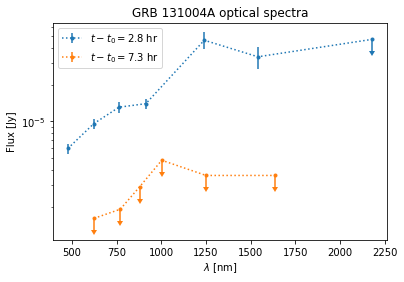

In [51]:
case = "131004A"
for time in [10080,26280]:#[55440,57903,323218]:
    data = results[(results["GRB"]==case) & (results["t_o"]==time)]
    lolims = [np.isinf(f.plus) for f in data["F_o"]]
    pos = [f.value*0.2 if np.isinf(f.plus) else f.plus for f in data["F_o"]]
    uplims = [np.isinf(f.minus) for f in data["F_o"]]
    neg = [f.value*0.2 if np.isinf(f.minus) else f.minus for f in data["F_o"]]
    val = [f.value for f in data["F_o"]]
    lam = 1e9*3e8/data["nu_o"]
    plt.errorbar(lam,val,yerr=(neg,pos),uplims=uplims,marker=".",linestyle=":",capthick=0,label=f"$t-t_0={time/3600:.1f}$ hr")
plt.legend()
plt.yscale("log")
plt.ylabel("Flux [Jy]")
plt.xlabel("$\lambda$ [nm]")
plt.title(f"GRB {case} optical spectra")
plt.savefig(f"./products/{case}_optspec.png",dpi=300,bbox_inches="tight")

## Illustrative example plot

In [ ]:
pd.set_option('display.max_rows', 300)
c1 = [np.abs(B.value-0.5)<0.1 and all(np.isfinite(B.items())) for B in results[B_ox_name]]
c2 = [B.plus != B.minus for B in results["B_x"]]
truths = [c1[i] and c2[i] for i in range(len(results))]
results[truths]

GRB                                                     180618A
t_o                                                       864.0
dt%                                                    0.026627
nu_o                                        689772696002300.875
F_o               0.0001503708480081596 ± 2.215946707484555e-05
nu_x          4.1880632448032506e+17 (+1.9991731172900093e+1...
F_x               2.086189112296885e-06 ± 5.034031554457077e-07
B_ox          0.6674828969336349 (+0.09662047798198997, -0.4...
α                                                           1.0
B_ox_w_err    0.6674828969336349 (+0.09729216604542491, -0.4...
B_x                           1.2200000000000002 (+0.25, -0.23)
Jak_dark                                                  False
vdH_dark                                                  False
Year                                                       2018
Name: 349, dtype: object

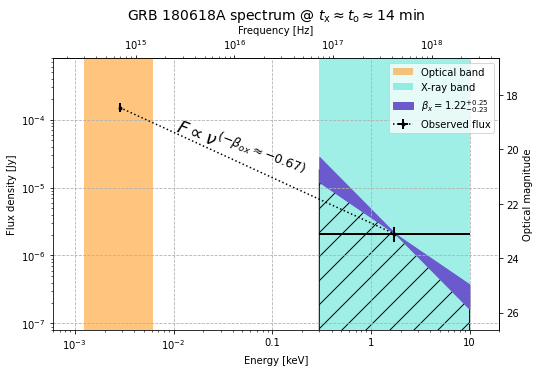

In [643]:
idx = 349
display(results.loc[idx,])
E_range = np.logspace(np.log10(0.3),np.log10(10),100)
grb = results.loc[idx,"GRB"]
beta = results.loc[idx,"B_x"]
E_o = results.loc[idx,"nu_o"]*6.62607015e-34/1.6021773e-16
E_x = results.loc[idx,"nu_x"]*6.62607015e-34/1.6021773e-16
F_o = results.loc[idx,"F_o"]
F_x = results.loc[idx,"F_x"]
t_o = results.loc[idx,"t_o"]
spectrum = E_range**-beta.value
scale = F_x.value/spectrum[len(spectrum)//2]
spectrum = scale * spectrum
spec1 = E_range**-beta.maximum
scale1 = F_x.value/spec1[len(spec1)//2]
spec1 = scale1 * spec1
spec2 = E_range**-beta.minimum
scale2 = F_x.value/spec2[len(spec2)//2]
spec2 = scale2 * spec2

fig,ax = plt.subplots(figsize=(8,5))

ax.fill_between([0.006199235,0.001239847],[1,1],alpha=0.5,fc="darkorange",label="Optical band")
ax.fill_between([0.3,10],[1,1],alpha=0.5,fc="turquoise",label="X-ray band")
ax.errorbar([E_o,E_x.value],[F_o.value,F_x.value],xerr=[(0,E_x.minus),(0,E_x.plus)],
             yerr=[(F_o.minus,F_x.minus),(F_o.plus,F_x.plus)],
             uplims=~np.isfinite((F_o.minus,F_x.minus)),capsize=0,elinewidth=2,marker=".",linestyle=":",color="k",label="Observed flux")
ax.fill_between(E_range,spectrum,fc="none",ec="k",hatch="/")
ax.fill_between(E_range,spec1,spec2,color="slateblue",label="$\\beta_x=%.2f_{-%.2f}^{+%.2f}$" %(beta.value,beta.minus,beta.plus))
ax.text(1e-2,1.3e-5,r"$F\propto\nu^{(-\beta_{ox}\approx\mathrm{-%.2f})}$" % results.loc[idx,B_ox_name].value,
         size=18,rotation=-21)

ax.legend(framealpha=0.75, loc="upper right")
ax.grid(linestyle="--")
ax.set_xlim(6e-4,20)
ax.set_ylim(8e-8,8e-4)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xticks([0.001,0.01,0.1,1,10])
ax.set_xticklabels(["$10^{-3}$","$10^{-2}$",0.1,1,10])
# ax.set_xticklabels(["$10^{-3}$","$10^{-2}$",0.3,10])
ax_top = ax.secondary_xaxis("top",functions=((lambda keV:keV*Hz_per_keV),(lambda Hz:Hz/Hz_per_keV)))
ax_top.set_xlabel("Frequency [Hz]")
ax_right = ax.secondary_yaxis("right",functions=((lambda Jy:-2.5*np.log10(Jy/3631)),(lambda m:3631*10**(-m/2.5))))
ax_right.set_ylabel("Optical magnitude")
ax_right.set_yticks(range(18,27,2))
ax_right.set_yticklabels(["18","20","22","24","26"])
# ax_right.set_yscale("linear")
# ax_right.invert_yaxis()

ax.set_title(r"GRB {} spectrum".format(grb)+r" @ $t_\mathrm{x}\approx t_\mathrm{o}\approx %.0f$ min"%round(t_o/60),size=14)
ax.set_xlabel("Energy [keV]")
ax.set_ylabel("Flux density [Jy]")
fig.savefig(f"./products/{grb}_spectrum.png",bbox_inches="tight",dpi=300)

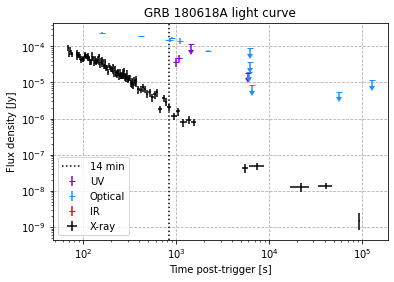

GRB     t_o       dt%  \
323  180618A   161.0  0.001487   
338  180618A   423.0  0.016343   
345  180618A   815.0  0.031596   
349  180618A   864.0  0.026627   
354  180618A   897.5  0.046156   
358  180618A  1001.0  0.048888   
361  180618A  1074.0  0.020474   
364  180618A  1112.0  0.056580   
367  180618A  1437.5  0.050929   
369  180618A  5882.5  0.071921   
370  180618A  6087.5  0.109277   
372  180618A  6190.0  0.127955   
374  180618A  6292.5  0.146632   
377  180618A  6497.5  0.124063   

                                            B_ox_w_err  \
323  0.27018177347071626 (+0.044748596060879525, -0...   
338  0.5462199361034078 (+0.0818627937857624, -0.42...   
345  0.677317056166536 (+0.09773780698132033, -0.51...   
349  0.6674828969336349 (+0.09729216604542491, -0.4...   
354  0.800724408534892 (+0.11536874054817413, -0.61...   
358  0.5563424102797698 (+0.10409478164988357, -0.4...   
361  0.5759094251223984 (+0.09770079103413999, -0.4...   
364  0.6804661264558612 (+0.10004264407911764, -0.4...   
367    0.8398757950940956 (+0.12927202054024545, -inf)   
369    1.0199452356852825 (+0.15271008584954765, -inf)   
370    0.9870282975728539 (+0.14609675880156883, -inf)   
372     1.1470094712914323 (+0.1579203445903674, -inf)   
374    1.0483195418809161 (+0.15386565599251006, -inf)   
377    0.8189779366377461 (+0.12361144056492365, -inf)   

                                   B_x    α Jak_dark vdH_dark  
323  1.2200000000000002 (+0.25, -0.23)  1.0     True     True  
338  1.2200000000000002 (+0.25, -0.23)  1.0    False    False  
345  1.2200000000000002 (+0.25, -0.23)  1.0    False    False  
349  1.2200000000000002 (+0.25, -0.23)  1.0    False    False  
354  1.2200000000000002 (+0.25, -0.23)  1.0    False    False  
358  1.2200000000000002 (+0.25, -0.23)  1.0    False    False  
361  1.2200000000000002 (+0.25, -0.23)  1.0    False    False  
364  1.2200000000000002 (+0.25, -0.23)  1.0    False    False  
367  1.2200000000000002 (+0.25, -0.23)  1.0    False    False  
369  1.2200000000000002 (+0.25, -0.23)  1.0    False    False  
370  1.2200000000000002 (+0.25, -0.23)  1.0    False    False  
372  1.2200000000000002 (+0.25, -0.23)  1.0    False    False  
374  1.2200000000000002 (+0.25, -0.23)  1.0    False    False  
377  1.2200000000000002 (+0.25, -0.23)  1.0    False    False

In [657]:
    fig,ax = plt.subplots()

    subset = all_optical.loc[(all_optical["GRB"]==grb)].copy()
    dark_points = close_times.loc[(close_times["GRB"]==grb) & (close_times["vdH_dark"]|close_times["Jak_dark"])]

    subset.loc[:,"band"] = ["UV" if wavelength<3000 else "IR" if wavelength>8000 else None if pd.isna(wavelength) else "Optical" for wavelength in subset["λ_eff"]]
    bands = {"UV":["darkviolet","$\lambda<3000$ Å"],"Optical":["dodgerblue","$\lambda<3000$ Å"],"IR":"red"}
    for band,info in bands.items():
        subsubset = subset[subset["band"]==band]
        neg_err = [0.3*flux.value if np.isinf(flux.minus) else flux.minus for flux in subsubset["Flux (Jy)"]]
        pos_err = [0.3*flux.value if np.isinf(flux.plus) else flux.plus for flux in subsubset["Flux (Jy)"]]
        ax.errorbar(subsubset["Time (s)"],[flux.value for flux in subsubset["Flux (Jy)"]],
                    marker="_",linestyle="",color=info[0],label=f"{band}",yerr=np.array((neg_err,pos_err)),
                    uplims=[np.isinf(point.minus) for point in subsubset["Flux (Jy)"]],
                    lolims=[np.isinf(point.plus) for point in subsubset["Flux (Jy)"]],capthick=0)

    subset = xrt_data.loc[xrt_data["GRB"]==grb]
    neg_err = [0.4*flux.value if np.isinf(flux.minus) else flux.minus for flux in subset["SpecFlux"]]
    pos_err = [0.4*flux.value if np.isinf(flux.plus) else flux.plus for flux in subset["SpecFlux"]]
    ax.errorbar(subset.Time,[flux.value for flux in subset.SpecFlux],
                xerr=np.array(subset.Tneg,subset.Tpos).T,yerr=np.array((neg_err,pos_err)),
                uplims=[np.isinf(point.minus) for point in subset["SpecFlux"]],
                lolims=[np.isinf(point.plus) for point in subset["SpecFlux"]],
                linestyle="",capthick=0,color="k",label="X-ray")

    ax.axvline(14*60,linestyle=":",color="k",label="14 min")
    ax.set(xscale="log",yscale="log",xlabel="Time post-trigger [s]",ylabel="Flux density [Jy]")
    tmin,tmax = ax.get_xlim()
    ax.legend()
    ax.grid(linestyle="--")
    ax.set_title(f"GRB {grb} light curve")
    
    fig.savefig(f"./products/{grb}_LC.png",dpi=300,transparent=False,facecolor="white",bbox_inches="tight")
    plt.show()
    display(close_times.loc[close_times["GRB"]==grb,["GRB","t_o","dt%",B_ox_name,"B_x","α","Jak_dark","vdH_dark"]])

## To-do

- compare $\beta_x$ distributions between vdH/Jakobsson dark bursts
    - dark between each method
    - dark vs non-dark for each method
- for dark but have optical detections, estimate extinctions ($A_v$)
    - if $\beta_x = \beta_{ox}$ (straight spectrum)
    - if it is -0.5 (assumed dark)
- $N_H$ vs. $\beta_{ox}$ plot and vs. $A_v$
- distribution of $N_H$: are dark mostly at the high end?
- deepest observation of each GRB over time -- have we gotten better at chasing them?
    - some indicator of how early we catch them?
    - at what time are GRBs dark?
- where are my early-time observations from? 
    - check David's tables
    - check Rastinejad, Fong sources
- interpolate XRT light curve to make data matches: does that get us more dark bursts?

### Project status

- finalize 'quantification' of early-time behavior (uninterestingly dark)
    - extra emission in xrays that makes it technically dark but not in the way we care about
- table: total # of sGRBs, # with xray detections, # with optical followup, # with temporally matched (at multiple % values), # dark, # interestingly dark
- fraction is # interestinly dark out of # with optical observations
    - different aspects to this: influence of using big telescopes, getting on it early, progress over the years, etc.
- of the ones that are interestingly dark, what can we say?
- 

### Paper structure
- GRBs two flavors: long/short
- shortly after discovery of afterglow, there were some that were optically dark. even in very fast followup there were some that were not found $\to$ led to classfication scheme for optical darkness where we quantify what we expect to see in optical based on xray. two methods based on what we expect from synchotron spectrum $\to p$. in long GRBs significant fraction due to host galaxy extinction, redshift, extra emission, etc. hasn't been done systematically for sGRBs. that's what we do here
- drill down to these are the interesting ones
- 2 part discussion: darkness in individual GRBs and then darkness in the short GRB population
    - darkness rate, comparison to long GRBs, what makes certain ones dark (characteristics), has rate changed over time
- properties of those and population as a whole in terms of stuff